**1. Preparations of environment**
---
In the first section there are all necessary steps related to the environment preparations.
1. Installation of necessary libraries used across the project
1. Import of the libraries. This action was split into 4 sections depending on the library usage.

In [3]:
# install required packages
!pip install medmnist
!pip install neptune
!pip install lime -q
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=4e09eff24f5a9ff8eb1069cb78f34277cdad25ad3769e4ccc6a1c90d8e357bba
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.7 MB/s eta 0:00:00
 

In [29]:
##### Import required libraries #####
# Import datasource related libraries
from medmnist import BloodMNIST, INFO, Evaluator
import medmnist

# Import libraries related to the model architecture creation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms

# Import Experiment Management Tool
import neptune

# Import XAI
import lime
from lime import lime_image
from captum.attr import GradientShap
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz

**neptune.ai session initialization**

To simplify the initialization of neptune connection, there was a method created. Method assign initial information about run such us:
*   name
*   experiment parameters
*   tags

In [ ]:
def init_neptune(params,name,tags):
  run = neptune.init_run(
      name = name,
      project="konrads/BloodMNIST",
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOWU0OTFlYS0yOThmLTQzYzUtYmE5ZC0xY2E3ZjhkMGViOGEifQ==",
       tags=tags)
  run["parameters"] = params
  return run

**2. Hyperparametrs and environments variables setup**
---

Following session contains hyperparameters and device setup.

In [5]:
# Hyperparameters and device setup
# Define parameters

# dataset parameters
data_flag = 'bloodmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Hyperparameters
batch_sizes = [16,32,64]
epochs = 50
learning_rates = [0.001,0.01,0.1]

# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Early stopping parameters
patience = 5
best_loss = np.inf
epochs_without_improvement = 0


**3. Source data preparation - Preprocessing**
---

In this section following actions take place:

1.   Dataset without data augmentation is being loaded
1.   DataLoaders without data augmentation are prepared
1.   Sample visualizations are displayed

**Data Load - without data augmentation**

---





In [6]:
# transfromations required to load the dataset
transform = transforms.Compose([  # No augmentation for testing
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
# load BlooMNIST dataset
size = 64
download = True

# split dataset into Train, Test and Validate sets
train_dataset = BloodMNIST(split='train', download=download, size = size,transform = transform)
val_dataset = BloodMNIST(split='val', download=download,size = size,transform = transform)
test_dataset = BloodMNIST(split='test', download=download,size = size,transform = transform)


100%|██████████| 156M/156M [00:09<00:00, 16.1MB/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


**Sample Visualization**

---



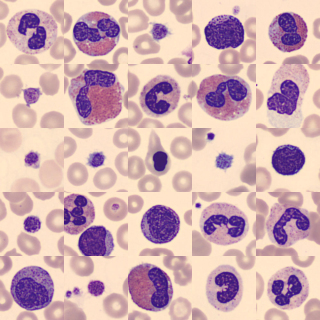

In [ ]:
# montage
train_dataset.montage(length=5)

**Data load with data augmentation**

---



In [ ]:
# Data augmentation transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4),  # Random cropping
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    transforms.RandomRotation(15),  # Random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([  # No augmentation for testing
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([  # No augmentation for testing
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# load BlooMNIST dataset
size = 64
download = True

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# split dataset into Train, Test and Validate sets
train_dataset_aug = BloodMNIST(split='train', download=download, size = size,transform = train_transform)
val_dataset_aug = BloodMNIST(split='val', download=download,size = size,transform = test_transform)
test_dataset_aug = BloodMNIST(split='test', download=download,size = size,transform = test_transform)

Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


**4. CNN Architecture**
---

In this step there was a set of functions created to build the proposed CNN architecture.


In [34]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # Adjust for output size after pooling
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.reshape(-1, 64 * 8 * 8)  # Adjust for output size after pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**5. Model training and evaluation methods**
---

Methods described in following cell are used to train models with us of custom parameters.

In [ ]:
# data loaders preparations
def data_loaders_preparation(train_dataset, val_dataset, test_dataset, batch_size):
  # Prepare Data Loaders - without data augmentation
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  return train_loader, test_loader, val_loader

In [ ]:
# Set up training
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(torch.device(device)), target.to(torch.device(device))
        optimizer.zero_grad()
        outputs = model(data)
        target = target.squeeze()
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Set up evaluation
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(torch.device(device)), target.to(torch.device(device))
            outputs = model(data)
            target = target.squeeze()
            test_loss += criterion(outputs, target).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

def train_and_test_model(model, train_loader, test_loader, val_loader, epochs, learning_rate, patience, best_loss,epochs_without_improvement,name,data_augmentation=False):

    # Initialize loss, and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Training and testing loop
    train_losses = []
    test_losses = []
    accuracies = []

    # Training and testing loop
    for epoch in range(epochs):
          train_loss = train(model, train_loader, criterion, optimizer, device)
          test_loss, accuracy = evaluate(model, test_loader, criterion, device)
          print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
          # append information in neptune.ai run
          run["train/accuracy"].append(accuracy)
          run["train/loss"].append(test_loss)
          # Store metrics for plotting
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          accuracies.append(accuracy)

          # Validation phase (after each epoch)
          val_loss = 0.0
          model.eval()
          with torch.no_grad():
              for images, labels in val_loader:
                  images, labels = images.to(device), labels.to(device)
                  outputs = model(images)
                  labels = labels.squeeze()
                  loss = criterion(outputs, labels)
                  val_loss += loss.item()
          val_loss /= len(val_loader)

          # Early stopping check
          if val_loss < best_loss:
              best_loss = val_loss
              epochs_without_improvement = 0
              torch.save(model.state_dict(), f'BloodMNIST-{name}-best-model.pth')

          else:
              epochs_without_improvement += 1
              if epochs_without_improvement >= patience:
                  print(f"Early stopping at epoch {epoch+1}")
                  break
    return train_losses, test_losses, accuracies

# Accuracy and loss visualization
def visualize_training_progress(train_losses, test_losses, accuracies):
    # Plotting the training progress
    plt.figure(figsize=(10, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()


**6. Training and testing model without data augmentation**
---
Training and testing of the custom model was split into two sections. Split was defined similar as dataset types:
*   Without data augmentation
*   With data augmentation

This split was created to check if for the BloodMNIST data augmentation is important factor impacting model performance.


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-73


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torch.device'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
[neptune] [warning] NeptuneUnsupportedValue: WARNING: The value you're trying to log is a nonstandard float value (inf) that is not currently supported. We'll add support for this type of value in the fut

Epoch 1/50, Train Loss: 0.6850, Test Loss: 0.3573, Accuracy: 0.8720
Epoch 2/50, Train Loss: 0.2781, Test Loss: 0.3675, Accuracy: 0.8690
Epoch 3/50, Train Loss: 0.1908, Test Loss: 0.2620, Accuracy: 0.9018
Epoch 4/50, Train Loss: 0.1402, Test Loss: 0.1435, Accuracy: 0.9556
Epoch 5/50, Train Loss: 0.1031, Test Loss: 0.1604, Accuracy: 0.9477
Epoch 6/50, Train Loss: 0.0854, Test Loss: 0.1375, Accuracy: 0.9556
Epoch 7/50, Train Loss: 0.0817, Test Loss: 0.1453, Accuracy: 0.9547
Epoch 8/50, Train Loss: 0.0561, Test Loss: 0.1283, Accuracy: 0.9661
Epoch 9/50, Train Loss: 0.0481, Test Loss: 0.1645, Accuracy: 0.9550
Epoch 10/50, Train Loss: 0.0474, Test Loss: 0.1544, Accuracy: 0.9570
Epoch 11/50, Train Loss: 0.0363, Test Loss: 0.1600, Accuracy: 0.9614
Epoch 12/50, Train Loss: 0.0359, Test Loss: 0.1760, Accuracy: 0.9562
Epoch 13/50, Train Loss: 0.0310, Test Loss: 0.1413, Accuracy: 0.9658
Early stopping at epoch 13


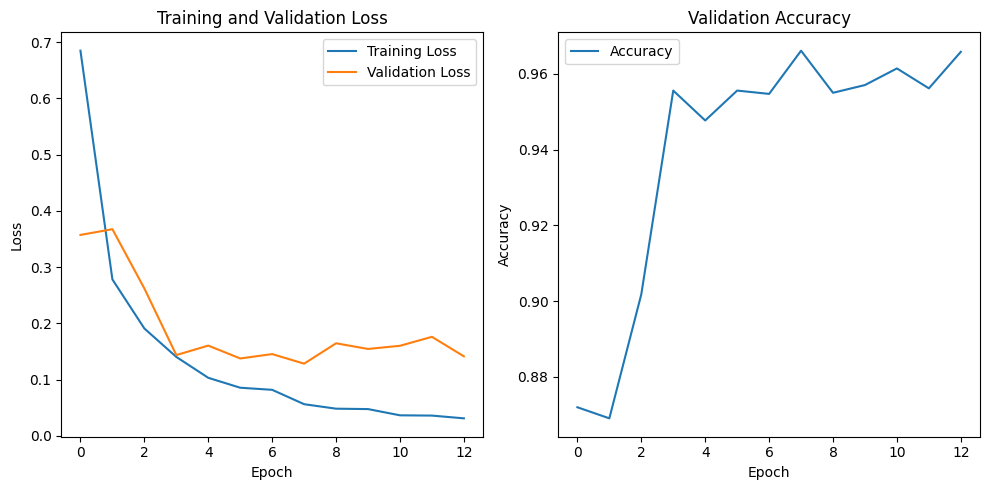

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-73/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-74
Epoch 1/50, Train Loss: 0.7967, Test Loss: 0.4779, Accuracy: 0.8255
Epoch 2/50, Train Loss: 0.4602, Test Loss: 0.4225, Accuracy: 0.8547
Epoch 3/50, Train Loss: 0.4018, Test Loss: 0.3963, Accuracy: 0.8758
Epoch 4/50, Train Loss: 0.3409, Test Loss: 0.3283, Accuracy: 0.8892
Epoch 5/50, Train Loss: 0.3136, Test Loss: 0.3011, Accuracy: 0.9027
Epoch 6/50, Train Loss: 0.2852, Test Loss: 0.4410, Accuracy: 0.8652
Epoch 7/50, Train Loss: 0.2743, Test Loss: 0.2830, Accuracy: 0.9059
Epoch 8/50

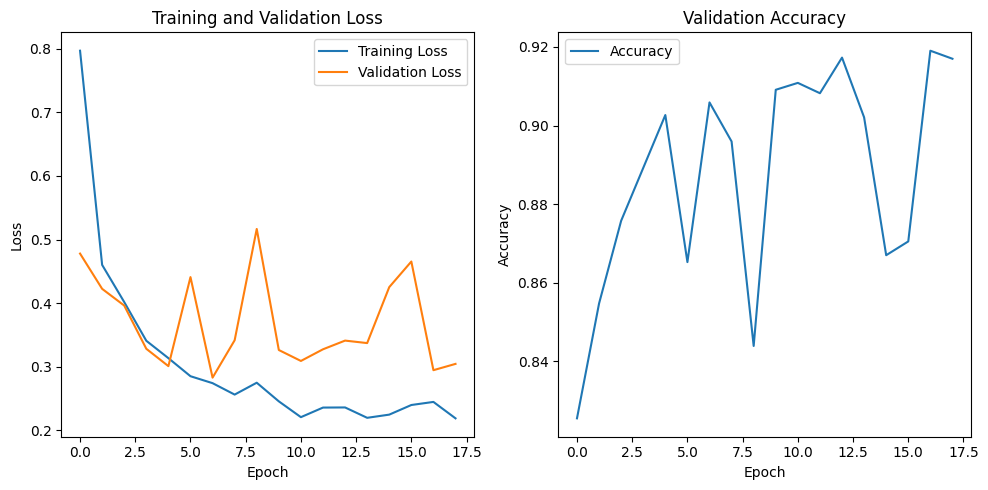

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-74/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-75
Epoch 1/50, Train Loss: 25.3140, Test Loss: 2.0334, Accuracy: 0.1374
Epoch 2/50, Train Loss: 2.0172, Test Loss: 2.0137, Accuracy: 0.1824
Epoch 3/50, Train Loss: 2.0177, Test Loss: 2.0275, Accuracy: 0.1824
Epoch 4/50, Train Loss: 2.0174, Test Loss: 2.0161, Accuracy: 0.1824
Epoch 5/50, Train Loss: 2.0163, Test Loss: 2.0101, Accuracy: 0.1947
Epoch 6/50, Train Loss: 2.0183, Test Loss: 2.0423, Accuracy: 0.1947
Epoch 7/50, Train Loss: 2.0178, Test Loss: 2.0214, Accuracy: 0.1824
Epoch 8/5

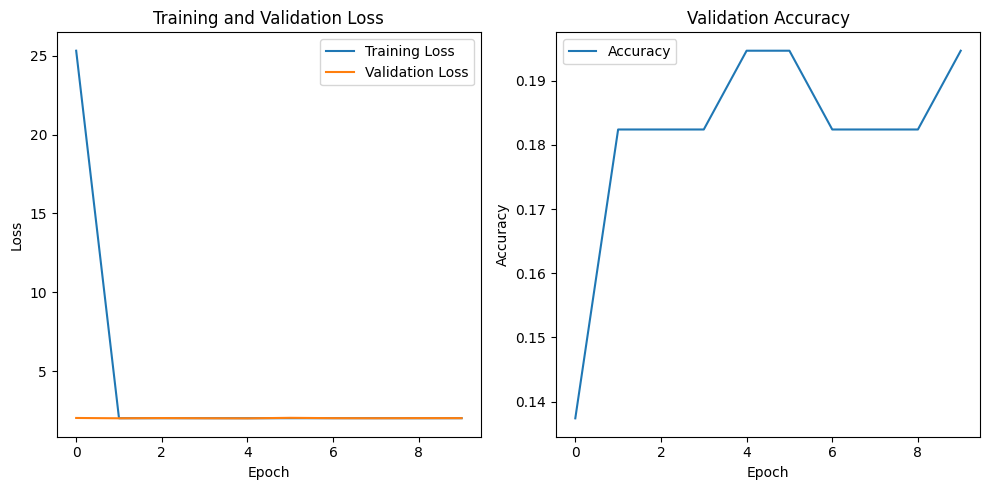

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-75/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-76
Epoch 1/50, Train Loss: 0.7068, Test Loss: 0.5361, Accuracy: 0.7974
Epoch 2/50, Train Loss: 0.3039, Test Loss: 0.2569, Accuracy: 0.9065
Epoch 3/50, Train Loss: 0.2074, Test Loss: 0.2769, Accuracy: 0.8939
Epoch 4/50, Train Loss: 0.1567, Test Loss: 0.1977, Accuracy: 0.9348
Epoch 5/50, Train Loss: 0.1311, Test Loss: 0.1487, Accuracy: 0.9526
Epoch 6/50, Train Loss: 0.0996, Test Loss: 0.1841, Accuracy: 0.9439
Epoch 7/50, Train Loss: 0.0854, Test Loss: 0.1396, Accuracy: 0.9564
Epoch 8/50

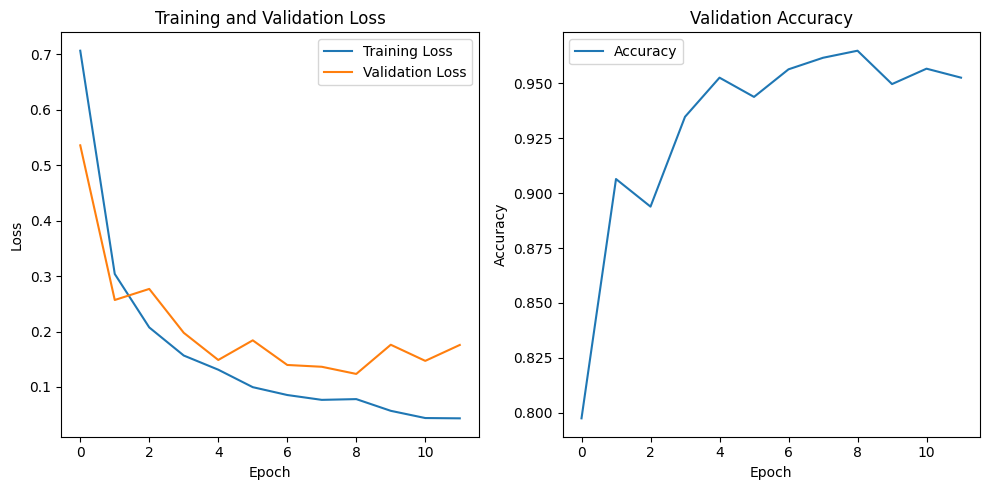

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-76/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-77
Epoch 1/50, Train Loss: 0.7507, Test Loss: 0.4801, Accuracy: 0.8346
Epoch 2/50, Train Loss: 0.3927, Test Loss: 0.3559, Accuracy: 0.8799
Epoch 3/50, Train Loss: 0.3185, Test Loss: 0.2767, Accuracy: 0.9190
Epoch 4/50, Train Loss: 0.2589, Test Loss: 0.3268, Accuracy: 0.9117
Epoch 5/50, Train Loss: 0.2460, Test Loss: 0.3157, Accuracy: 0.9187
Epoch 6/50, Train Loss: 0.2323, Test Loss: 0.3656, Accuracy: 0.9050
Epoch 7/50, Train Loss: 0.2154, Test Loss: 0.3651, Accuracy: 0.9094
Epoch 8/50

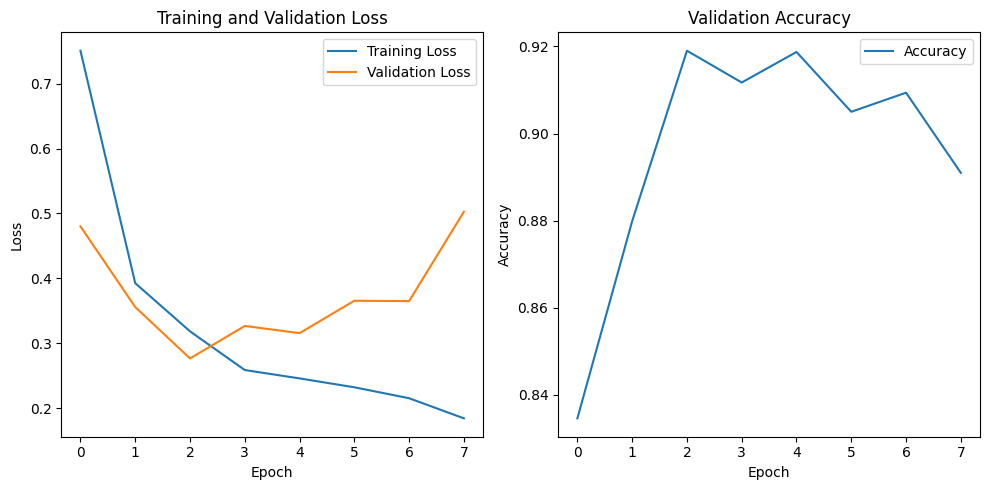

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-77/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-78
Epoch 1/50, Train Loss: 108.1175, Test Loss: 2.0093, Accuracy: 0.1947
Epoch 2/50, Train Loss: 2.0120, Test Loss: 2.0190, Accuracy: 0.1692
Epoch 3/50, Train Loss: 2.0151, Test Loss: 2.0186, Accuracy: 0.1947
Epoch 4/50, Train Loss: 2.0145, Test Loss: 2.0075, Accuracy: 0.1947
Epoch 5/50, Train Loss: 2.0145, Test Loss: 2.0095, Accuracy: 0.1947
Epoch 6/50, Train Loss: 2.0124, Test Loss: 2.0048, Accuracy: 0.1947
Epoch 7/50, Train Loss: 2.0139, Test Loss: 2.0112, Accuracy: 0.1947
Epoch 8/

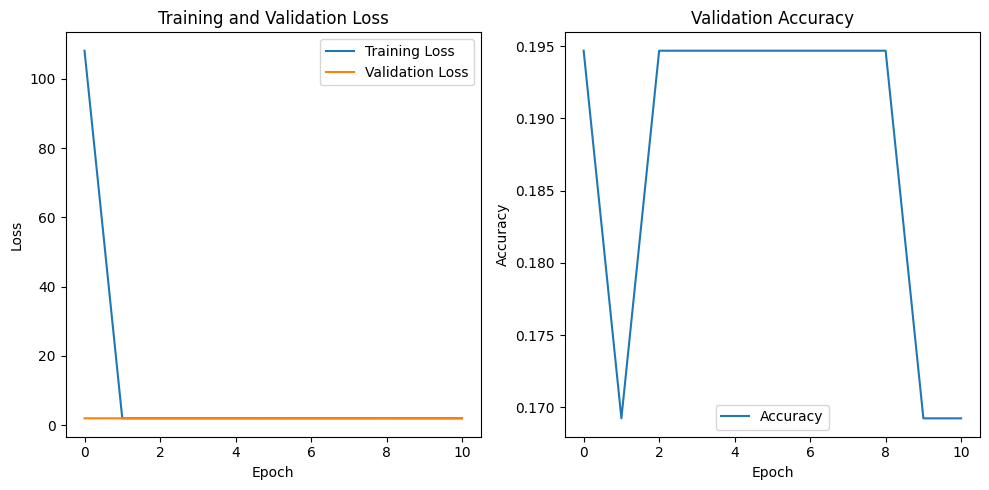

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-78/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-79
Epoch 1/50, Train Loss: 0.9037, Test Loss: 0.5259, Accuracy: 0.8156
Epoch 2/50, Train Loss: 0.4400, Test Loss: 0.3720, Accuracy: 0.8749
Epoch 3/50, Train Loss: 0.3072, Test Loss: 0.3051, Accuracy: 0.8892
Epoch 4/50, Train Loss: 0.2412, Test Loss: 0.2427, Accuracy: 0.9184
Epoch 5/50, Train Loss: 0.1789, Test Loss: 0.2013, Accuracy: 0.9363
Epoch 6/50, Train Loss: 0.1495, Test Loss: 0.1642, Accuracy: 0.9456
Epoch 7/50, Train Loss: 0.1343, Test Loss: 0.1739, Accuracy: 0.9410
Epoch 8/50

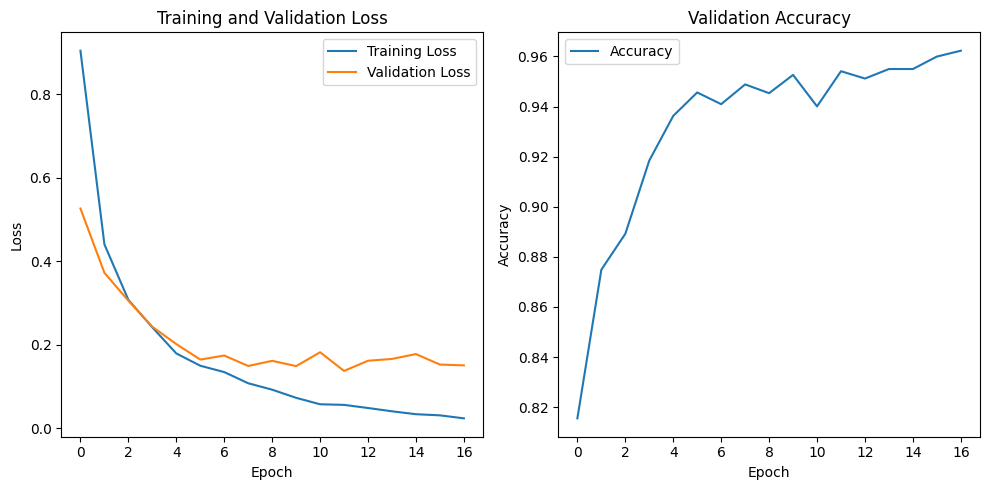

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-79/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-80
Epoch 1/50, Train Loss: 1.1448, Test Loss: 0.6114, Accuracy: 0.7799
Epoch 2/50, Train Loss: 0.5590, Test Loss: 0.4564, Accuracy: 0.8337
Epoch 3/50, Train Loss: 0.4241, Test Loss: 0.4536, Accuracy: 0.8348
Epoch 4/50, Train Loss: 0.3152, Test Loss: 0.3770, Accuracy: 0.8626
Epoch 5/50, Train Loss: 0.2842, Test Loss: 0.3059, Accuracy: 0.8962
Epoch 6/50, Train Loss: 0.2373, Test Loss: 0.3099, Accuracy: 0.8992
Epoch 7/50, Train Loss: 0.2061, Test Loss: 0.2668, Accuracy: 0.9123
Epoch 8/50

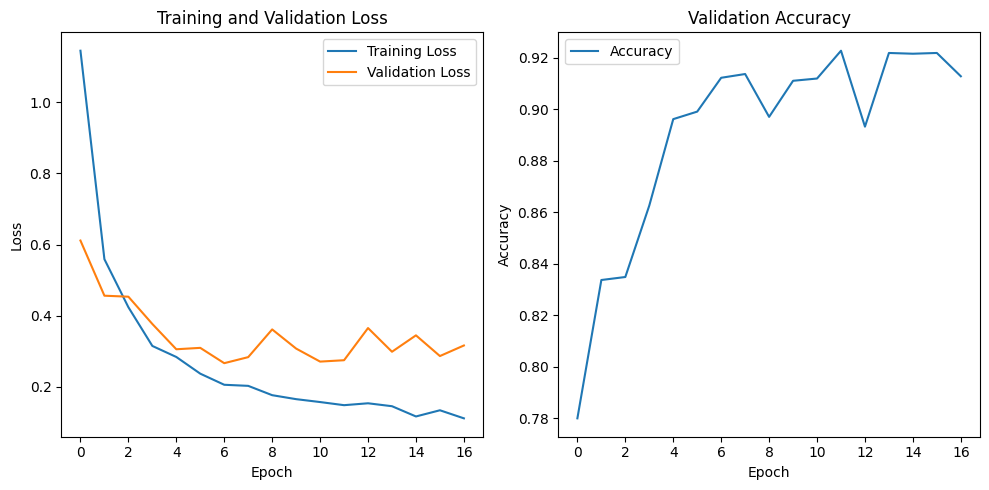

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-80/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-81
Epoch 1/50, Train Loss: 112.1224, Test Loss: 2.0089, Accuracy: 0.1947
Epoch 2/50, Train Loss: 2.0083, Test Loss: 2.0116, Accuracy: 0.1947
Epoch 3/50, Train Loss: 2.0094, Test Loss: 2.0088, Accuracy: 0.1824
Epoch 4/50, Train Loss: 2.0102, Test Loss: 2.0076, Accuracy: 0.1824
Epoch 5/50, Train Loss: 2.0110, Test Loss: 2.0117, Accuracy: 0.1947
Epoch 6/50, Train Loss: 2.0106, Test Loss: 2.0069, Accuracy: 0.1692
Epoch 7/50, Train Loss: 2.0096, Test Loss: 2.0111, Accuracy: 0.1947
Epoch 8/

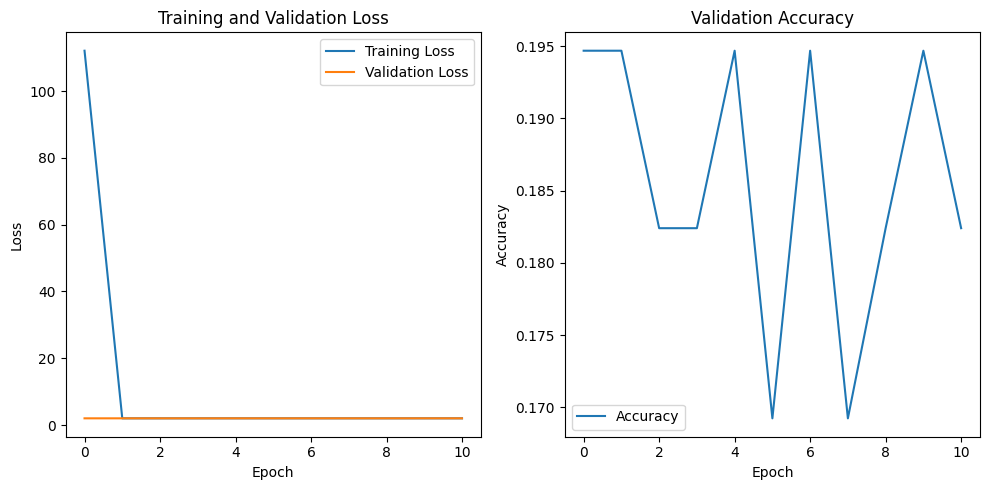

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-81/metadata


In [ ]:
# Various Hyperparameters execution
for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    # start neptune run
    # parameters structured as dict to pass them to neptune
    params = {
      "epochs": epochs,
      "batch_size": batch_size,
      "data_flag": data_flag,
      "architecture": "CNN",
      "optimizer": "AdamW",
      "metrics": ["accuracy", "loss"],
      "activation": "relu",
      "learning_rate":learning_rate,
      "device": device,
      "patience": patience,
      "best_loss": best_loss,
      "epochs_without_improvement": epochs_without_improvement,
      "data_augmentation": False
    }
    tags = ["custom_architecture","without_data_augmentation"]
    name = f"Without-Data-Augmentation-bs{str(batch_size)}-lr{str(learning_rate)}"
    run = init_neptune(params,name,tags)

    # Initiate instance of CNN
    model = CNN(n_classes).to(device)

    # Setup variables for training
    train_loader,test_loader,val_loader = data_loaders_preparation(train_dataset, val_dataset, test_dataset, batch_size)
    epochs = epochs
    learning_rate = learning_rate
    patience = patience
    best_loss = best_loss
    epochs_without_improvement = epochs_without_improvement
    data_augmentation=False

    # train model
    train_losses, test_losses, accuracies = train_and_test_model(model,train_loader,test_loader,val_loader,epochs,learning_rate,patience,best_loss,epochs_without_improvement,name,data_augmentation)

    # visualize results
    visualize_training_progress(train_losses, test_losses, accuracies)
    run["test/results"].upload("training_progress.png")

    # stop neptune run
    run.stop()


**7. Training and testing model with data augmentation**
---

Following cell contains few adjustment that allows to use dataset with data augmentation applied.

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-82
Epoch 1/50, Train Loss: 0.6778, Test Loss: 0.4574, Accuracy: 0.8167
Epoch 2/50, Train Loss: 0.3171, Test Loss: 0.1905, Accuracy: 0.9383
Epoch 3/50, Train Loss: 0.2161, Test Loss: 0.1940, Accuracy: 0.9331
Epoch 4/50, Train Loss: 0.1821, Test Loss: 0.2155, Accuracy: 0.9211
Epoch 5/50, Train Loss: 0.1596, Test Loss: 0.1129, Accuracy: 0.9664
Epoch 6/50, Train Loss: 0.1345, Test Loss: 0.1264, Accuracy: 0.9620
Epoch 7/50, Train Loss: 0.1272, Test Loss: 0.1362, Accuracy: 0.9582
Epoch 8/50, Train Loss: 0.1125, Test Loss: 0.1365, Accuracy: 0.9544
Epoch 9/50, Train Loss: 0.1044, Test Loss: 0.1095, Accuracy: 0.9684
Epoch 10/50, Train Loss: 0.0905, Test Loss: 0.1030, Accuracy: 0.9716
Epoch 11/50, Train Loss: 0.0895, Test Loss: 0.1022, Accuracy: 0.9667
Epoch 12/50, Train Loss: 0.0919, Test Loss: 0.0971, Accuracy: 0.9743
Epoch 13/50, Train Loss: 0.0868, Test Loss: 0.0903, Accuracy: 0.9772
E

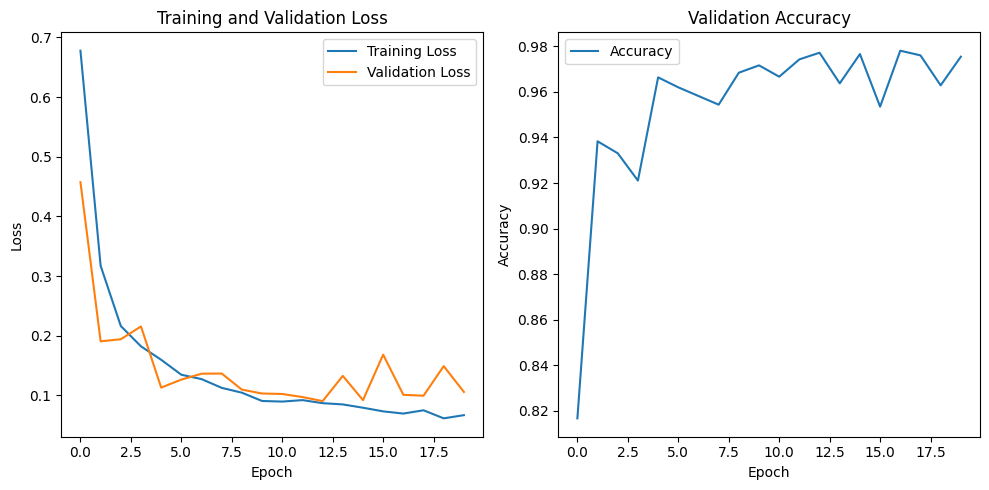

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-82/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-83
Epoch 1/50, Train Loss: 0.9735, Test Loss: 0.6239, Accuracy: 0.7580
Epoch 2/50, Train Loss: 0.5896, Test Loss: 0.5337, Accuracy: 0.8012
Epoch 3/50, Train Loss: 0.5449, Test Loss: 0.5003, Accuracy: 0.8214
Epoch 4/50, Train Loss: 0.5137, Test Loss: 0.4862, Accuracy: 0.8202
Epoch 5/50, Train Loss: 0.4927, Test Loss: 0.4316, Accuracy: 0.8585
Epoch 6/50, Train Loss: 0.4843, Test Loss: 0.5401, Accuracy: 0.8097
Epoch 7/50, Train Loss: 0.4806, Test Loss: 0.4511, Accuracy: 0.8474
Epoch 8/50

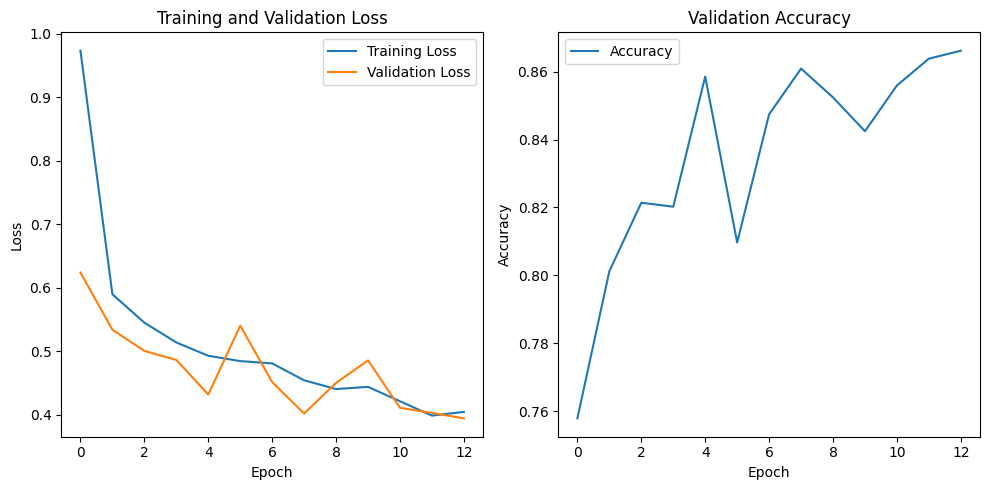

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-83/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-84
Epoch 1/50, Train Loss: 60.5699, Test Loss: 2.0180, Accuracy: 0.1947
Epoch 2/50, Train Loss: 2.0181, Test Loss: 2.0131, Accuracy: 0.1947
Epoch 3/50, Train Loss: 2.0173, Test Loss: 2.0303, Accuracy: 0.1824
Epoch 4/50, Train Loss: 2.0183, Test Loss: 2.0132, Accuracy: 0.1947
Epoch 5/50, Train Loss: 2.0208, Test Loss: 2.0226, Accuracy: 0.1692
Epoch 6/50, Train Loss: 2.0190, Test Loss: 2.0063, Accuracy: 0.1824
Epoch 7/50, Train Loss: 2.0191, Test Loss: 2.0136, Accuracy: 0.1824
Epoch 8/5

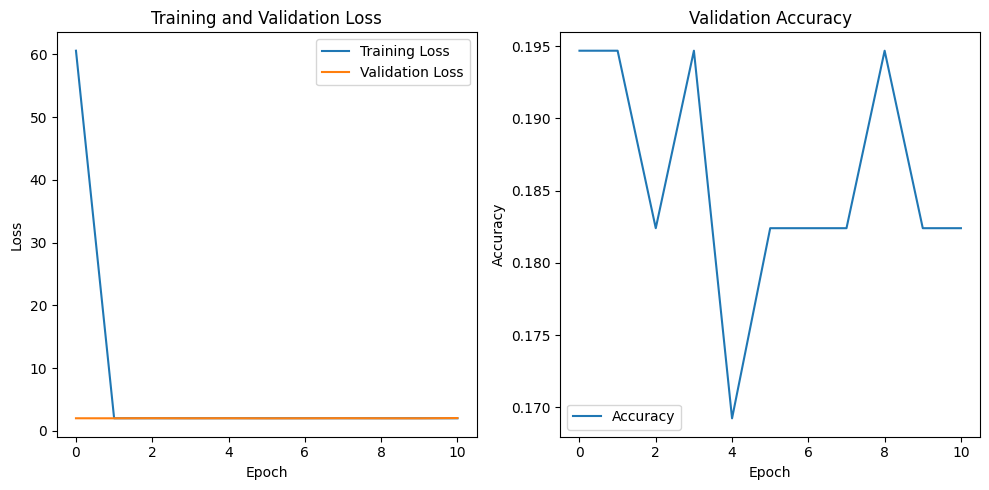

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-84/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-85
Epoch 1/50, Train Loss: 0.7523, Test Loss: 0.3723, Accuracy: 0.8807
Epoch 2/50, Train Loss: 0.3473, Test Loss: 0.3986, Accuracy: 0.8579
Epoch 3/50, Train Loss: 0.2450, Test Loss: 0.1741, Accuracy: 0.9453
Epoch 4/50, Train Loss: 0.2065, Test Loss: 0.1598, Accuracy: 0.9442
Epoch 5/50, Train Loss: 0.1784, Test Loss: 0.1889, Accuracy: 0.9310
Epoch 6/50, Train Loss: 0.1484, Test Loss: 0.1150, Accuracy: 0.9638
Epoch 7/50, Train Loss: 0.1388, Test Loss: 0.1301, Accuracy: 0.9600
Epoch 8/50

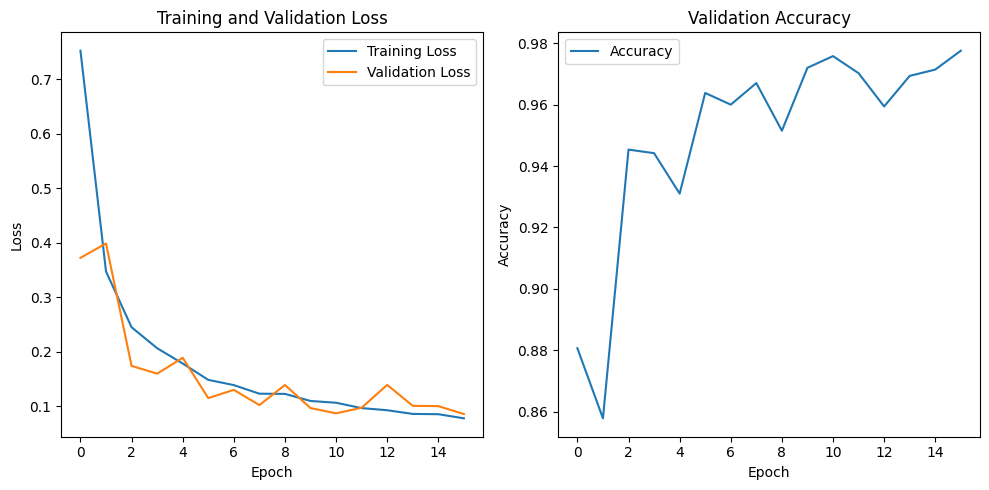

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-85/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-86
Epoch 1/50, Train Loss: 0.9641, Test Loss: 0.6392, Accuracy: 0.7425
Epoch 2/50, Train Loss: 0.5360, Test Loss: 0.4263, Accuracy: 0.8486
Epoch 3/50, Train Loss: 0.4560, Test Loss: 0.4235, Accuracy: 0.8498
Epoch 4/50, Train Loss: 0.4010, Test Loss: 0.3541, Accuracy: 0.8778
Epoch 5/50, Train Loss: 0.3841, Test Loss: 0.2944, Accuracy: 0.8942
Epoch 6/50, Train Loss: 0.3621, Test Loss: 0.3406, Accuracy: 0.8834
Epoch 7/50, Train Loss: 0.3406, Test Loss: 0.2904, Accuracy: 0.8962
Epoch 8/50

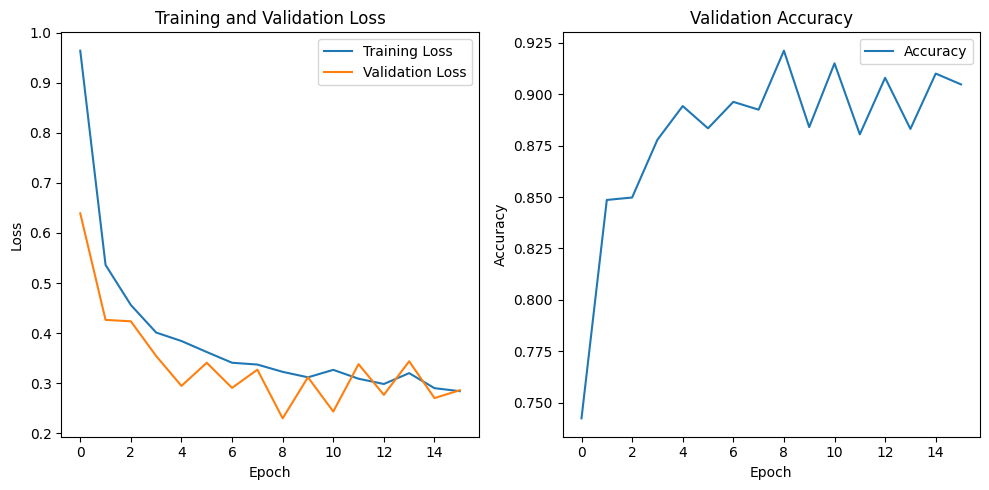

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-86/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-87
Epoch 1/50, Train Loss: 35.2364, Test Loss: 2.0184, Accuracy: 0.1947
Epoch 2/50, Train Loss: 2.0119, Test Loss: 2.0083, Accuracy: 0.1947
Epoch 3/50, Train Loss: 2.0143, Test Loss: 2.0111, Accuracy: 0.1824
Epoch 4/50, Train Loss: 2.0154, Test Loss: 2.0087, Accuracy: 0.1824
Epoch 5/50, Train Loss: 2.0144, Test Loss: 2.0075, Accuracy: 0.1824
Epoch 6/50, Train Loss: 2.0136, Test Loss: 2.0069, Accuracy: 0.1947
Epoch 7/50, Train Loss: 2.0152, Test Loss: 2.0105, Accuracy: 0.1947
Epoch 8/5

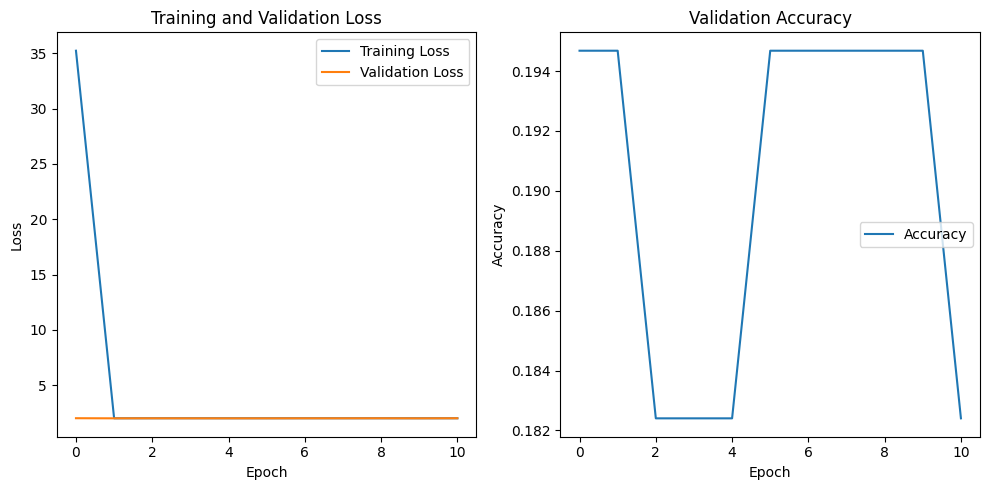

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-87/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-88
Epoch 1/50, Train Loss: 1.1307, Test Loss: 0.7484, Accuracy: 0.7273
Epoch 2/50, Train Loss: 0.6193, Test Loss: 0.4290, Accuracy: 0.8544
Epoch 3/50, Train Loss: 0.3976, Test Loss: 0.4364, Accuracy: 0.8401
Epoch 4/50, Train Loss: 0.3164, Test Loss: 0.2828, Accuracy: 0.8994
Epoch 5/50, Train Loss: 0.2583, Test Loss: 0.2065, Accuracy: 0.9319
Epoch 6/50, Train Loss: 0.2254, Test Loss: 0.1902, Accuracy: 0.9351
Epoch 7/50, Train Loss: 0.1954, Test Loss: 0.1683, Accuracy: 0.9427
Epoch 8/50

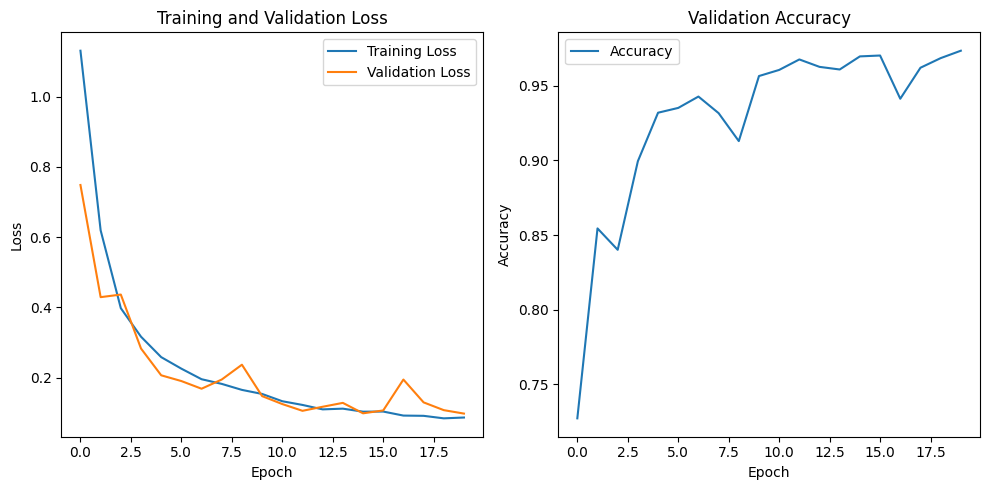

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-88/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-89
Epoch 1/50, Train Loss: 1.4603, Test Loss: 0.7836, Accuracy: 0.7106
Epoch 2/50, Train Loss: 0.6355, Test Loss: 0.5123, Accuracy: 0.8071
Epoch 3/50, Train Loss: 0.5547, Test Loss: 0.4924, Accuracy: 0.8176
Epoch 4/50, Train Loss: 0.5262, Test Loss: 0.5131, Accuracy: 0.8132
Epoch 5/50, Train Loss: 0.4888, Test Loss: 0.4688, Accuracy: 0.8351
Epoch 6/50, Train Loss: 0.4883, Test Loss: 0.4141, Accuracy: 0.8538
Epoch 7/50, Train Loss: 0.4495, Test Loss: 0.3720, Accuracy: 0.8720
Epoch 8/50

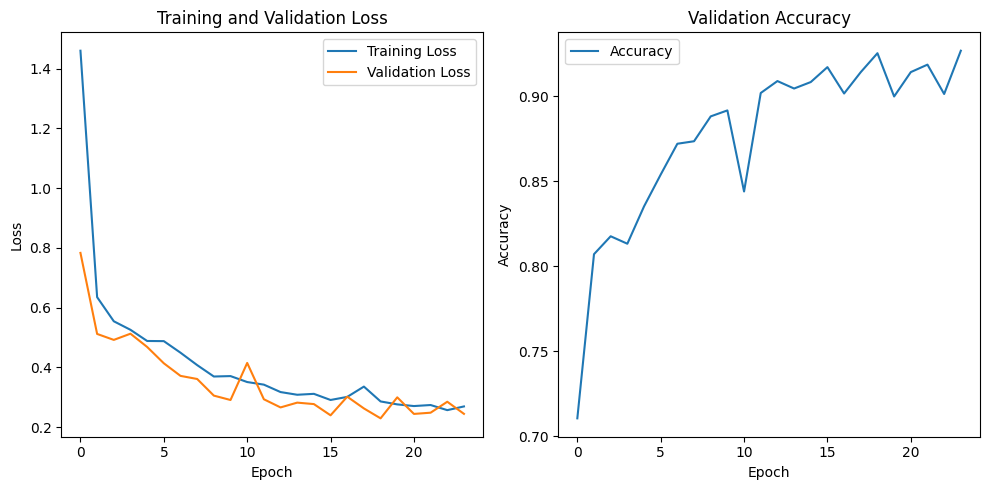

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-89/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-90
Epoch 1/50, Train Loss: 34.2181, Test Loss: 2.0063, Accuracy: 0.1947
Epoch 2/50, Train Loss: 2.0084, Test Loss: 2.0065, Accuracy: 0.1947
Epoch 3/50, Train Loss: 2.0094, Test Loss: 2.0066, Accuracy: 0.1824
Epoch 4/50, Train Loss: 2.0094, Test Loss: 2.0060, Accuracy: 0.1824
Epoch 5/50, Train Loss: 2.0115, Test Loss: 2.0063, Accuracy: 0.1947
Epoch 6/50, Train Loss: 2.0101, Test Loss: 2.0046, Accuracy: 0.1824
Epoch 7/50, Train Loss: 2.0096, Test Loss: 2.0063, Accuracy: 0.1824
Epoch 8/5

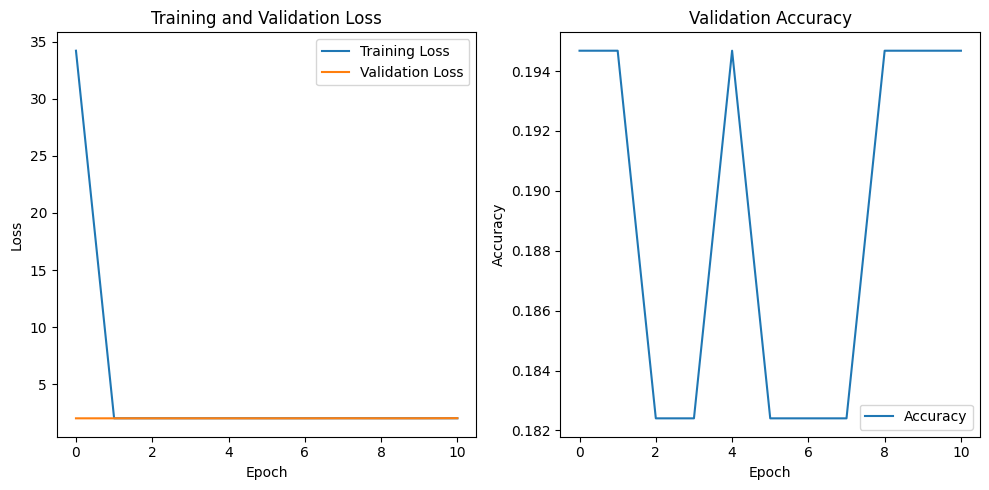

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-90/metadata


In [ ]:
# Various Hyperparameters execution
for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    # start neptune run
    params = {
      "epochs": epochs,
      "batch_size": batch_size,
      "data_flag": data_flag,
      "architecture": "CNN",
      "optimizer": "AdamW",
      "metrics": ["accuracy", "loss"],
      "activation": "relu",
      "learning_rate":learning_rate,
      "device": device,
      "patience": patience,
      "best_loss": best_loss,
      "epochs_without_improvement": epochs_without_improvement,
      "data_augmentation": True
    }
    tags = ["custom_architecture","data_augmentation"]
    name = f"Data-Augmentation-bs{str(batch_size)}-lr{str(learning_rate)}"
    run = init_neptune(params,name,tags)


    # Initiate instance of CNN
    model = CNN(n_classes).to(device)

    # Setup variables for training
    train_loader,test_loader,val_loader = data_loaders_preparation(train_dataset_aug, val_dataset_aug, test_dataset_aug, batch_size)
    epochs = epochs
    patience = patience
    best_loss = best_loss
    epochs_without_improvement = epochs_without_improvement
    learning_rate = learning_rate
    data_augmentation=True

    # train model
    train_losses_aug, test_losses_aug, accuracies_aug = train_and_test_model(model,train_loader,test_loader,val_loader,epochs,learning_rate,patience,best_loss,epochs_without_improvement,name,data_augmentation)

    # visualize results
    visualize_training_progress(train_losses_aug, test_losses_aug, accuracies_aug)
    run["test/results"].upload("training_progress.png")

    # stop neptune run
    run.stop()

**8. Pre-trained models usage**
---

To have a greater number of models to select the best one, there were 4 pre-trained models used:
*   resnet18
*   googlenet
*   resnext50_32x4d
*   wide_resnet50_2

Models were assigned to a list variable <models_pretrained> that is later used to train models one by one in loop.

**Selection of models**

In [ ]:
# Load all pretrained models
resnet18 = models.resnet18(pretrained=True)
googlenet = models.googlenet(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)

models_pretrained = [resnet18,googlenet,resnext50_32x4d,wide_resnet50_2]

**Create function that return a variable name**

To have better transparency in neptune.ai there is a need to assign unique run name. To do so there was a function created that returns a variable name.

In [ ]:
def return_variable_name(variable):
    variable_name = [name for name, value in globals().items() if value is variable][0]
    return(variable_name)

**9.Transfer learning - without data augmentation**
---

Similarly as in case of custom CNN architecture, actions related with models training were split into:
*   without data augmentation
*   with data augmentation

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-107


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.googlenet.GoogLeNet'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type


Epoch 1/50, Train Loss: 0.9344, Test Loss: 0.6079, Accuracy: 0.8027
Epoch 2/50, Train Loss: 0.7229, Test Loss: 0.5583, Accuracy: 0.8194
[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/neptune/internal/backends/swagger_client_wrapper.py", line 111, in __call__
    return FinishedApiResponseFuture(future.response())  # wait synchronously
                                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bravado/http_future.py", line 124, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bravado/http_future.py", line 300, in _get_swagger_result
    unmarshal_response(
  File "/usr/local/lib/python3.11/dist-packages/bravado/http_future.py", line 353, in unmarshal_response
    raise_on_expected(incoming_response)
  

Epoch 3/50, Train Loss: 0.6856, Test Loss: 0.5426, Accuracy: 0.8188
Epoch 4/50, Train Loss: 0.6911, Test Loss: 0.5329, Accuracy: 0.8156
Epoch 5/50, Train Loss: 0.6912, Test Loss: 0.5551, Accuracy: 0.8141
Epoch 6/50, Train Loss: 0.6632, Test Loss: 0.5417, Accuracy: 0.8103
Epoch 7/50, Train Loss: 0.6787, Test Loss: 0.5424, Accuracy: 0.8156
Epoch 8/50, Train Loss: 0.6655, Test Loss: 0.5313, Accuracy: 0.8153
Epoch 9/50, Train Loss: 0.6540, Test Loss: 0.5334, Accuracy: 0.8194
Epoch 10/50, Train Loss: 0.6593, Test Loss: 0.5240, Accuracy: 0.8243
Epoch 11/50, Train Loss: 0.6600, Test Loss: 0.5154, Accuracy: 0.8205
Epoch 12/50, Train Loss: 0.6658, Test Loss: 0.5378, Accuracy: 0.8173
Epoch 13/50, Train Loss: 0.6707, Test Loss: 0.5274, Accuracy: 0.8150
Epoch 14/50, Train Loss: 0.6691, Test Loss: 0.5150, Accuracy: 0.8167
Epoch 15/50, Train Loss: 0.6684, Test Loss: 0.5451, Accuracy: 0.8071
Epoch 16/50, Train Loss: 0.6718, Test Loss: 0.5052, Accuracy: 0.8226
Epoch 17/50, Train Loss: 0.6603, Test Los

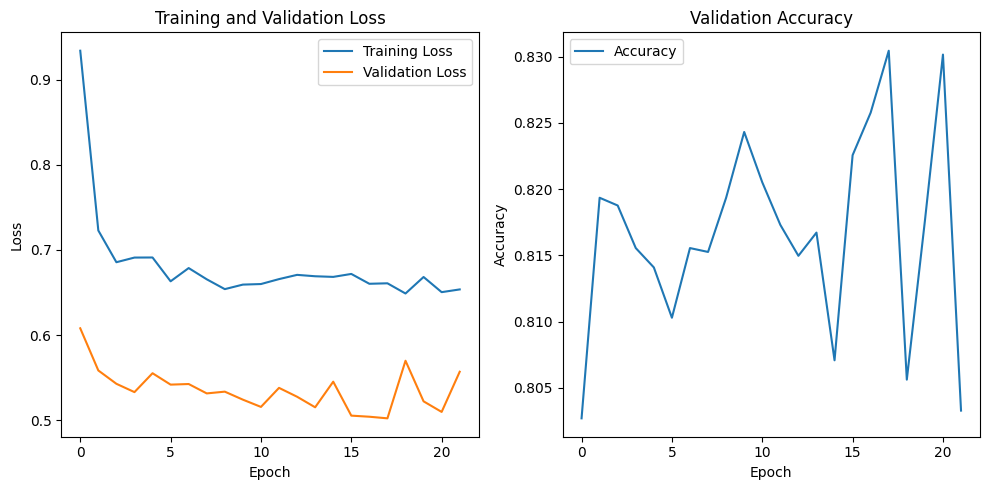

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-107/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-108
Epoch 1/50, Train Loss: 1.4281, Test Loss: 1.3687, Accuracy: 0.7279
Epoch 2/50, Train Loss: 1.5927, Test Loss: 1.2038, Accuracy: 0.7530
Epoch 3/50, Train Loss: 1.6685, Test Loss: 1.1619, Accuracy: 0.7694
Epoch 4/50, Train Loss: 1.6650, Test Loss: 1.2577, Accuracy: 0.7606
Epoch 5/50, Train Loss: 1.7047, Test Loss: 1.4012, Accuracy: 0.7308
Epoch 6/50, Train Loss: 1.7923, Test Loss: 1.6237, Accuracy: 0.7524
Epoch 7/50, Train Loss: 1.7254, Test Loss: 1.1828, Accuracy: 0.7603
Epoch 8/

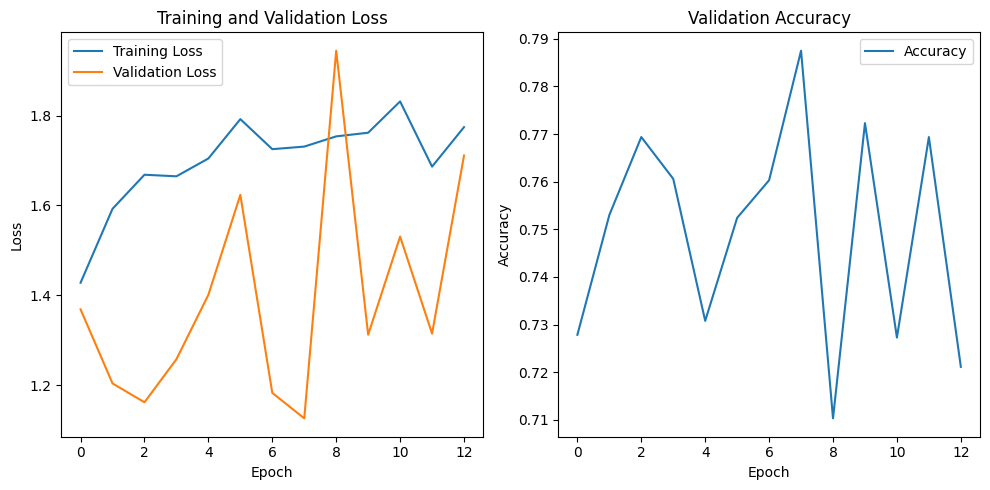

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-108/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-109
Epoch 1/50, Train Loss: 11.3139, Test Loss: 8.1238, Accuracy: 0.7287
Epoch 2/50, Train Loss: 12.3016, Test Loss: 9.7425, Accuracy: 0.6887
Epoch 3/50, Train Loss: 12.8633, Test Loss: 9.0159, Accuracy: 0.7246
Epoch 4/50, Train Loss: 12.7494, Test Loss: 8.8923, Accuracy: 0.7381
Epoch 5/50, Train Loss: 12.7028, Test Loss: 14.1026, Accuracy: 0.6799
Epoch 6/50, Train Loss: 13.0767, Test Loss: 11.7947, Accuracy: 0.6872
Epoch 7/50, Train Loss: 12.8460, Test Loss: 12.2242, Accuracy: 0.673

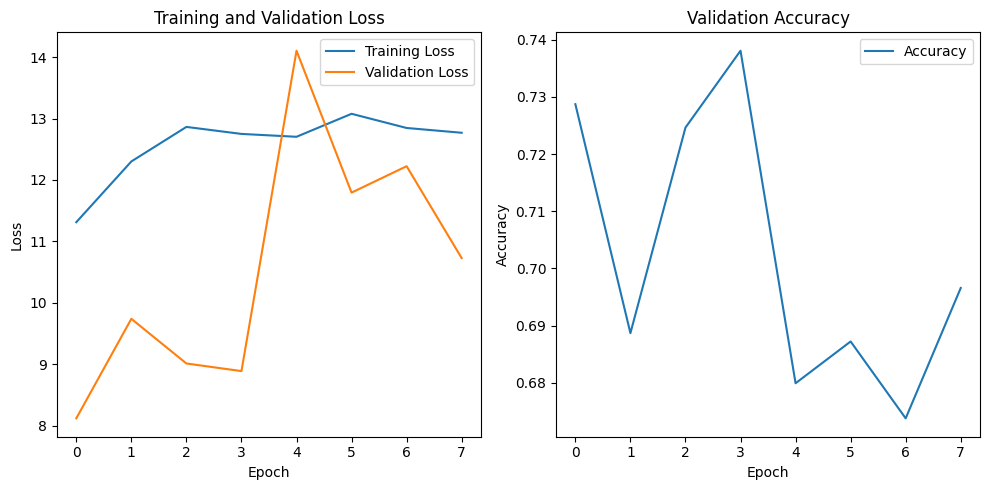

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-109/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-110
Epoch 1/50, Train Loss: 0.9570, Test Loss: 0.6505, Accuracy: 0.7980
Epoch 2/50, Train Loss: 0.6612, Test Loss: 0.5582, Accuracy: 0.8132
Epoch 3/50, Train Loss: 0.6186, Test Loss: 0.5416, Accuracy: 0.8220
Epoch 4/50, Train Loss: 0.5912, Test Loss: 0.5152, Accuracy: 0.8249
Epoch 5/50, Train Loss: 0.5856, Test Loss: 0.5205, Accuracy: 0.8185
Epoch 6/50, Train Loss: 0.5750, Test Loss: 0.5069, Accuracy: 0.8272
Epoch 7/50, Train Loss: 0.5645, Test Loss: 0.5068, Accuracy: 0.8284
Epoch 8/

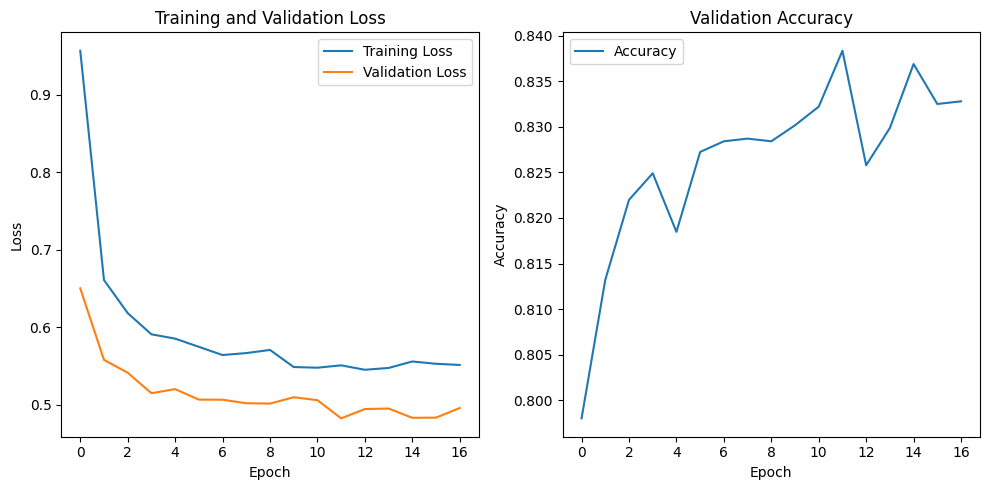

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-110/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-111
Epoch 1/50, Train Loss: 1.0888, Test Loss: 1.0101, Accuracy: 0.7460
Epoch 2/50, Train Loss: 1.0413, Test Loss: 0.7835, Accuracy: 0.7930
Epoch 3/50, Train Loss: 1.1064, Test Loss: 1.0012, Accuracy: 0.7711
Epoch 4/50, Train Loss: 1.1421, Test Loss: 0.8689, Accuracy: 0.7910
Epoch 5/50, Train Loss: 1.1679, Test Loss: 1.0349, Accuracy: 0.7834
Epoch 6/50, Train Loss: 1.1617, Test Loss: 0.8970, Accuracy: 0.8001
Epoch 7/50, Train Loss: 1.2080, Test Loss: 0.9511, Accuracy: 0.7939
Early st

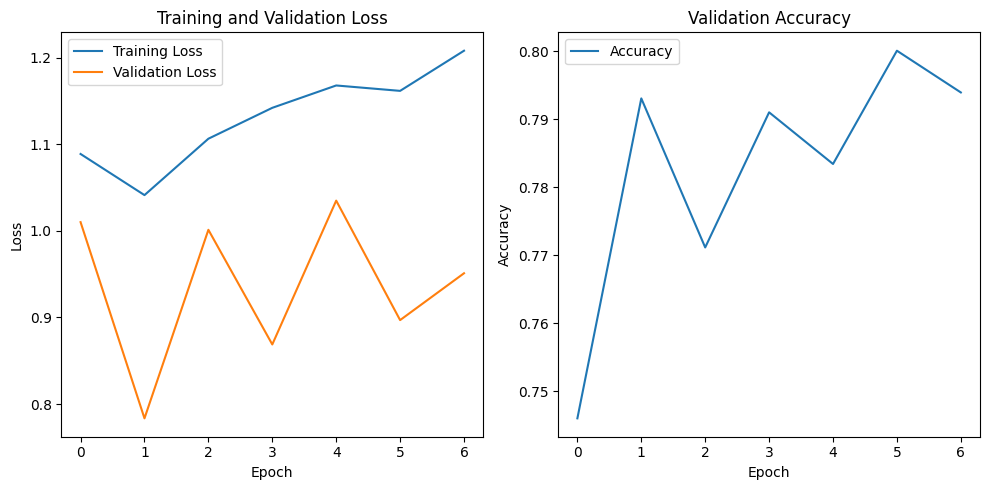

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-111/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-112
Epoch 1/50, Train Loss: 7.1206, Test Loss: 6.4795, Accuracy: 0.7100
Epoch 2/50, Train Loss: 7.9176, Test Loss: 6.6519, Accuracy: 0.7477
Epoch 3/50, Train Loss: 8.6886, Test Loss: 7.2255, Accuracy: 0.7238
Epoch 4/50, Train Loss: 9.0487, Test Loss: 8.1885, Accuracy: 0.7208
Epoch 5/50, Train Loss: 8.7619, Test Loss: 6.8245, Accuracy: 0.7393
Epoch 6/50, Train Loss: 8.0961, Test Loss: 7.3176, Accuracy: 0.7322
Early stopping at epoch 6


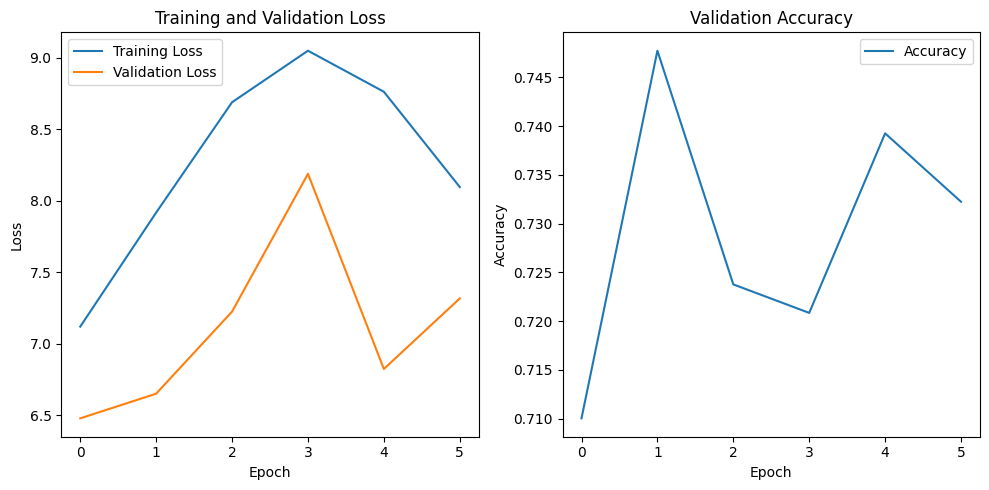

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-112/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-113
Epoch 1/50, Train Loss: 1.0429, Test Loss: 0.7059, Accuracy: 0.7913
Epoch 2/50, Train Loss: 0.6732, Test Loss: 0.5981, Accuracy: 0.8118
Epoch 3/50, Train Loss: 0.6036, Test Loss: 0.5598, Accuracy: 0.8115
Epoch 4/50, Train Loss: 0.5719, Test Loss: 0.5257, Accuracy: 0.8237
Epoch 5/50, Train Loss: 0.5494, Test Loss: 0.5477, Accuracy: 0.8126
Epoch 6/50, Train Loss: 0.5354, Test Loss: 0.5014, Accuracy: 0.8310
Epoch 7/50, Train Loss: 0.5178, Test Loss: 0.4988, Accuracy: 0.8331
Epoch 8/

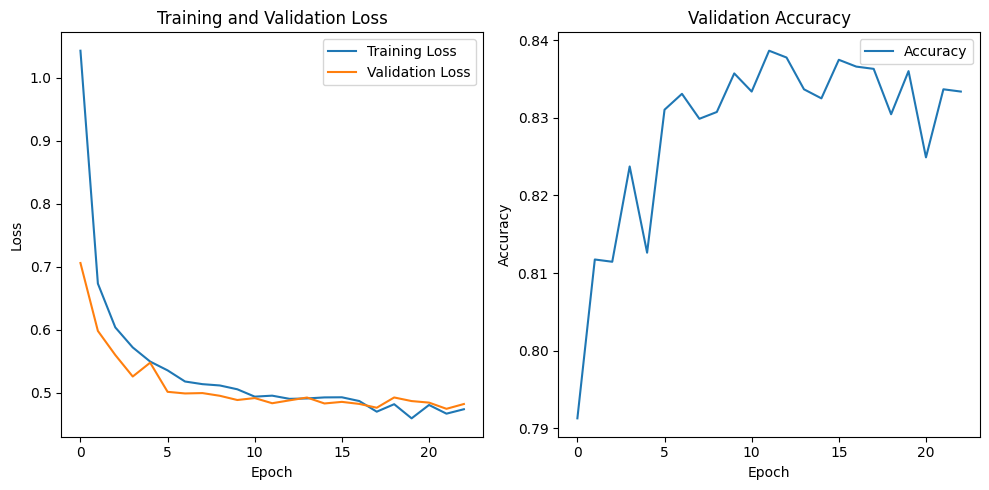

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-113/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-114
Epoch 1/50, Train Loss: 0.8842, Test Loss: 0.6506, Accuracy: 0.7887
Epoch 2/50, Train Loss: 0.7573, Test Loss: 0.7531, Accuracy: 0.7878
Epoch 3/50, Train Loss: 0.7914, Test Loss: 0.7379, Accuracy: 0.7872
Epoch 4/50, Train Loss: 0.8312, Test Loss: 0.7633, Accuracy: 0.7939
Epoch 5/50, Train Loss: 0.8628, Test Loss: 0.8602, Accuracy: 0.7831
Epoch 6/50, Train Loss: 0.8417, Test Loss: 0.6874, Accuracy: 0.8106
Early stopping at epoch 6


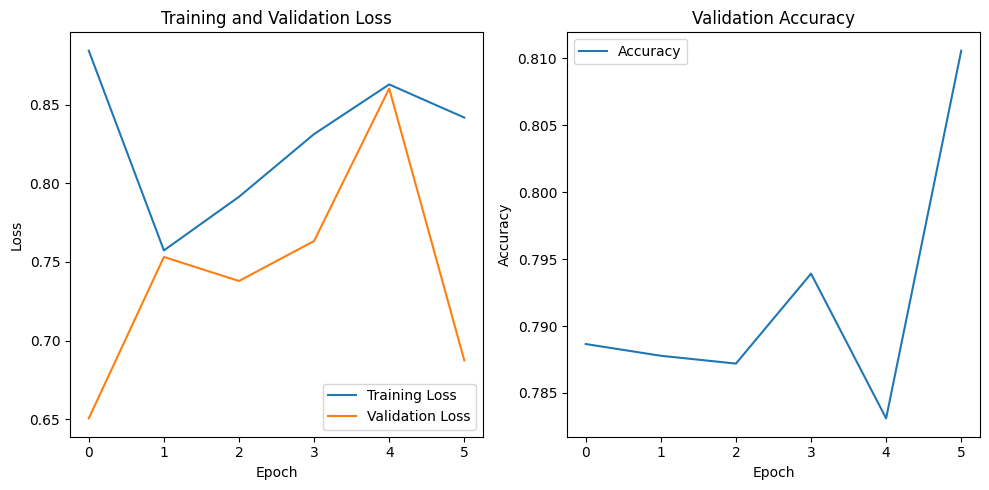

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-114/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-115
Epoch 1/50, Train Loss: 4.9993, Test Loss: 3.0819, Accuracy: 0.7580
Epoch 2/50, Train Loss: 4.5454, Test Loss: 4.1817, Accuracy: 0.7591
Epoch 3/50, Train Loss: 4.8416, Test Loss: 3.8298, Accuracy: 0.7714
Epoch 4/50, Train Loss: 5.3755, Test Loss: 4.3601, Accuracy: 0.7808
Epoch 5/50, Train Loss: 5.3524, Test Loss: 6.0850, Accuracy: 0.7442
Epoch 6/50, Train Loss: 5.3014, Test Loss: 5.4124, Accuracy: 0.7562
Early stopping at epoch 6


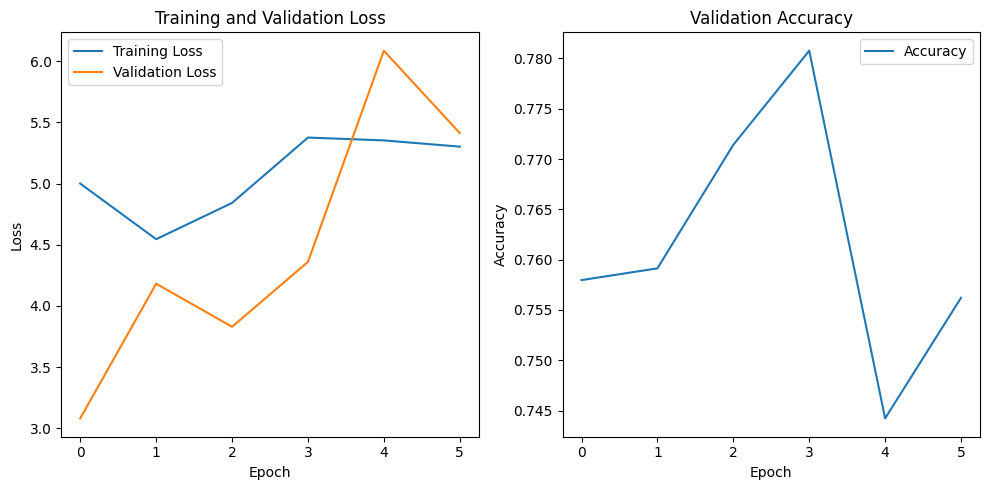

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-115/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-116
Epoch 1/50, Train Loss: 0.7237, Test Loss: 0.7051, Accuracy: 0.8369
Epoch 2/50, Train Loss: 0.5596, Test Loss: 0.6302, Accuracy: 0.8454
Epoch 3/50, Train Loss: 0.5125, Test Loss: 0.9014, Accuracy: 0.8299
Epoch 4/50, Train Loss: 0.5163, Test Loss: 0.8480, Accuracy: 0.8205
Epoch 5/50, Train Loss: 0.4995, Test Loss: 0.6181, Accuracy: 0.8521
Epoch 6/50, Train Loss: 0.4715, Test Loss: 0.6185, Accuracy: 0.8454
Epoch 7/50, Train Loss: 0.4927, Test Loss: 0.7718, Accuracy: 0.8527
Epoch 8/

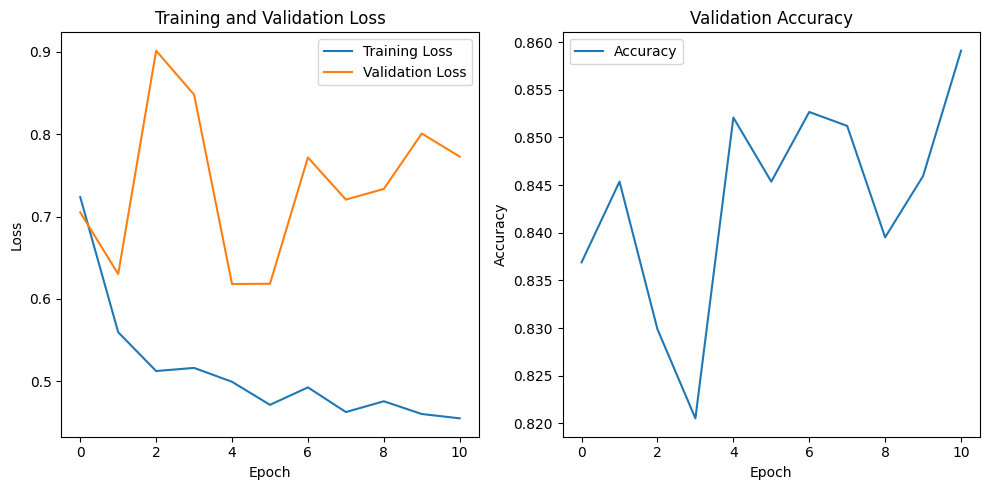

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-116/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-117
Epoch 1/50, Train Loss: 1.9243, Test Loss: 2.3281, Accuracy: 0.7767
Epoch 2/50, Train Loss: 2.0594, Test Loss: 2.3852, Accuracy: 0.8021
Epoch 3/50, Train Loss: 2.1043, Test Loss: 3.2179, Accuracy: 0.7860
Epoch 4/50, Train Loss: 2.0946, Test Loss: 2.3479, Accuracy: 0.8182
Epoch 5/50, Train Loss: 2.0469, Test Loss: 2.8162, Accuracy: 0.8062
Epoch 6/50, Train Loss: 2.1837, Test Loss: 3.1091, Accuracy: 0.8191
Epoch 7/50, Train Loss: 2.1572, Test Loss: 2.6007, Accuracy: 0.8351
Epoch 8/

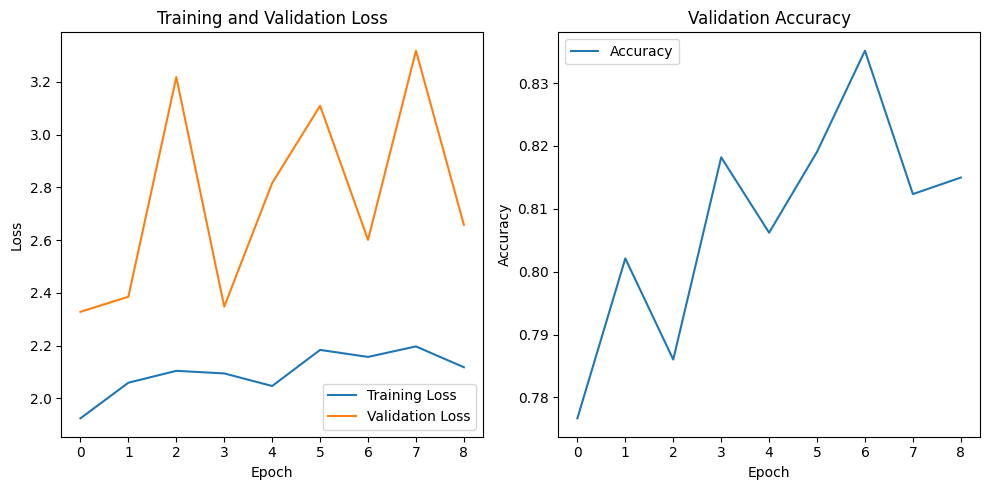

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-117/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-118
Epoch 1/50, Train Loss: 16.9538, Test Loss: 31.6887, Accuracy: 0.6668
Epoch 2/50, Train Loss: 19.3151, Test Loss: 15.4520, Accuracy: 0.8188
Epoch 3/50, Train Loss: 17.8815, Test Loss: 24.2379, Accuracy: 0.7352
Epoch 4/50, Train Loss: 19.1500, Test Loss: 23.5102, Accuracy: 0.7413
Epoch 5/50, Train Loss: 19.2248, Test Loss: 18.1601, Accuracy: 0.7895
Epoch 6/50, Train Loss: 21.3843, Test Loss: 27.7259, Accuracy: 0.6934
Epoch 7/50, Train Loss: 18.8248, Test Loss: 24.4119, Accuracy: 0

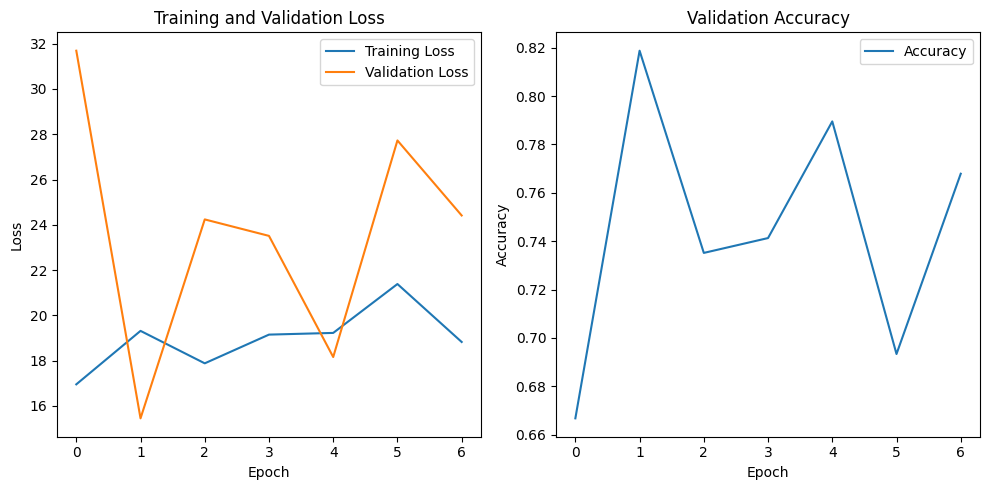

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-118/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-119
Epoch 1/50, Train Loss: 0.7047, Test Loss: 0.5561, Accuracy: 0.8389
Epoch 2/50, Train Loss: 0.4672, Test Loss: 0.4987, Accuracy: 0.8568
Epoch 3/50, Train Loss: 0.4301, Test Loss: 0.4535, Accuracy: 0.8696
Epoch 4/50, Train Loss: 0.4140, Test Loss: 0.4858, Accuracy: 0.8652
Epoch 5/50, Train Loss: 0.3805, Test Loss: 0.4031, Accuracy: 0.8755
Epoch 6/50, Train Loss: 0.3777, Test Loss: 0.3918, Accuracy: 0.8766
Epoch 7/50, Train Loss: 0.3747, Test Loss: 0.4474, Accuracy: 0.8708
Epoch 8/

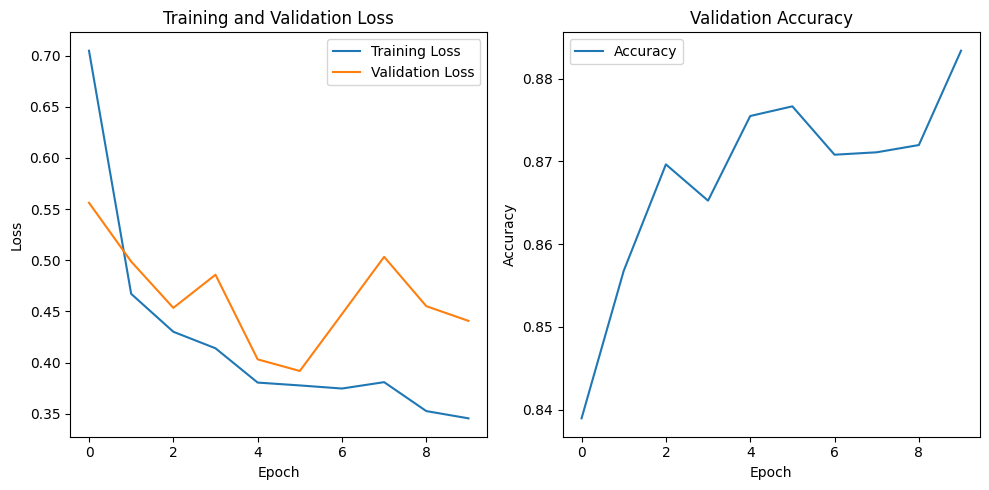

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-119/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-120
Epoch 1/50, Train Loss: 1.2411, Test Loss: 1.1461, Accuracy: 0.8211
Epoch 2/50, Train Loss: 1.1652, Test Loss: 1.2078, Accuracy: 0.8226
Epoch 3/50, Train Loss: 1.2083, Test Loss: 1.3603, Accuracy: 0.8220
Epoch 4/50, Train Loss: 1.3109, Test Loss: 1.3203, Accuracy: 0.8343
Epoch 5/50, Train Loss: 1.1448, Test Loss: 1.3157, Accuracy: 0.8354
Epoch 6/50, Train Loss: 1.1706, Test Loss: 1.9901, Accuracy: 0.8302
Early stopping at epoch 6


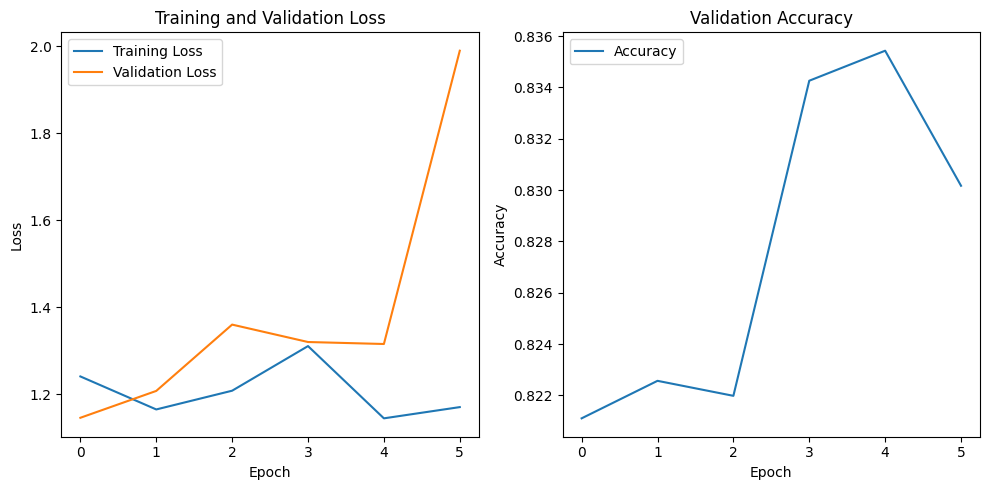

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-120/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-121
Epoch 1/50, Train Loss: 10.8805, Test Loss: 10.6104, Accuracy: 0.7819
Epoch 2/50, Train Loss: 10.4916, Test Loss: 9.2286, Accuracy: 0.8173
Epoch 3/50, Train Loss: 11.1290, Test Loss: 11.6234, Accuracy: 0.8077
Epoch 4/50, Train Loss: 11.5375, Test Loss: 18.9918, Accuracy: 0.7533
Epoch 5/50, Train Loss: 12.8098, Test Loss: 9.7665, Accuracy: 0.8369
Epoch 6/50, Train Loss: 11.9496, Test Loss: 14.6506, Accuracy: 0.7892
Epoch 7/50, Train Loss: 12.5466, Test Loss: 11.9783, Accuracy: 0.8

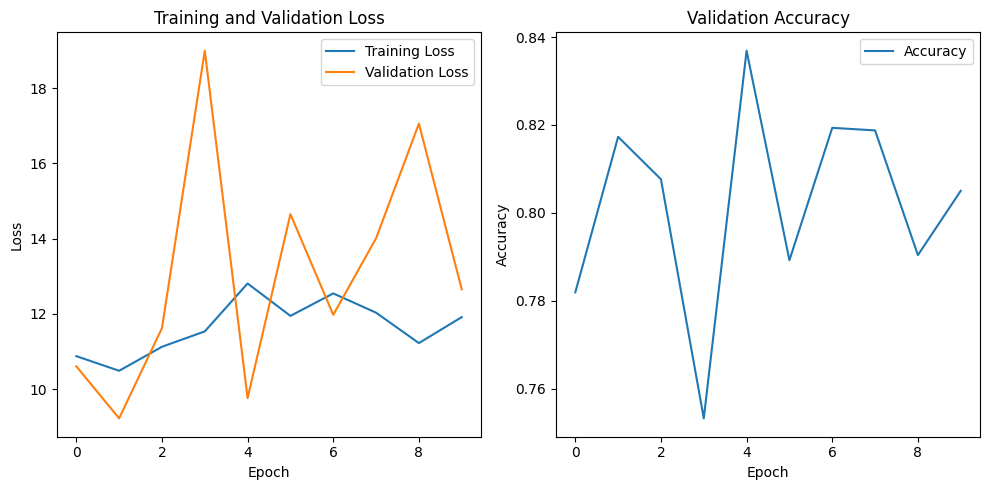

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-121/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-122
Epoch 1/50, Train Loss: 0.7149, Test Loss: 0.5492, Accuracy: 0.8495
Epoch 2/50, Train Loss: 0.4453, Test Loss: 0.4302, Accuracy: 0.8679
Epoch 3/50, Train Loss: 0.3912, Test Loss: 0.4213, Accuracy: 0.8764
Epoch 4/50, Train Loss: 0.3602, Test Loss: 0.3809, Accuracy: 0.8804
Epoch 5/50, Train Loss: 0.3392, Test Loss: 0.4003, Accuracy: 0.8778
Epoch 6/50, Train Loss: 0.3323, Test Loss: 0.3919, Accuracy: 0.8840
Epoch 7/50, Train Loss: 0.3103, Test Loss: 0.3857, Accuracy: 0.8857
Epoch 8/

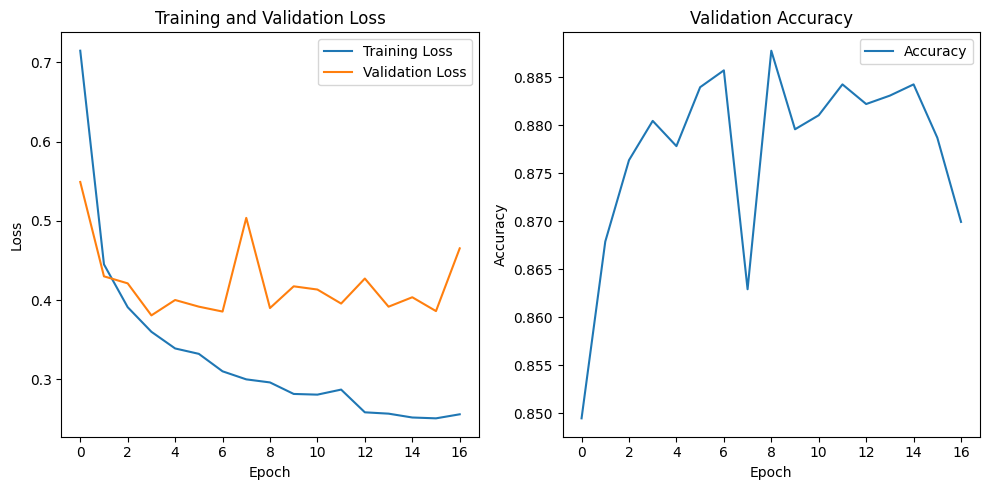

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-122/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-123
Epoch 1/50, Train Loss: 0.9635, Test Loss: 0.8289, Accuracy: 0.8115
Epoch 2/50, Train Loss: 0.6713, Test Loss: 0.8756, Accuracy: 0.8141
Epoch 3/50, Train Loss: 0.6580, Test Loss: 0.9672, Accuracy: 0.8115
Epoch 4/50, Train Loss: 0.6540, Test Loss: 0.9672, Accuracy: 0.8308
Epoch 5/50, Train Loss: 0.6425, Test Loss: 1.0491, Accuracy: 0.8310
Epoch 6/50, Train Loss: 0.6341, Test Loss: 1.1186, Accuracy: 0.8161
Early stopping at epoch 6


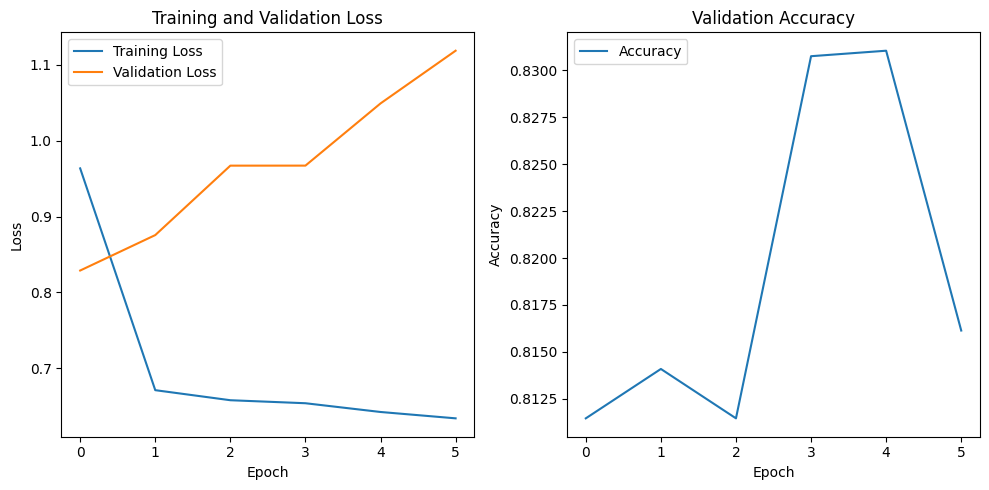

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-123/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-124
Epoch 1/50, Train Loss: 8.9350, Test Loss: 4.5134, Accuracy: 0.8085
Epoch 2/50, Train Loss: 5.5869, Test Loss: 5.4172, Accuracy: 0.8217
Epoch 3/50, Train Loss: 5.4927, Test Loss: 5.6693, Accuracy: 0.8343
Epoch 4/50, Train Loss: 6.3874, Test Loss: 11.0858, Accuracy: 0.7606
Epoch 5/50, Train Loss: 6.2520, Test Loss: 10.0803, Accuracy: 0.7667
Epoch 6/50, Train Loss: 6.4491, Test Loss: 6.6271, Accuracy: 0.8302
Early stopping at epoch 6


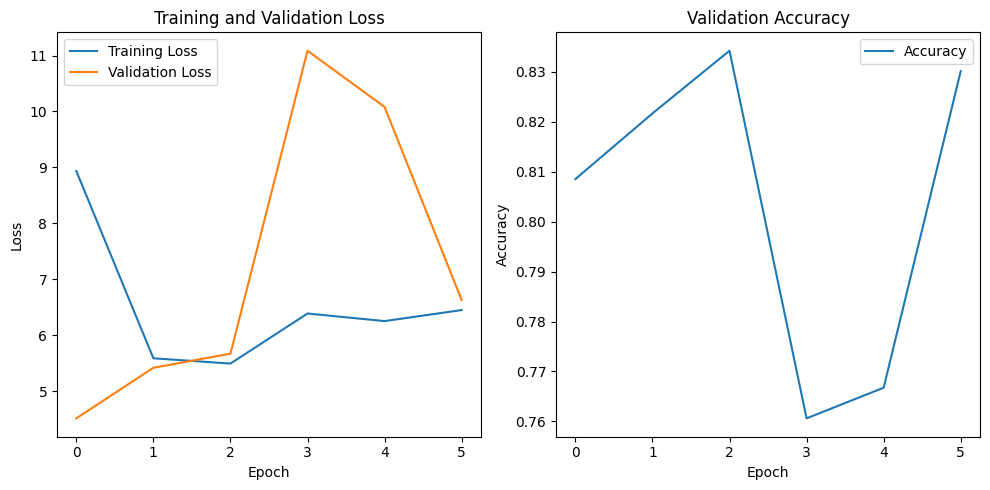

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-124/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-125
Epoch 1/50, Train Loss: 0.8670, Test Loss: 0.6847, Accuracy: 0.7837
Epoch 2/50, Train Loss: 0.6783, Test Loss: 0.7041, Accuracy: 0.7796
Epoch 3/50, Train Loss: 0.6567, Test Loss: 0.6607, Accuracy: 0.7968
Epoch 4/50, Train Loss: 0.6521, Test Loss: 0.6537, Accuracy: 0.7884
Epoch 5/50, Train Loss: 0.6121, Test Loss: 0.6640, Accuracy: 0.7983
Epoch 6/50, Train Loss: 0.6228, Test Loss: 0.6470, Accuracy: 0.8062
Epoch 7/50, Train Loss: 0.6085, Test Loss: 0.6723, Accuracy: 0.7945
Epoch 8/

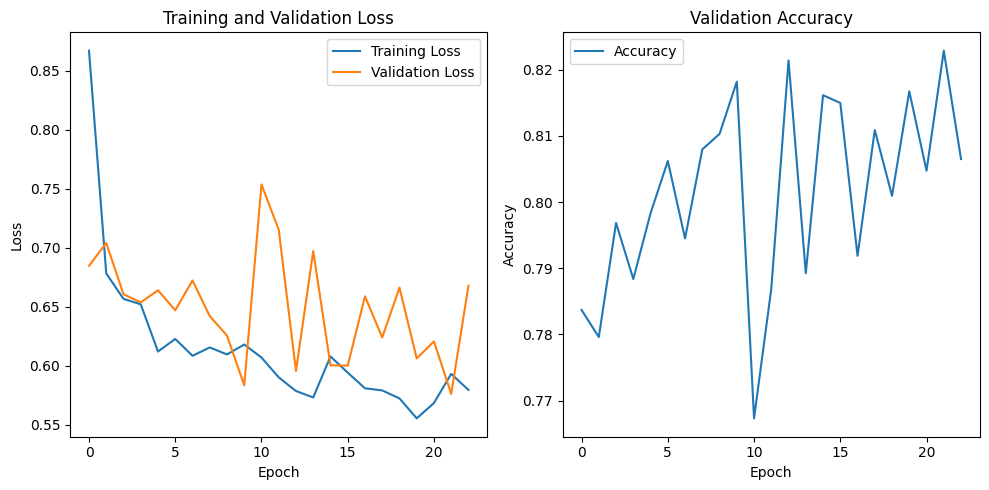

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-125/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-126
Epoch 1/50, Train Loss: 2.0484, Test Loss: 2.0248, Accuracy: 0.7261
Epoch 2/50, Train Loss: 2.2206, Test Loss: 2.4295, Accuracy: 0.7243
Epoch 3/50, Train Loss: 2.3041, Test Loss: 2.4463, Accuracy: 0.7299
Epoch 4/50, Train Loss: 2.4309, Test Loss: 2.7135, Accuracy: 0.7270
Epoch 5/50, Train Loss: 2.3971, Test Loss: 2.2476, Accuracy: 0.7650
Epoch 6/50, Train Loss: 2.4137, Test Loss: 3.3170, Accuracy: 0.6954
Early stopping at epoch 6


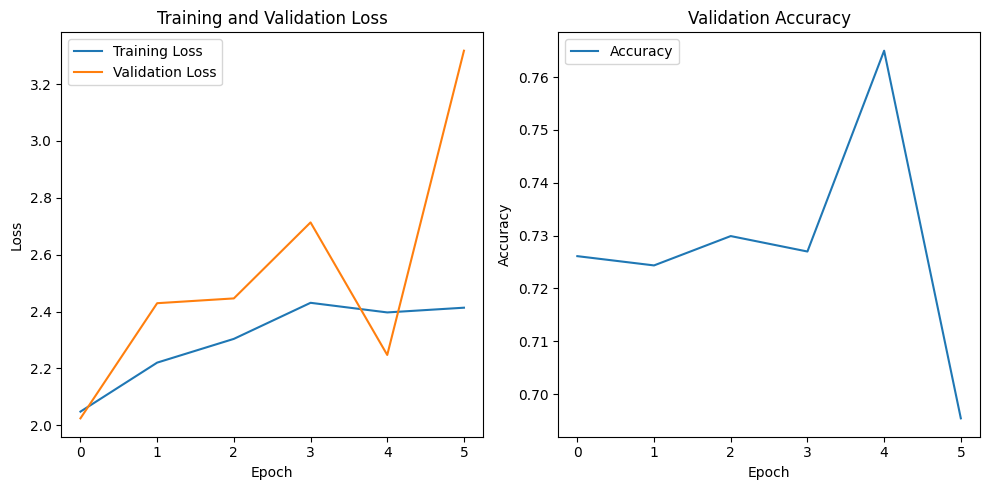

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-126/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-127
Epoch 1/50, Train Loss: 17.8273, Test Loss: 22.0658, Accuracy: 0.6641
Epoch 2/50, Train Loss: 19.9556, Test Loss: 34.4406, Accuracy: 0.6136
Epoch 3/50, Train Loss: 21.4108, Test Loss: 24.3837, Accuracy: 0.6457
Epoch 4/50, Train Loss: 20.6820, Test Loss: 32.4399, Accuracy: 0.5817
Epoch 5/50, Train Loss: 20.8506, Test Loss: 19.4770, Accuracy: 0.6977
Epoch 6/50, Train Loss: 20.3047, Test Loss: 23.4407, Accuracy: 0.6779
Epoch 7/50, Train Loss: 20.9152, Test Loss: 19.9113, Accuracy: 0

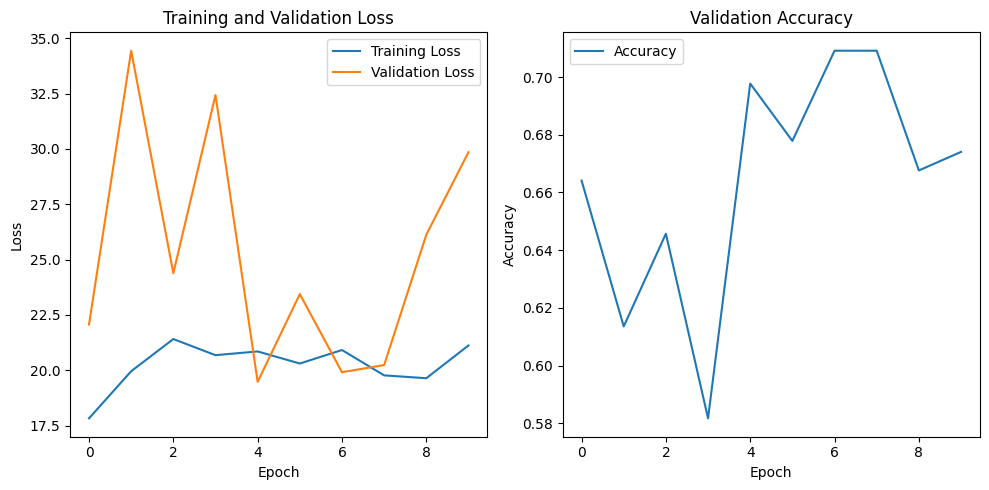

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-127/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-128
Epoch 1/50, Train Loss: 0.8572, Test Loss: 0.6636, Accuracy: 0.7846
Epoch 2/50, Train Loss: 0.6179, Test Loss: 0.5987, Accuracy: 0.8050
Epoch 3/50, Train Loss: 0.5721, Test Loss: 0.5971, Accuracy: 0.8044
Epoch 4/50, Train Loss: 0.5471, Test Loss: 0.5670, Accuracy: 0.8199
Epoch 5/50, Train Loss: 0.5253, Test Loss: 0.5442, Accuracy: 0.8205
Epoch 6/50, Train Loss: 0.5298, Test Loss: 0.5434, Accuracy: 0.8278
Epoch 7/50, Train Loss: 0.4964, Test Loss: 0.5606, Accuracy: 0.8164
Epoch 8/

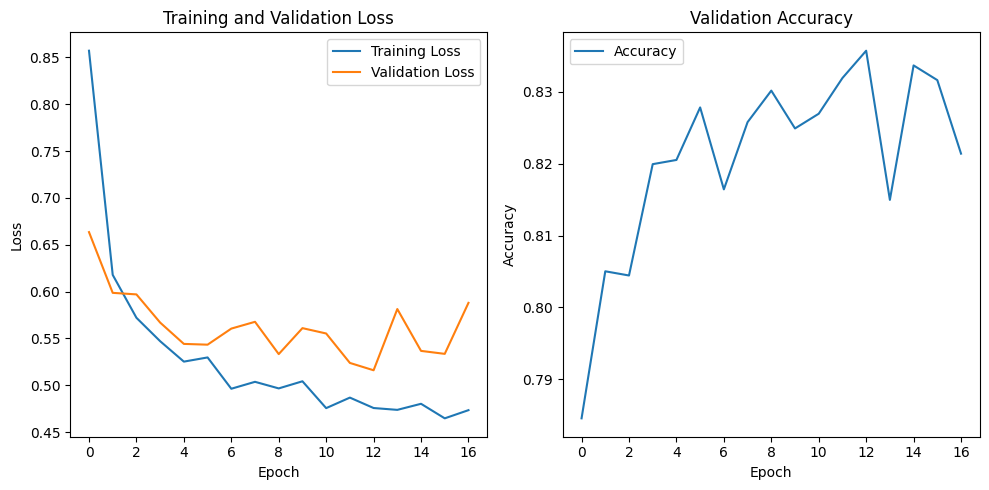

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-128/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-129
Epoch 1/50, Train Loss: 1.4263, Test Loss: 1.6770, Accuracy: 0.7238
Epoch 2/50, Train Loss: 1.4608, Test Loss: 1.4421, Accuracy: 0.7705
Epoch 3/50, Train Loss: 1.4044, Test Loss: 1.5993, Accuracy: 0.7615
Epoch 4/50, Train Loss: 1.4302, Test Loss: 1.8074, Accuracy: 0.7436
Epoch 5/50, Train Loss: 1.4800, Test Loss: 1.4887, Accuracy: 0.7980
Epoch 6/50, Train Loss: 1.5202, Test Loss: 1.9142, Accuracy: 0.7545
Epoch 7/50, Train Loss: 1.4932, Test Loss: 1.6490, Accuracy: 0.7749
Epoch 8/

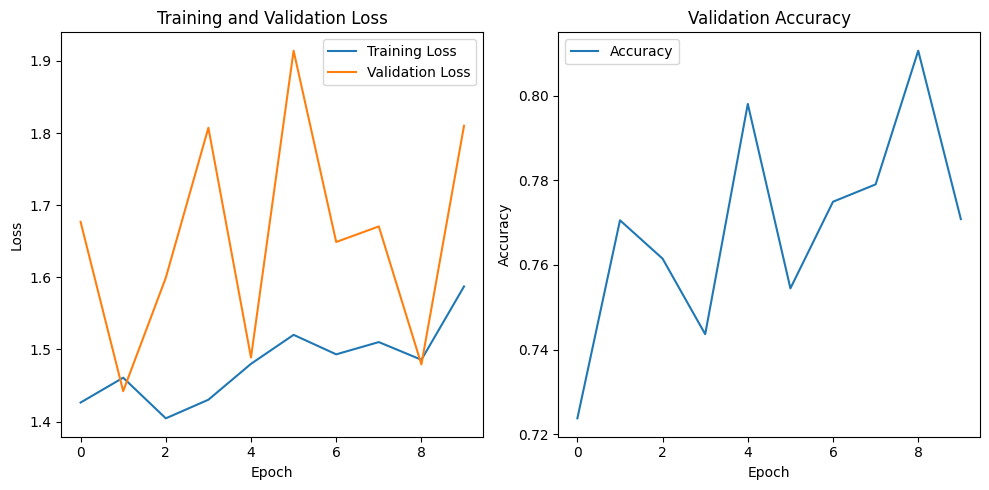

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-129/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-130
Epoch 1/50, Train Loss: 12.6138, Test Loss: 12.6888, Accuracy: 0.7118
Epoch 2/50, Train Loss: 13.4481, Test Loss: 16.9111, Accuracy: 0.7091
Epoch 3/50, Train Loss: 13.4984, Test Loss: 14.6644, Accuracy: 0.7281
Epoch 4/50, Train Loss: 12.3770, Test Loss: 12.1762, Accuracy: 0.7553
Epoch 5/50, Train Loss: 13.0733, Test Loss: 11.9623, Accuracy: 0.7609
Epoch 6/50, Train Loss: 13.6985, Test Loss: 13.9921, Accuracy: 0.7469
Epoch 7/50, Train Loss: 13.6139, Test Loss: 15.1523, Accuracy: 0

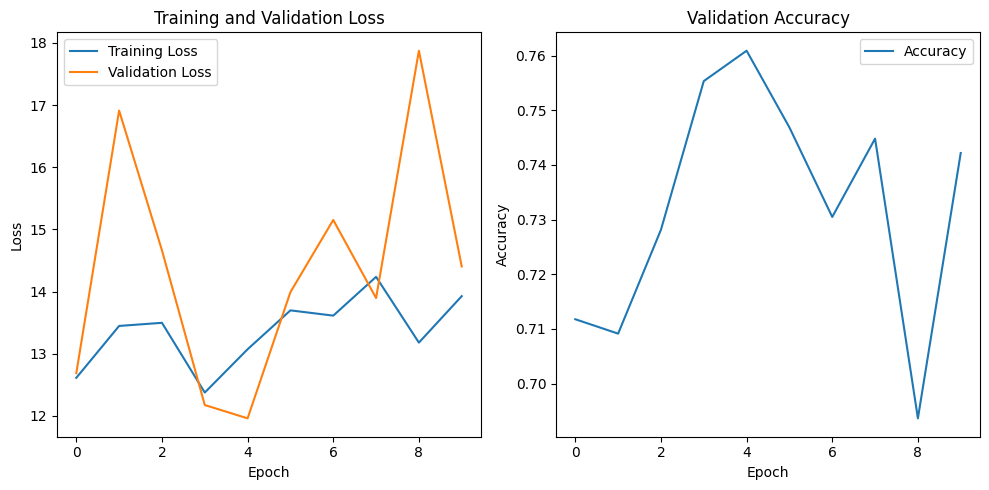

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-130/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-131
Epoch 1/50, Train Loss: 0.8929, Test Loss: 0.6245, Accuracy: 0.8088
Epoch 2/50, Train Loss: 0.5916, Test Loss: 0.5762, Accuracy: 0.8170
Epoch 3/50, Train Loss: 0.5405, Test Loss: 0.5628, Accuracy: 0.8226
Epoch 4/50, Train Loss: 0.5054, Test Loss: 0.5413, Accuracy: 0.8188
Epoch 5/50, Train Loss: 0.4907, Test Loss: 0.5117, Accuracy: 0.8322
Epoch 6/50, Train Loss: 0.4533, Test Loss: 0.5155, Accuracy: 0.8378
Epoch 7/50, Train Loss: 0.4521, Test Loss: 0.5041, Accuracy: 0.8398
Epoch 8/

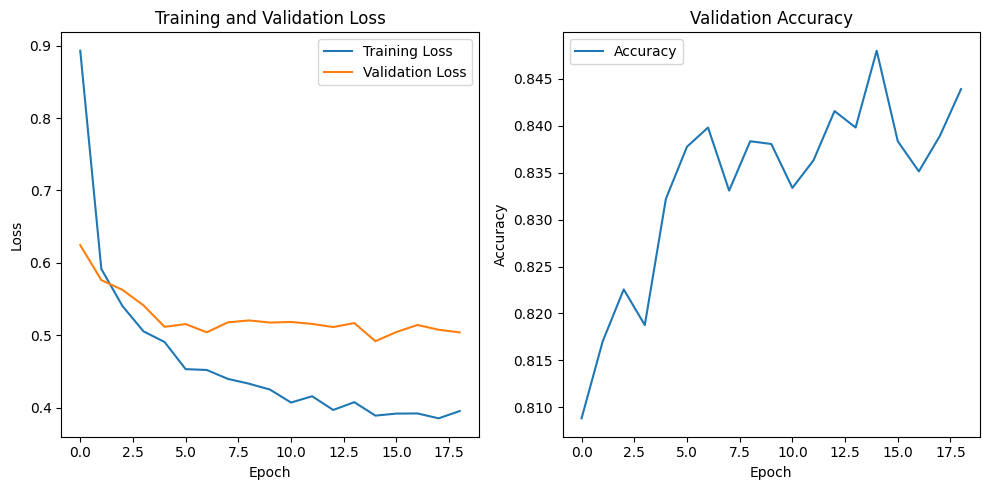

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-131/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-132
Epoch 1/50, Train Loss: 1.1133, Test Loss: 0.9216, Accuracy: 0.7746
Epoch 2/50, Train Loss: 0.9508, Test Loss: 0.9387, Accuracy: 0.7752
Epoch 3/50, Train Loss: 0.9035, Test Loss: 1.0613, Accuracy: 0.7749
Epoch 4/50, Train Loss: 0.9303, Test Loss: 1.0540, Accuracy: 0.8001
Epoch 5/50, Train Loss: 0.8643, Test Loss: 1.1077, Accuracy: 0.7910
Epoch 6/50, Train Loss: 0.9669, Test Loss: 1.3396, Accuracy: 0.7659
Epoch 7/50, Train Loss: 0.9665, Test Loss: 1.2222, Accuracy: 0.7793
Early st

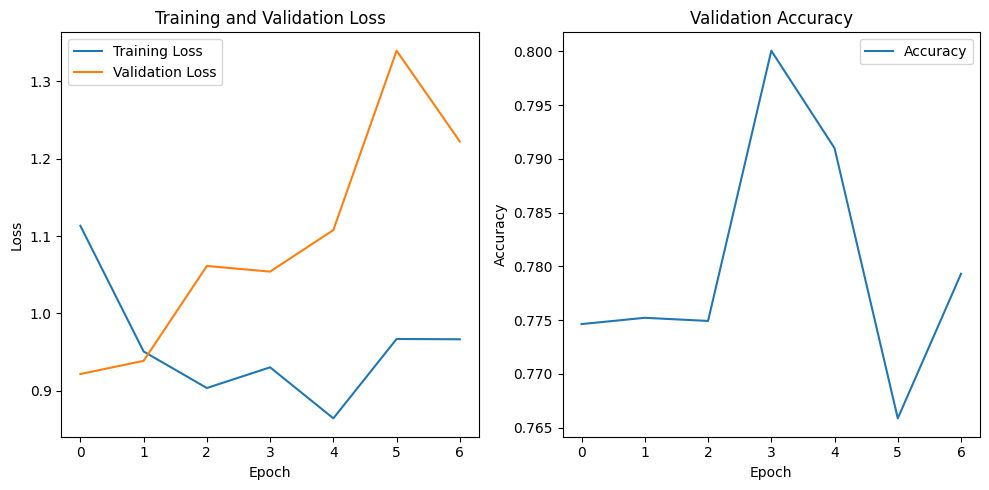

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-132/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-133
Epoch 1/50, Train Loss: 9.5330, Test Loss: 6.8683, Accuracy: 0.7062
Epoch 2/50, Train Loss: 7.0875, Test Loss: 10.4869, Accuracy: 0.6992
Epoch 3/50, Train Loss: 8.2512, Test Loss: 7.9208, Accuracy: 0.7533
Epoch 4/50, Train Loss: 8.3991, Test Loss: 10.8807, Accuracy: 0.7486
Epoch 5/50, Train Loss: 7.9281, Test Loss: 8.7205, Accuracy: 0.7597
Epoch 6/50, Train Loss: 7.9673, Test Loss: 10.2832, Accuracy: 0.7638
Early stopping at epoch 6


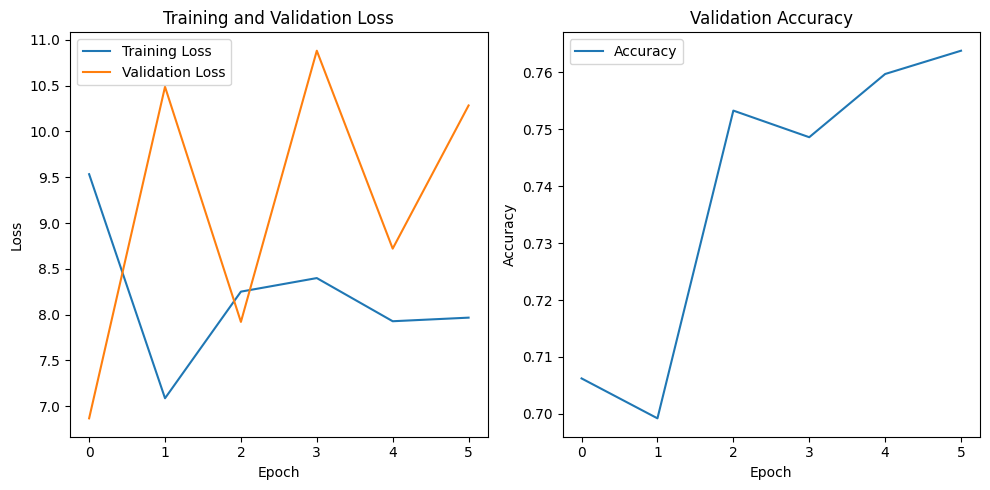

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-133/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-134


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.inception.Inception3'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type


RuntimeError: Given input size: (768x2x2). Calculated output size: (768x0x0). Output size is too small

In [ ]:
# Various Hyperparameters execution
for model_name in models_pretrained:
  for batch_size in batch_sizes:
    for learning_rate in learning_rates:
      # start neptune run
      # parameters structured as dict to pass them to neptune
      params = {
        "pre-trained model_name": model_name,
        "epochs": epochs,
        "batch_size": batch_size,
        "data_flag": data_flag,
        "architecture": "CNN",
        "optimizer": "AdamW",
        "metrics": ["accuracy", "loss"],
        "activation": "relu",
        "learning_rate":learning_rate,
        "device": device,
        "patience": patience,
        "best_loss": best_loss,
        "epochs_without_improvement": epochs_without_improvement,
        "data_augmentation": False
      }
      tags = [f"{return_variable_name(model_name)}","without_data_augmentation"]
      name = f"{return_variable_name(model_name)}-no_data_augmentation-bs{str(batch_size)}-lr{str(learning_rate)}"
      run = init_neptune(params,name,tags)

      # Initiate instance of pre-trained model, modification of final fully connected layer
      # Freeze all the weights
      for param in model_name.parameters():
        param.requires_grad = False

      # assign proper number of classes
      num_ftrs = model_name.fc.in_features
      model_name.fc = nn.Linear(num_ftrs, n_classes)

      # Ensure the classifier's weights are trainable
      for param in model_name.fc.parameters():
        param.requires_grad = True


      # Setup variables for training
      train_loader,test_loader,val_loader = data_loaders_preparation(train_dataset, val_dataset, test_dataset, batch_size)
      epochs = epochs
      learning_rate = learning_rate
      patience = patience
      best_loss = best_loss
      epochs_without_improvement = epochs_without_improvement
      data_augmentation=False

      # train model
      train_losses, test_losses, accuracies = train_and_test_model(model_name.to(device),train_loader,test_loader,val_loader,epochs,learning_rate,patience,best_loss,epochs_without_improvement,name,data_augmentation)

      # visualize results
      visualize_training_progress(train_losses, test_losses, accuracies)
      run["test/results"].upload("training_progress.png")

      # stop neptune run
      run.stop()

**10. Transfer learning - with data augmentation**
---




[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-135
Epoch 1/50, Train Loss: 0.9146, Test Loss: 1.0605, Accuracy: 0.6349
Epoch 2/50, Train Loss: 0.7216, Test Loss: 0.9322, Accuracy: 0.6682
Epoch 3/50, Train Loss: 0.6985, Test Loss: 0.9139, Accuracy: 0.6738
Epoch 4/50, Train Loss: 0.6887, Test Loss: 0.8764, Accuracy: 0.6901
Epoch 5/50, Train Loss: 0.6823, Test Loss: 0.9074, Accuracy: 0.6866
Epoch 6/50, Train Loss: 0.6860, Test Loss: 0.8832, Accuracy: 0.6945
Epoch 7/50, Train Loss: 0.6947, Test Loss: 0.8542, Accuracy: 0.6989
Epoch 8/50, Train Loss: 0.6690, Test Loss: 0.8307, Accuracy: 0.7074
Epoch 9/50, Train Loss: 0.6635, Test Loss: 0.8718, Accuracy: 0.6948
Epoch 10/50, Train Loss: 0.6755, Test Loss: 0.9131, Accuracy: 0.6837
Epoch 11/50, Train Loss: 0.6770, Test Loss: 0.9068, Accuracy: 0.6796
Epoch 12/50, Train Loss: 0.6668, Test Loss: 0.8939, Accuracy: 0.6805
Epoch 13/50, Train Loss: 0.6609, Test Loss: 0.8623, Accuracy: 0.6875


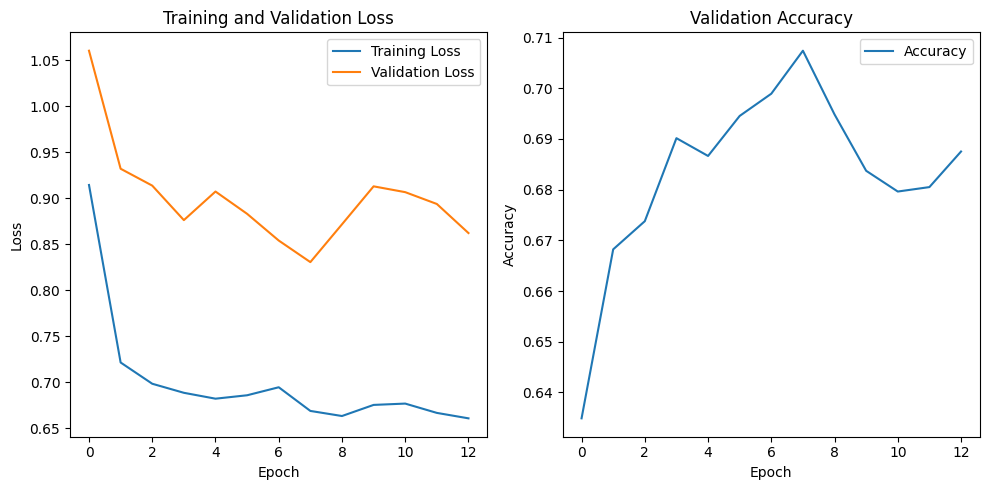

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-135/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-136
Epoch 1/50, Train Loss: 1.5489, Test Loss: 2.1300, Accuracy: 0.5668
Epoch 2/50, Train Loss: 1.6623, Test Loss: 1.9349, Accuracy: 0.5943
Epoch 3/50, Train Loss: 1.7679, Test Loss: 2.3160, Accuracy: 0.5759
Epoch 4/50, Train Loss: 1.7596, Test Loss: 1.7074, Accuracy: 0.6369
Epoch 5/50, Train Loss: 1.8115, Test Loss: 1.5101, Accuracy: 0.6530
Epoch 6/50, Train Loss: 1.7720, Test Loss: 2.4858, Accuracy: 0.5463
Epoch 7/50, Train Loss: 1.8493, Test Loss: 1.7053, Accuracy: 0.6469
Epoch 8/

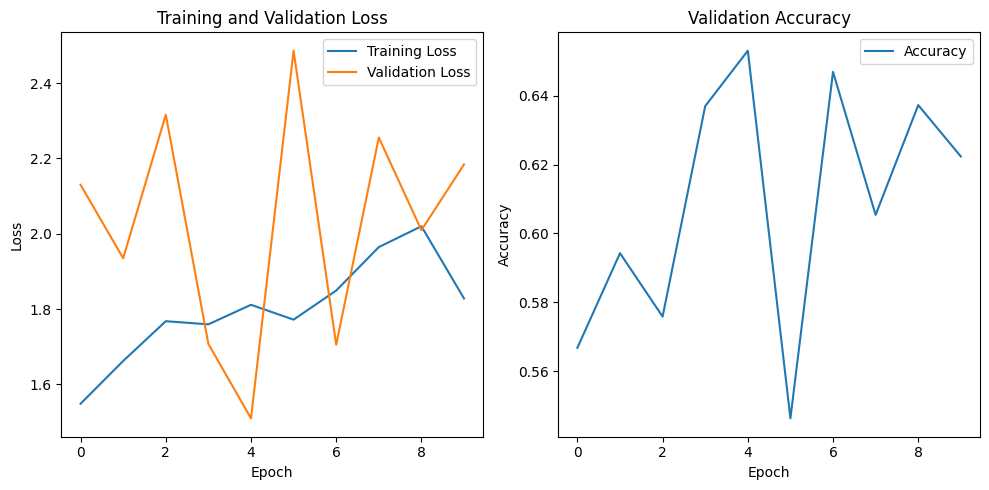

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-136/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-137
Epoch 1/50, Train Loss: 12.8689, Test Loss: 22.3031, Accuracy: 0.5039
Epoch 2/50, Train Loss: 13.8765, Test Loss: 19.2495, Accuracy: 0.5463
Epoch 3/50, Train Loss: 14.0720, Test Loss: 25.2378, Accuracy: 0.4519
Epoch 4/50, Train Loss: 14.9599, Test Loss: 13.0052, Accuracy: 0.6063
Epoch 5/50, Train Loss: 13.9873, Test Loss: 13.0731, Accuracy: 0.5922
Epoch 6/50, Train Loss: 14.8131, Test Loss: 13.8015, Accuracy: 0.5680
Epoch 7/50, Train Loss: 14.3109, Test Loss: 13.5454, Accuracy: 0

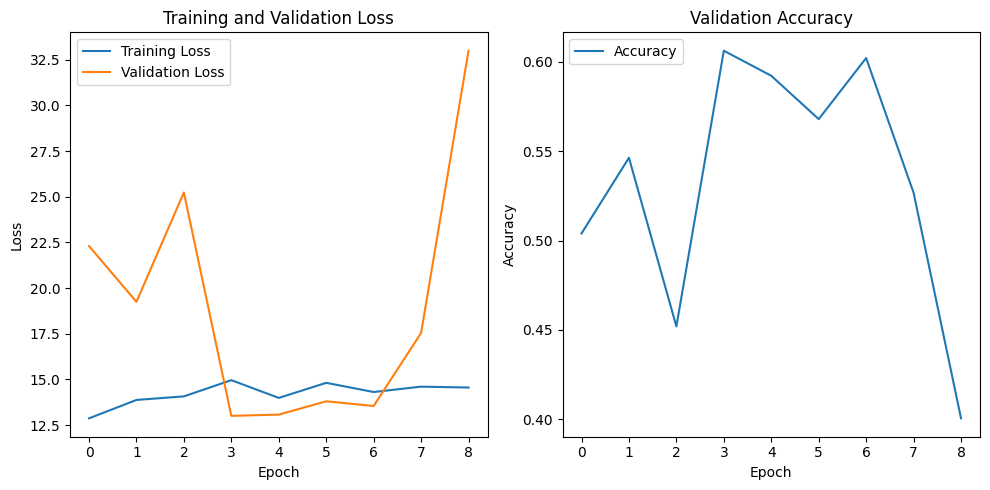

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-137/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-138
Epoch 1/50, Train Loss: 0.9211, Test Loss: 0.9440, Accuracy: 0.6878
Epoch 2/50, Train Loss: 0.6624, Test Loss: 0.9175, Accuracy: 0.6878
Epoch 3/50, Train Loss: 0.6289, Test Loss: 0.8176, Accuracy: 0.7281
Epoch 4/50, Train Loss: 0.6069, Test Loss: 0.8348, Accuracy: 0.7089
Epoch 5/50, Train Loss: 0.5891, Test Loss: 0.8466, Accuracy: 0.7018
Epoch 6/50, Train Loss: 0.5943, Test Loss: 0.8300, Accuracy: 0.7176
Epoch 7/50, Train Loss: 0.5913, Test Loss: 0.8303, Accuracy: 0.7091
Epoch 8/

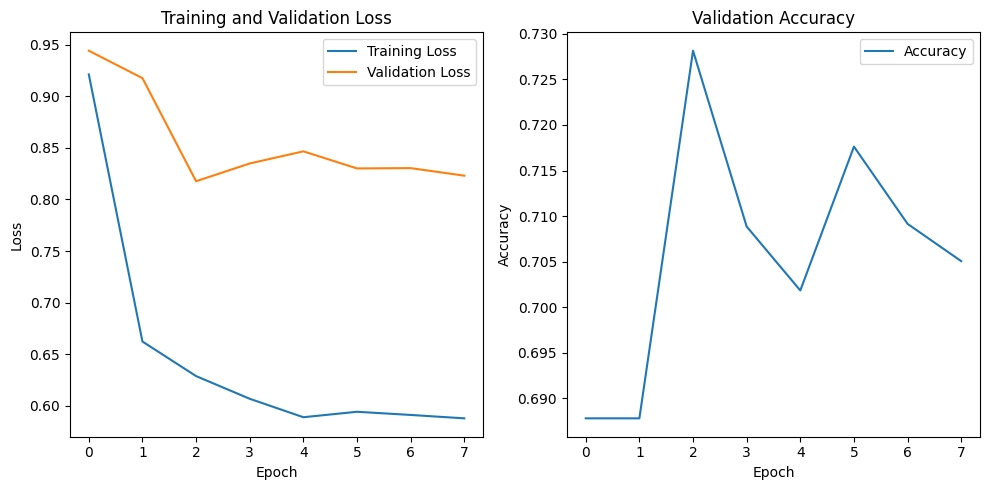

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-138/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-139
Epoch 1/50, Train Loss: 1.1223, Test Loss: 1.5535, Accuracy: 0.6229
Epoch 2/50, Train Loss: 1.1391, Test Loss: 1.3673, Accuracy: 0.6691
Epoch 3/50, Train Loss: 1.1684, Test Loss: 1.3193, Accuracy: 0.6662
Epoch 4/50, Train Loss: 1.1773, Test Loss: 1.6111, Accuracy: 0.6168
Epoch 5/50, Train Loss: 1.2040, Test Loss: 1.8384, Accuracy: 0.6007
Epoch 6/50, Train Loss: 1.2460, Test Loss: 1.3082, Accuracy: 0.6939
Epoch 7/50, Train Loss: 1.2582, Test Loss: 1.6440, Accuracy: 0.6545
Epoch 8/

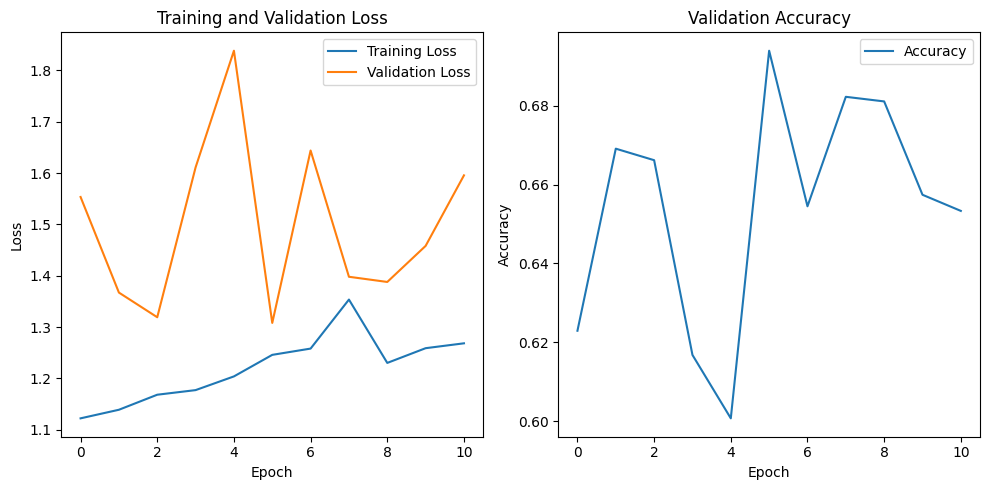

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-139/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-140
Epoch 1/50, Train Loss: 8.1127, Test Loss: 6.3877, Accuracy: 0.6253
Epoch 2/50, Train Loss: 8.2478, Test Loss: 10.2049, Accuracy: 0.6381
Epoch 3/50, Train Loss: 9.1662, Test Loss: 11.9359, Accuracy: 0.5808
Epoch 4/50, Train Loss: 9.8164, Test Loss: 8.4199, Accuracy: 0.6635
Epoch 5/50, Train Loss: 9.7197, Test Loss: 8.7599, Accuracy: 0.6147
Epoch 6/50, Train Loss: 9.4669, Test Loss: 11.5152, Accuracy: 0.6250
Early stopping at epoch 6


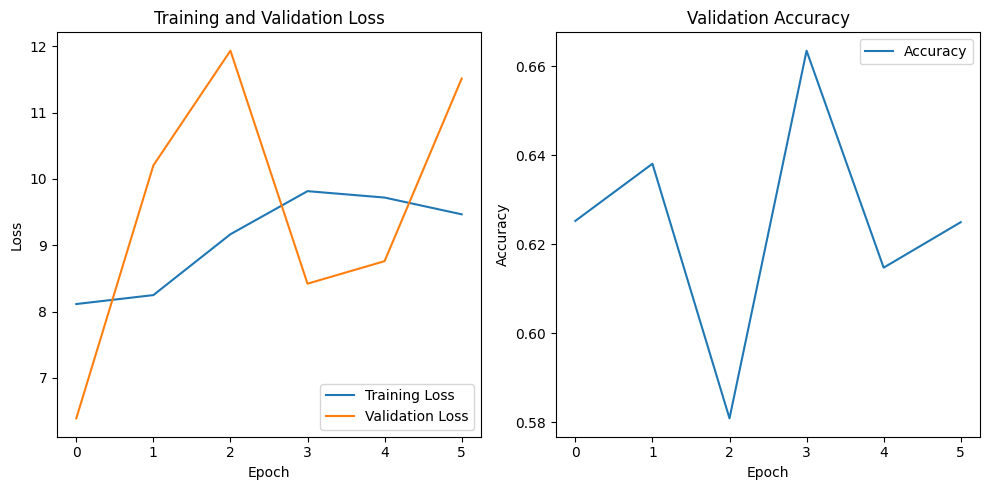

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-140/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-141
Epoch 1/50, Train Loss: 0.9715, Test Loss: 0.9957, Accuracy: 0.6828
Epoch 2/50, Train Loss: 0.6558, Test Loss: 0.8961, Accuracy: 0.6986
Epoch 3/50, Train Loss: 0.6060, Test Loss: 0.8843, Accuracy: 0.7001
Epoch 4/50, Train Loss: 0.5745, Test Loss: 0.9107, Accuracy: 0.6843
Epoch 5/50, Train Loss: 0.5704, Test Loss: 0.8585, Accuracy: 0.7036
Epoch 6/50, Train Loss: 0.5450, Test Loss: 0.8570, Accuracy: 0.6975
Epoch 7/50, Train Loss: 0.5557, Test Loss: 0.8255, Accuracy: 0.7129
Epoch 8/

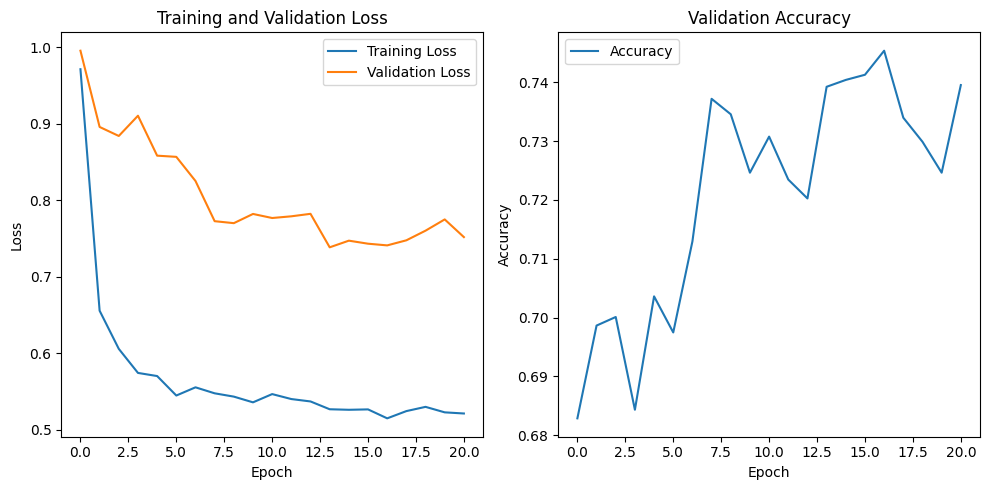

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-141/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-142
Epoch 1/50, Train Loss: 0.9268, Test Loss: 1.0245, Accuracy: 0.6656
Epoch 2/50, Train Loss: 0.8442, Test Loss: 1.1361, Accuracy: 0.6577
Epoch 3/50, Train Loss: 0.8569, Test Loss: 0.9778, Accuracy: 0.6884
Epoch 4/50, Train Loss: 0.8656, Test Loss: 1.5265, Accuracy: 0.6013
Epoch 5/50, Train Loss: 0.8926, Test Loss: 1.3102, Accuracy: 0.6574
Epoch 6/50, Train Loss: 0.9421, Test Loss: 1.1398, Accuracy: 0.6764
Epoch 7/50, Train Loss: 0.9189, Test Loss: 1.6491, Accuracy: 0.6244
Epoch 8/

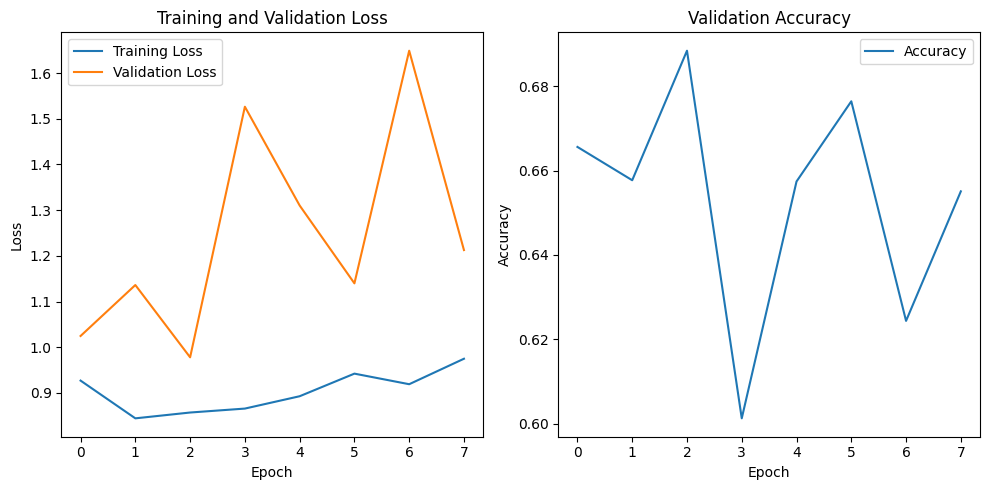

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-142/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-143
Epoch 1/50, Train Loss: 6.6920, Test Loss: 6.8099, Accuracy: 0.5607
Epoch 2/50, Train Loss: 5.0626, Test Loss: 5.0973, Accuracy: 0.6787
Epoch 3/50, Train Loss: 5.5429, Test Loss: 6.1331, Accuracy: 0.6346
Epoch 4/50, Train Loss: 5.6060, Test Loss: 6.6589, Accuracy: 0.6250
Epoch 5/50, Train Loss: 5.8989, Test Loss: 5.6799, Accuracy: 0.6244
Epoch 6/50, Train Loss: 6.1157, Test Loss: 6.3542, Accuracy: 0.6267
Epoch 7/50, Train Loss: 6.5784, Test Loss: 5.6504, Accuracy: 0.6653
Early st

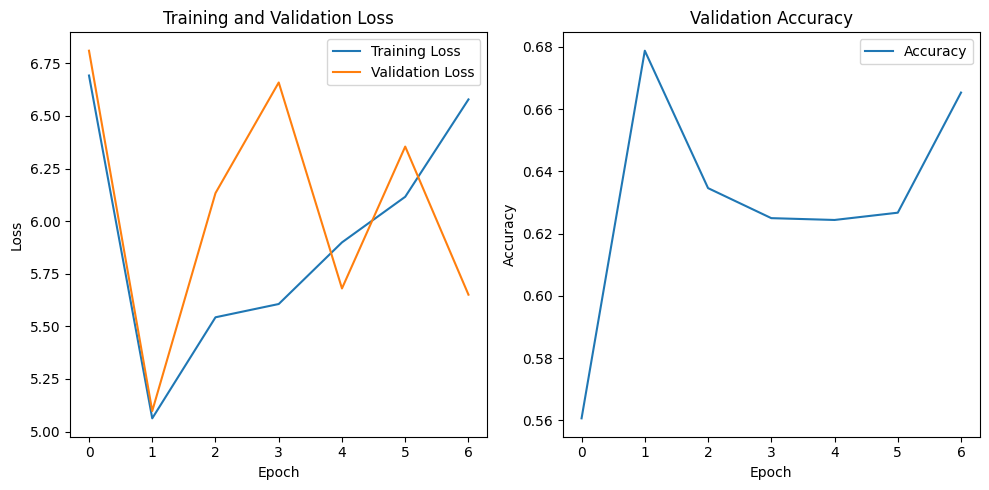

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-143/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-144
Epoch 1/50, Train Loss: 1.0441, Test Loss: 1.2660, Accuracy: 0.5709
Epoch 2/50, Train Loss: 0.8563, Test Loss: 1.2391, Accuracy: 0.5794
Epoch 3/50, Train Loss: 0.8353, Test Loss: 1.1620, Accuracy: 0.6068
Epoch 4/50, Train Loss: 0.8385, Test Loss: 1.2504, Accuracy: 0.6086
Epoch 5/50, Train Loss: 0.8343, Test Loss: 1.2000, Accuracy: 0.6004
Epoch 6/50, Train Loss: 0.8125, Test Loss: 1.4492, Accuracy: 0.5981
Epoch 7/50, Train Loss: 0.8073, Test Loss: 1.0980, Accuracy: 0.6369
Epoch 8/

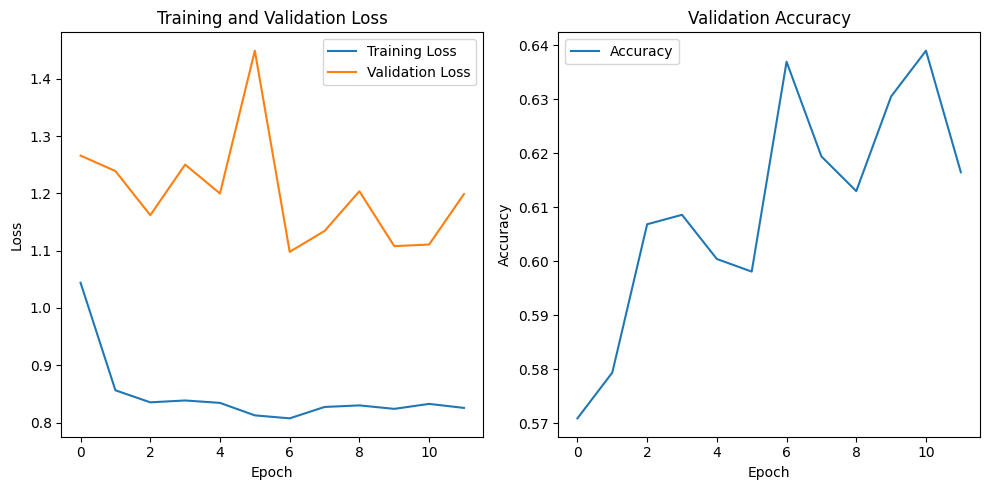

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-144/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-145
Epoch 1/50, Train Loss: 1.5912, Test Loss: 2.8967, Accuracy: 0.4984
Epoch 2/50, Train Loss: 1.8401, Test Loss: 2.8899, Accuracy: 0.5370
Epoch 3/50, Train Loss: 1.9652, Test Loss: 3.7358, Accuracy: 0.5066
Epoch 4/50, Train Loss: 1.9459, Test Loss: 3.5705, Accuracy: 0.4911
Epoch 5/50, Train Loss: 1.9973, Test Loss: 2.9346, Accuracy: 0.5393
Epoch 6/50, Train Loss: 1.9697, Test Loss: 3.1263, Accuracy: 0.5194
Epoch 7/50, Train Loss: 2.0153, Test Loss: 3.2828, Accuracy: 0.4750
Early st

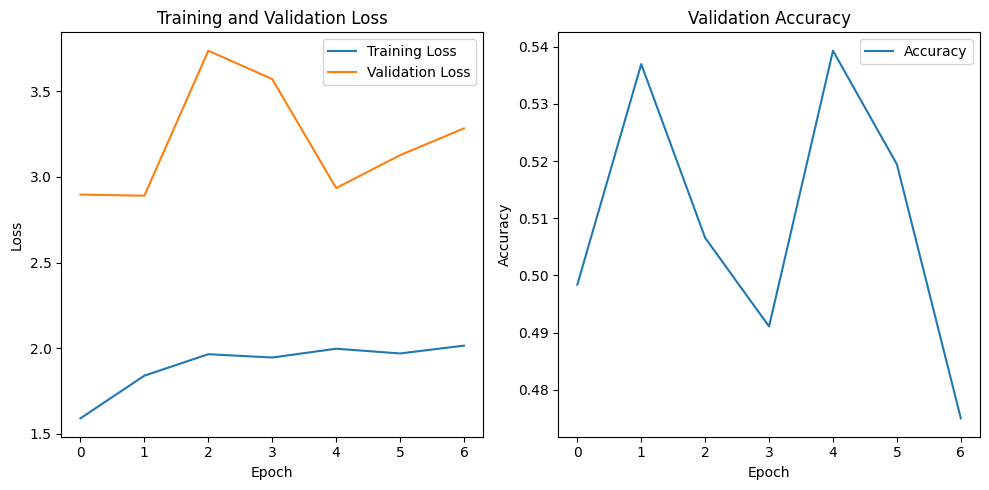

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-145/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-146
Epoch 1/50, Train Loss: 12.4031, Test Loss: 23.6332, Accuracy: 0.4586
Epoch 2/50, Train Loss: 13.9591, Test Loss: 22.9346, Accuracy: 0.4706
Epoch 3/50, Train Loss: 13.5554, Test Loss: 21.8423, Accuracy: 0.5247
Epoch 4/50, Train Loss: 14.2378, Test Loss: 37.7041, Accuracy: 0.4227
Epoch 5/50, Train Loss: 14.9038, Test Loss: 25.5761, Accuracy: 0.5095
Epoch 6/50, Train Loss: 13.7621, Test Loss: 25.3645, Accuracy: 0.5320
Epoch 7/50, Train Loss: 14.9188, Test Loss: 26.1020, Accuracy: 0

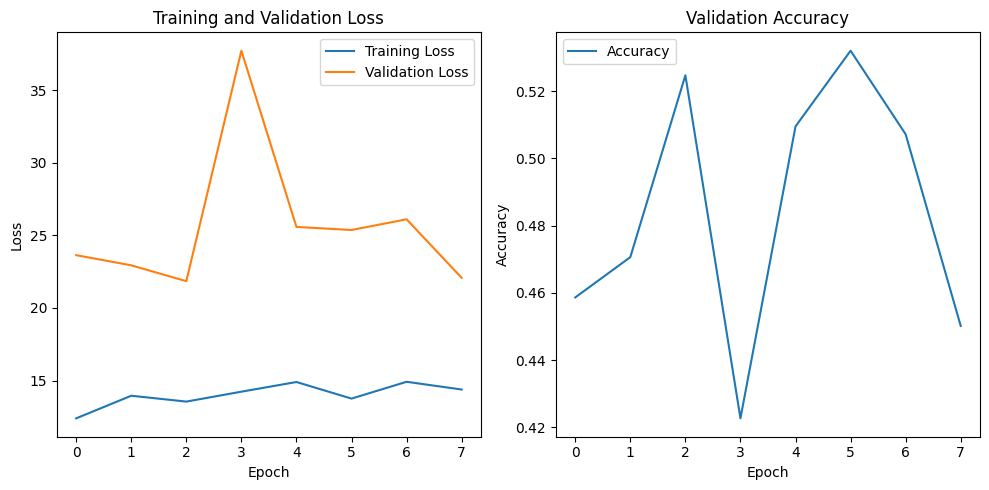

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-146/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-147
Epoch 1/50, Train Loss: 1.0680, Test Loss: 1.3167, Accuracy: 0.5761
Epoch 2/50, Train Loss: 0.7982, Test Loss: 1.1324, Accuracy: 0.6223
Epoch 3/50, Train Loss: 0.7579, Test Loss: 1.0976, Accuracy: 0.6127
Epoch 4/50, Train Loss: 0.7406, Test Loss: 1.0594, Accuracy: 0.6402
Epoch 5/50, Train Loss: 0.7292, Test Loss: 1.1066, Accuracy: 0.6314
Epoch 6/50, Train Loss: 0.7391, Test Loss: 1.1046, Accuracy: 0.6124
Epoch 7/50, Train Loss: 0.7213, Test Loss: 1.1053, Accuracy: 0.6217
Epoch 8/

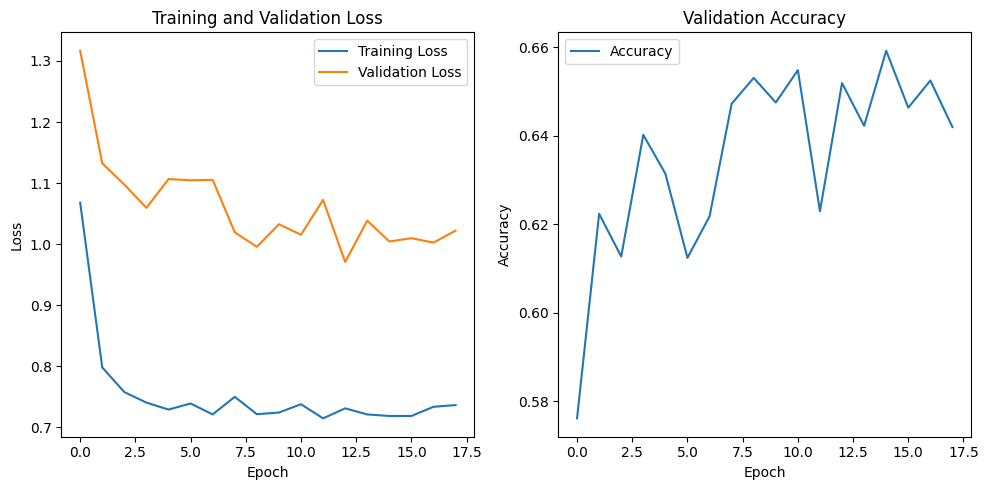

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-147/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-148
Epoch 1/50, Train Loss: 1.2719, Test Loss: 1.8230, Accuracy: 0.5735
Epoch 2/50, Train Loss: 1.3098, Test Loss: 2.7143, Accuracy: 0.4876
Epoch 3/50, Train Loss: 1.3618, Test Loss: 3.2771, Accuracy: 0.5957
Epoch 4/50, Train Loss: 1.3422, Test Loss: 2.3202, Accuracy: 0.5624
Epoch 5/50, Train Loss: 1.4006, Test Loss: 2.3519, Accuracy: 0.5384
Epoch 6/50, Train Loss: 1.4113, Test Loss: 2.6703, Accuracy: 0.5452
Early stopping at epoch 6


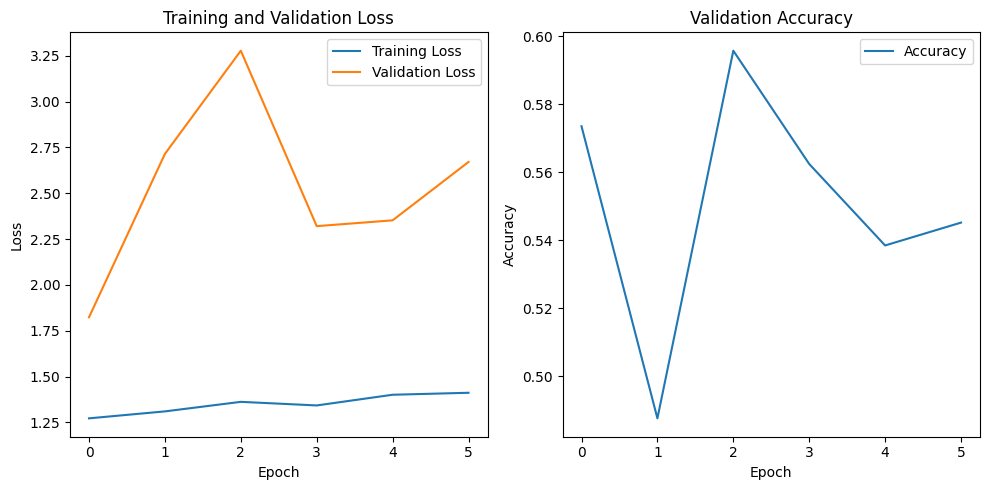

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-148/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-149
Epoch 1/50, Train Loss: 8.2947, Test Loss: 14.2675, Accuracy: 0.5402
Epoch 2/50, Train Loss: 9.9333, Test Loss: 11.5655, Accuracy: 0.5452
Epoch 3/50, Train Loss: 9.6331, Test Loss: 19.0398, Accuracy: 0.4969
Epoch 4/50, Train Loss: 9.9025, Test Loss: 14.0753, Accuracy: 0.5376
Epoch 5/50, Train Loss: 10.4260, Test Loss: 16.4454, Accuracy: 0.5379
Epoch 6/50, Train Loss: 10.1872, Test Loss: 14.2190, Accuracy: 0.5396
Epoch 7/50, Train Loss: 10.6027, Test Loss: 13.0196, Accuracy: 0.542

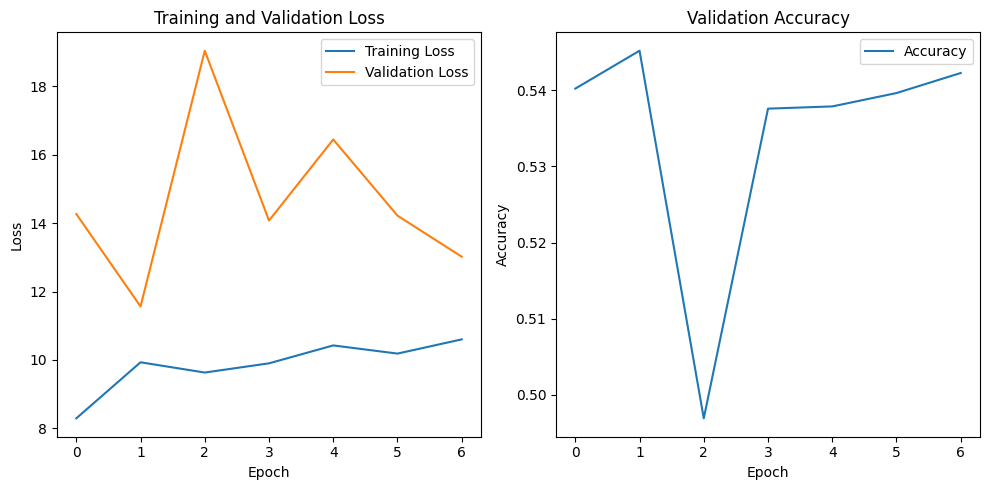

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-149/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-150
Epoch 1/50, Train Loss: 1.1317, Test Loss: 1.2150, Accuracy: 0.5954
Epoch 2/50, Train Loss: 0.8071, Test Loss: 1.1165, Accuracy: 0.6150
Epoch 3/50, Train Loss: 0.7562, Test Loss: 1.0331, Accuracy: 0.6437
Epoch 4/50, Train Loss: 0.7307, Test Loss: 1.0358, Accuracy: 0.6489
Epoch 5/50, Train Loss: 0.7092, Test Loss: 1.0027, Accuracy: 0.6559
Epoch 6/50, Train Loss: 0.6969, Test Loss: 1.0545, Accuracy: 0.6372
Epoch 7/50, Train Loss: 0.6825, Test Loss: 0.9951, Accuracy: 0.6539
Epoch 8/

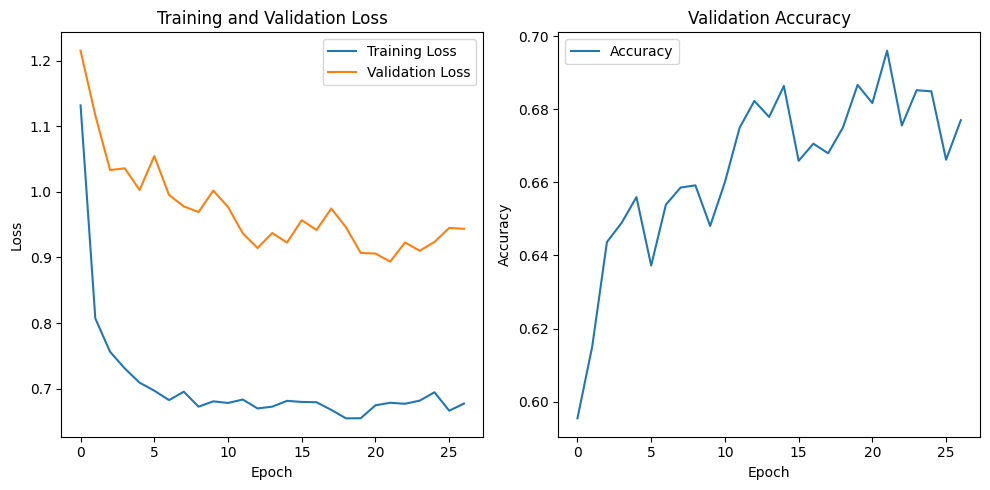

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-150/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-151
Epoch 1/50, Train Loss: 1.0360, Test Loss: 1.6053, Accuracy: 0.5443
Epoch 2/50, Train Loss: 1.0022, Test Loss: 1.3629, Accuracy: 0.6168
Epoch 3/50, Train Loss: 1.0240, Test Loss: 2.0069, Accuracy: 0.5197
Epoch 4/50, Train Loss: 1.0977, Test Loss: 1.7277, Accuracy: 0.5738
Epoch 5/50, Train Loss: 1.0926, Test Loss: 1.6639, Accuracy: 0.5794
Epoch 6/50, Train Loss: 1.1020, Test Loss: 1.6923, Accuracy: 0.5753
Epoch 7/50, Train Loss: 1.0660, Test Loss: 1.6623, Accuracy: 0.6109
Early st

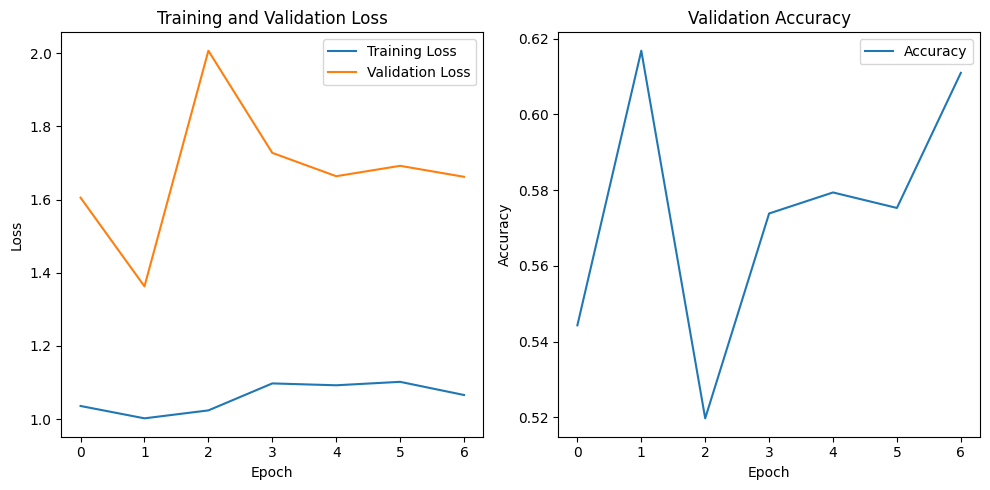

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-151/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-152
Epoch 1/50, Train Loss: 5.5818, Test Loss: 7.9552, Accuracy: 0.5349
Epoch 2/50, Train Loss: 6.0056, Test Loss: 12.1545, Accuracy: 0.5104
Epoch 3/50, Train Loss: 6.4528, Test Loss: 10.3429, Accuracy: 0.5431
Epoch 4/50, Train Loss: 7.0083, Test Loss: 11.3643, Accuracy: 0.5779
Epoch 5/50, Train Loss: 6.8432, Test Loss: 13.2886, Accuracy: 0.5083
Epoch 6/50, Train Loss: 7.1428, Test Loss: 11.3702, Accuracy: 0.5276
Early stopping at epoch 6


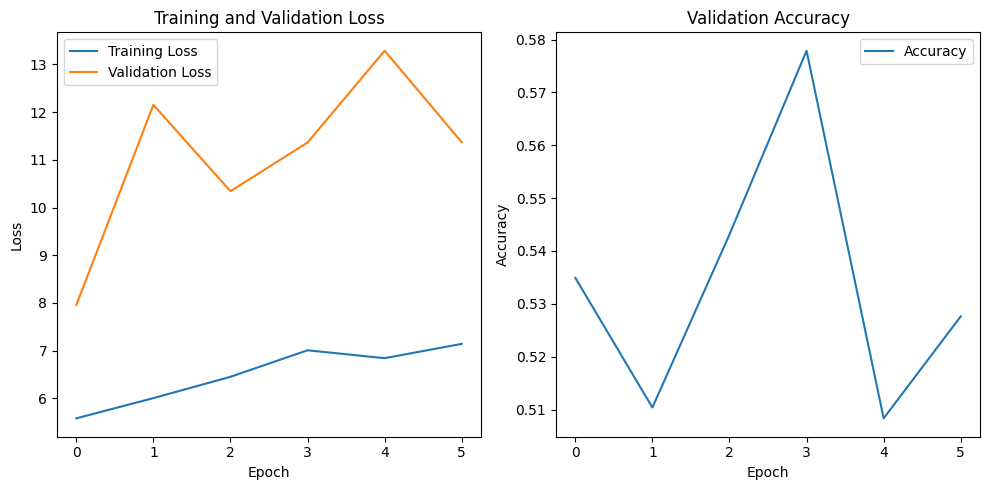

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-152/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-153
Epoch 1/50, Train Loss: 0.8907, Test Loss: 5.3319, Accuracy: 0.4543
Epoch 2/50, Train Loss: 0.7266, Test Loss: 4.5497, Accuracy: 0.4443
Epoch 3/50, Train Loss: 0.7194, Test Loss: 8.0879, Accuracy: 0.4171
Epoch 4/50, Train Loss: 0.6998, Test Loss: 3.0757, Accuracy: 0.5352
Epoch 5/50, Train Loss: 0.6689, Test Loss: 4.1980, Accuracy: 0.4762
Epoch 6/50, Train Loss: 0.6717, Test Loss: 2.4517, Accuracy: 0.5563
Epoch 7/50, Train Loss: 0.6692, Test Loss: 6.5005, Accuracy: 0.4554
Epoch 8/

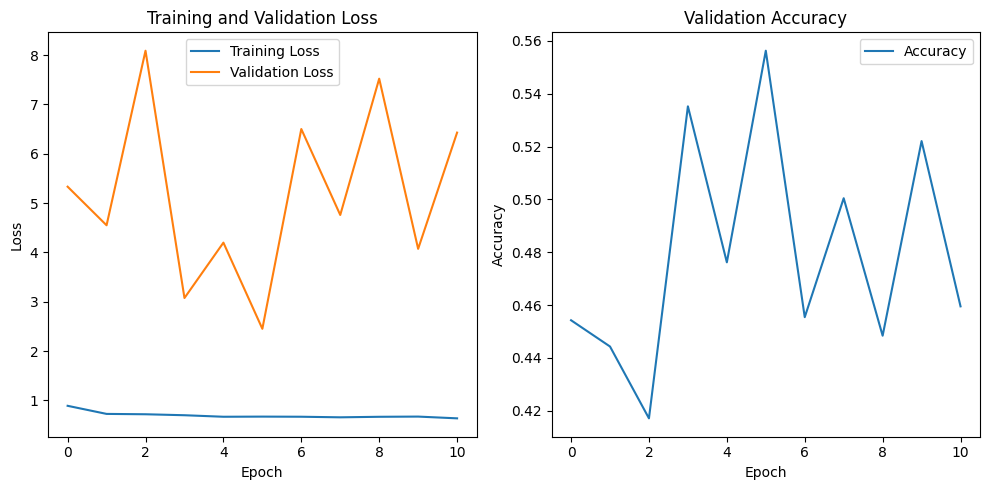

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-153/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-154
Epoch 1/50, Train Loss: 2.2582, Test Loss: 21.2864, Accuracy: 0.4113
Epoch 2/50, Train Loss: 2.5447, Test Loss: 18.4328, Accuracy: 0.4317
Epoch 3/50, Train Loss: 2.5349, Test Loss: 31.0865, Accuracy: 0.4256
Epoch 4/50, Train Loss: 2.7552, Test Loss: 22.8762, Accuracy: 0.4212
Epoch 5/50, Train Loss: 2.9232, Test Loss: 37.1920, Accuracy: 0.4408
Epoch 6/50, Train Loss: 2.7229, Test Loss: 20.2013, Accuracy: 0.4464
Epoch 7/50, Train Loss: 2.7113, Test Loss: 31.3511, Accuracy: 0.4604
E

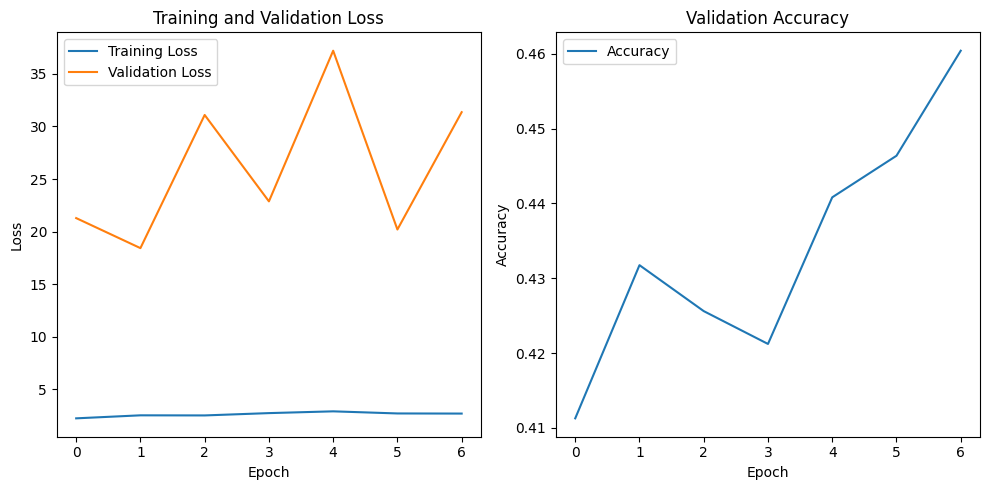

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-154/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-155
Epoch 1/50, Train Loss: 21.4958, Test Loss: 170.2792, Accuracy: 0.3864
Epoch 2/50, Train Loss: 20.8660, Test Loss: 190.7013, Accuracy: 0.4431
Epoch 3/50, Train Loss: 23.2292, Test Loss: 296.2556, Accuracy: 0.3885
Epoch 4/50, Train Loss: 23.8569, Test Loss: 174.1500, Accuracy: 0.4396
Epoch 5/50, Train Loss: 24.5943, Test Loss: 202.8591, Accuracy: 0.3075
Epoch 6/50, Train Loss: 23.9617, Test Loss: 218.2766, Accuracy: 0.4288
Early stopping at epoch 6


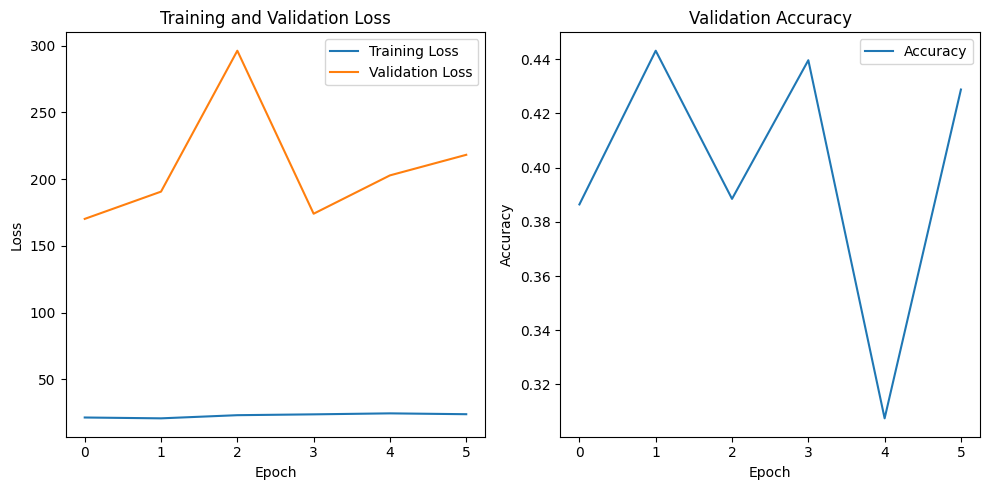

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-155/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-156
Epoch 1/50, Train Loss: 0.8574, Test Loss: 1.7660, Accuracy: 0.5457
Epoch 2/50, Train Loss: 0.6441, Test Loss: 2.9941, Accuracy: 0.5037
Epoch 3/50, Train Loss: 0.6169, Test Loss: 1.9452, Accuracy: 0.5434
Epoch 4/50, Train Loss: 0.5899, Test Loss: 2.8843, Accuracy: 0.5308
Epoch 5/50, Train Loss: 0.5871, Test Loss: 2.6425, Accuracy: 0.5288
Epoch 6/50, Train Loss: 0.5563, Test Loss: 2.8727, Accuracy: 0.5229
Early stopping at epoch 6


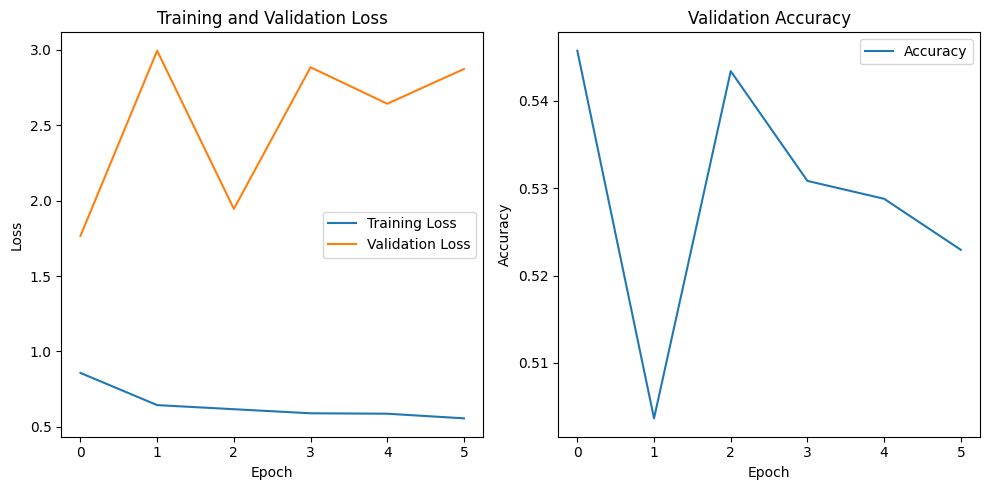

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-156/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-157
Epoch 1/50, Train Loss: 1.5764, Test Loss: 6.5041, Accuracy: 0.4741
Epoch 2/50, Train Loss: 1.4974, Test Loss: 7.4636, Accuracy: 0.4621
Epoch 3/50, Train Loss: 1.6094, Test Loss: 9.5189, Accuracy: 0.4879
Epoch 4/50, Train Loss: 1.4843, Test Loss: 8.3360, Accuracy: 0.5165
Epoch 5/50, Train Loss: 1.6997, Test Loss: 8.2001, Accuracy: 0.5262
Epoch 6/50, Train Loss: 1.6864, Test Loss: 7.3968, Accuracy: 0.5510
Early stopping at epoch 6


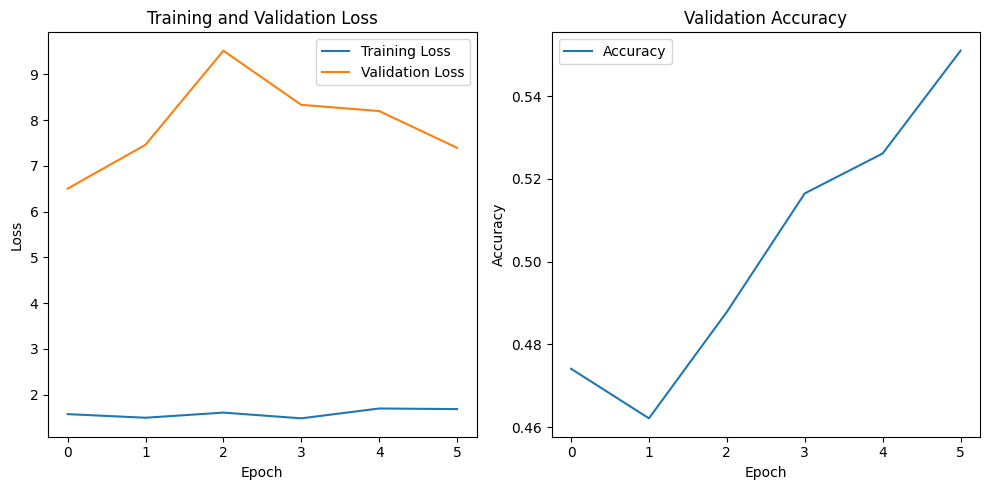

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-157/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-158
Epoch 1/50, Train Loss: 14.3275, Test Loss: 43.9305, Accuracy: 0.4855
Epoch 2/50, Train Loss: 12.8539, Test Loss: 56.3250, Accuracy: 0.4686
Epoch 3/50, Train Loss: 14.4098, Test Loss: 53.7599, Accuracy: 0.4993
Epoch 4/50, Train Loss: 13.1867, Test Loss: 41.2347, Accuracy: 0.4931
Epoch 5/50, Train Loss: 14.8915, Test Loss: 70.1003, Accuracy: 0.4396
Epoch 6/50, Train Loss: 16.1251, Test Loss: 105.7597, Accuracy: 0.4583
Epoch 7/50, Train Loss: 15.7837, Test Loss: 75.2795, Accuracy: 

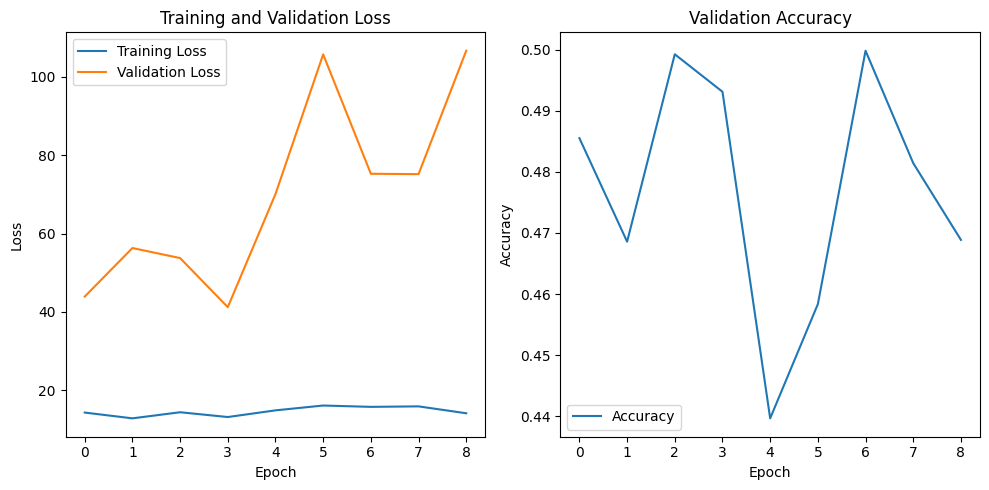

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-158/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-159
Epoch 1/50, Train Loss: 0.8742, Test Loss: 1.4711, Accuracy: 0.5519
Epoch 2/50, Train Loss: 0.6086, Test Loss: 1.5898, Accuracy: 0.5913
Epoch 3/50, Train Loss: 0.5707, Test Loss: 1.7893, Accuracy: 0.5510
Epoch 4/50, Train Loss: 0.5320, Test Loss: 1.6114, Accuracy: 0.5688
Epoch 5/50, Train Loss: 0.5277, Test Loss: 1.3028, Accuracy: 0.6147
Epoch 6/50, Train Loss: 0.5105, Test Loss: 1.6499, Accuracy: 0.5776
Epoch 7/50, Train Loss: 0.5075, Test Loss: 1.6593, Accuracy: 0.5826
Epoch 8/

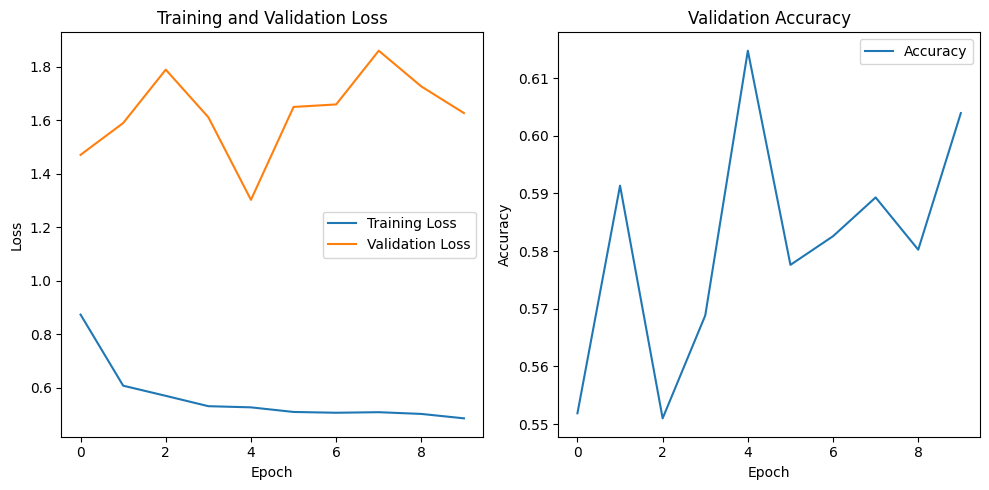

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-159/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-160
Epoch 1/50, Train Loss: 1.3112, Test Loss: 2.1937, Accuracy: 0.5624
Epoch 2/50, Train Loss: 0.9645, Test Loss: 2.4875, Accuracy: 0.5379
Epoch 3/50, Train Loss: 0.9711, Test Loss: 2.8944, Accuracy: 0.5823
Epoch 4/50, Train Loss: 1.0209, Test Loss: 2.7691, Accuracy: 0.5861
Epoch 5/50, Train Loss: 1.0287, Test Loss: 3.0094, Accuracy: 0.6200
Epoch 6/50, Train Loss: 1.0658, Test Loss: 6.1478, Accuracy: 0.5668
Early stopping at epoch 6


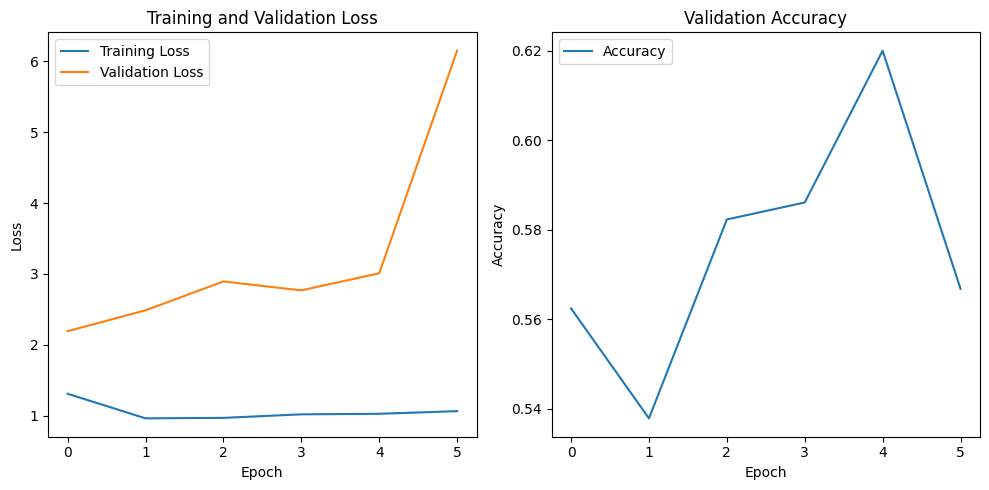

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-160/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-161
Epoch 1/50, Train Loss: 11.1537, Test Loss: 31.8350, Accuracy: 0.4806
Epoch 2/50, Train Loss: 7.7416, Test Loss: 42.8065, Accuracy: 0.4344
Epoch 3/50, Train Loss: 8.2129, Test Loss: 35.2382, Accuracy: 0.5308
Epoch 4/50, Train Loss: 8.1939, Test Loss: 25.0092, Accuracy: 0.5238
Epoch 5/50, Train Loss: 8.8058, Test Loss: 33.9261, Accuracy: 0.5428
Epoch 6/50, Train Loss: 9.3742, Test Loss: 41.3284, Accuracy: 0.5355
Epoch 7/50, Train Loss: 9.2912, Test Loss: 44.4126, Accuracy: 0.4753


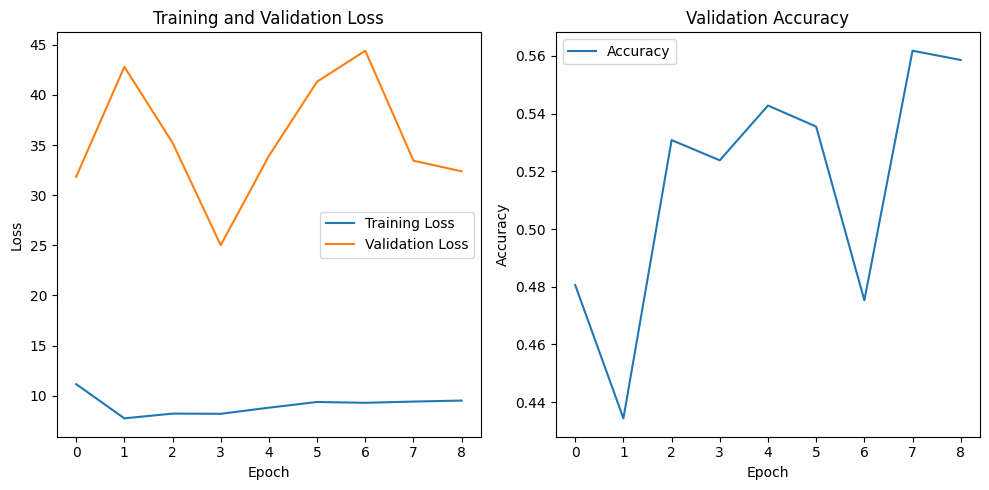

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-161/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-162
Epoch 1/50, Train Loss: 1.0152, Test Loss: 1.2302, Accuracy: 0.6153
Epoch 2/50, Train Loss: 0.8523, Test Loss: 0.9622, Accuracy: 0.6825
Epoch 3/50, Train Loss: 0.8181, Test Loss: 1.1131, Accuracy: 0.6457
Epoch 4/50, Train Loss: 0.8115, Test Loss: 1.1131, Accuracy: 0.6627
Epoch 5/50, Train Loss: 0.8015, Test Loss: 0.9766, Accuracy: 0.6802
Epoch 6/50, Train Loss: 0.8234, Test Loss: 1.1021, Accuracy: 0.6618
Epoch 7/50, Train Loss: 0.8001, Test Loss: 1.0491, Accuracy: 0.6814
Early st

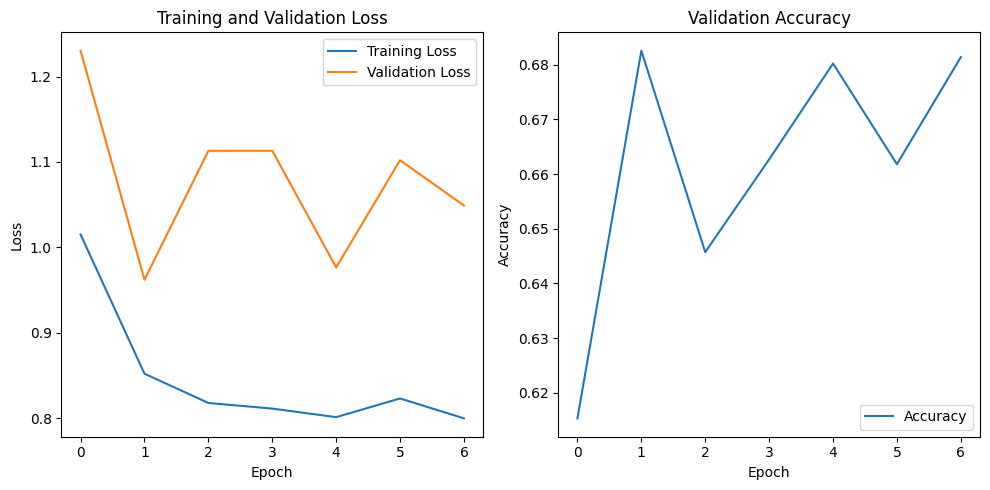

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-162/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-163
Epoch 1/50, Train Loss: 2.3872, Test Loss: 3.4171, Accuracy: 0.5782
Epoch 2/50, Train Loss: 2.6135, Test Loss: 3.8385, Accuracy: 0.6086
Epoch 3/50, Train Loss: 2.8518, Test Loss: 5.4280, Accuracy: 0.5387
Epoch 4/50, Train Loss: 2.6936, Test Loss: 5.5864, Accuracy: 0.5346
Epoch 5/50, Train Loss: 2.8801, Test Loss: 4.6298, Accuracy: 0.5829
Epoch 6/50, Train Loss: 2.8451, Test Loss: 3.2859, Accuracy: 0.6191
Early stopping at epoch 6


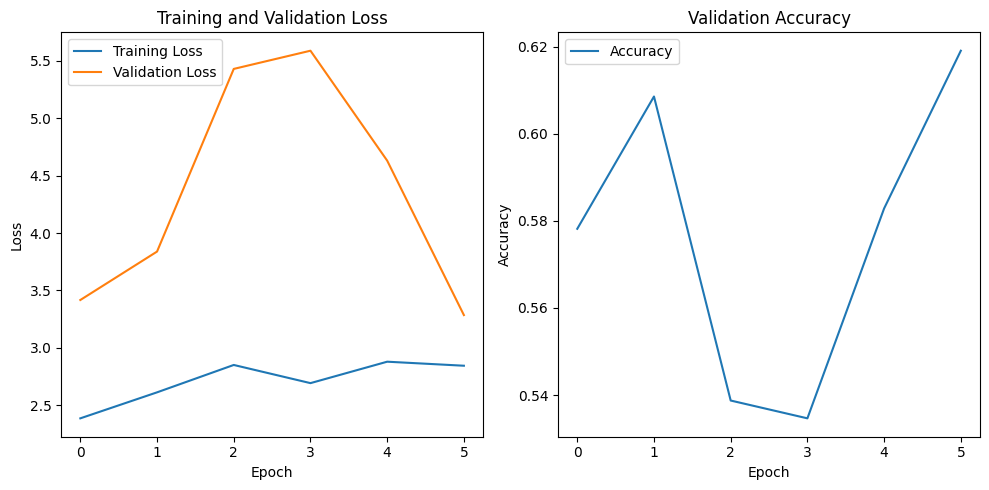

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-163/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-164
Epoch 1/50, Train Loss: 21.2504, Test Loss: 25.4894, Accuracy: 0.5832
Epoch 2/50, Train Loss: 22.7019, Test Loss: 35.6042, Accuracy: 0.5098
Epoch 3/50, Train Loss: 23.5717, Test Loss: 32.1240, Accuracy: 0.5612
Epoch 4/50, Train Loss: 22.7654, Test Loss: 27.3772, Accuracy: 0.5811
Epoch 5/50, Train Loss: 24.4553, Test Loss: 54.1845, Accuracy: 0.4595
Epoch 6/50, Train Loss: 25.0004, Test Loss: 26.8145, Accuracy: 0.6027
Epoch 7/50, Train Loss: 23.7279, Test Loss: 27.8911, Accuracy: 0

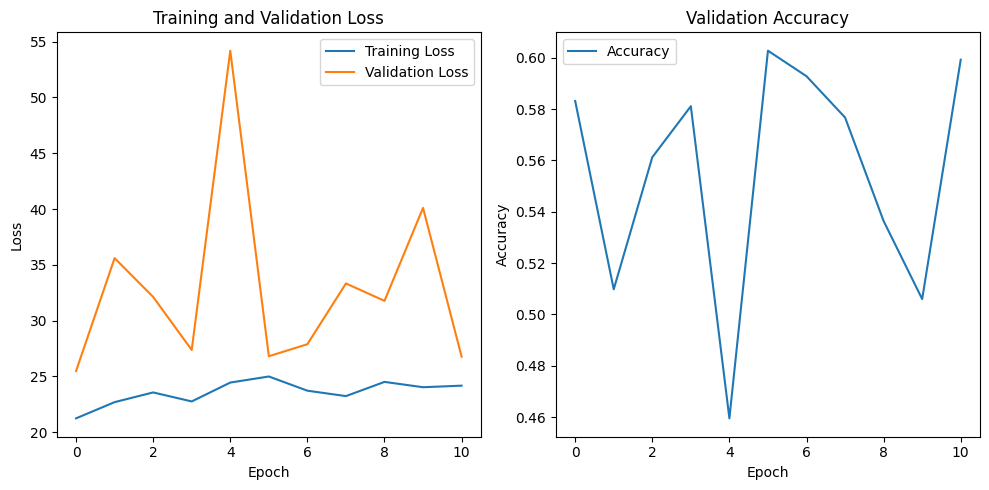

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-164/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-165
Epoch 1/50, Train Loss: 0.9707, Test Loss: 1.0192, Accuracy: 0.6635
Epoch 2/50, Train Loss: 0.7927, Test Loss: 0.8933, Accuracy: 0.7056
Epoch 3/50, Train Loss: 0.7511, Test Loss: 0.8613, Accuracy: 0.7097
Epoch 4/50, Train Loss: 0.7417, Test Loss: 0.9130, Accuracy: 0.7001
Epoch 5/50, Train Loss: 0.7046, Test Loss: 0.8049, Accuracy: 0.7325
Epoch 6/50, Train Loss: 0.7079, Test Loss: 0.9083, Accuracy: 0.7091
Epoch 7/50, Train Loss: 0.7036, Test Loss: 0.8029, Accuracy: 0.7360
Epoch 8/

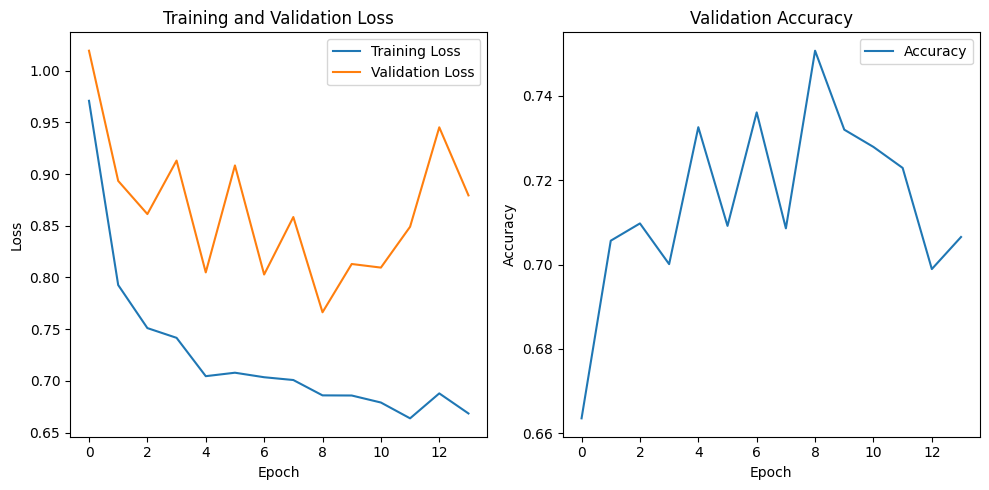

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-165/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-166
Epoch 1/50, Train Loss: 1.7187, Test Loss: 2.5704, Accuracy: 0.5583
Epoch 2/50, Train Loss: 1.8342, Test Loss: 2.4897, Accuracy: 0.6364
Epoch 3/50, Train Loss: 1.8812, Test Loss: 1.8725, Accuracy: 0.6849
Epoch 4/50, Train Loss: 1.8480, Test Loss: 2.3477, Accuracy: 0.6679
Epoch 5/50, Train Loss: 2.0370, Test Loss: 2.0199, Accuracy: 0.6863
Epoch 6/50, Train Loss: 1.8466, Test Loss: 2.4467, Accuracy: 0.6612
Epoch 7/50, Train Loss: 1.9253, Test Loss: 2.5127, Accuracy: 0.6352
Epoch 8/

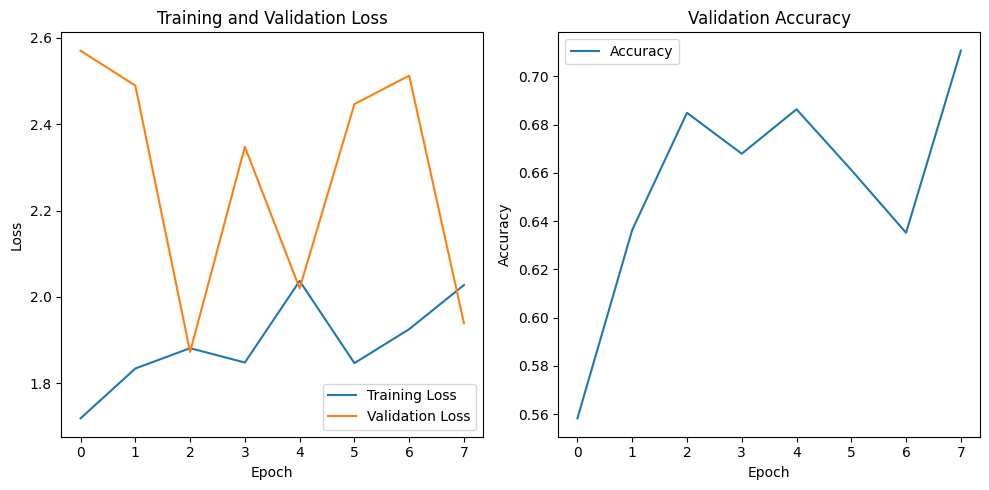

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-166/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-167
Epoch 1/50, Train Loss: 14.5297, Test Loss: 19.0650, Accuracy: 0.5715
Epoch 2/50, Train Loss: 15.2952, Test Loss: 17.0464, Accuracy: 0.6486
Epoch 3/50, Train Loss: 15.3137, Test Loss: 20.0591, Accuracy: 0.6022
Epoch 4/50, Train Loss: 16.2893, Test Loss: 21.4708, Accuracy: 0.6022
Epoch 5/50, Train Loss: 16.1325, Test Loss: 19.2761, Accuracy: 0.6326
Epoch 6/50, Train Loss: 16.7096, Test Loss: 32.0197, Accuracy: 0.5457
Epoch 7/50, Train Loss: 17.6812, Test Loss: 21.8025, Accuracy: 0

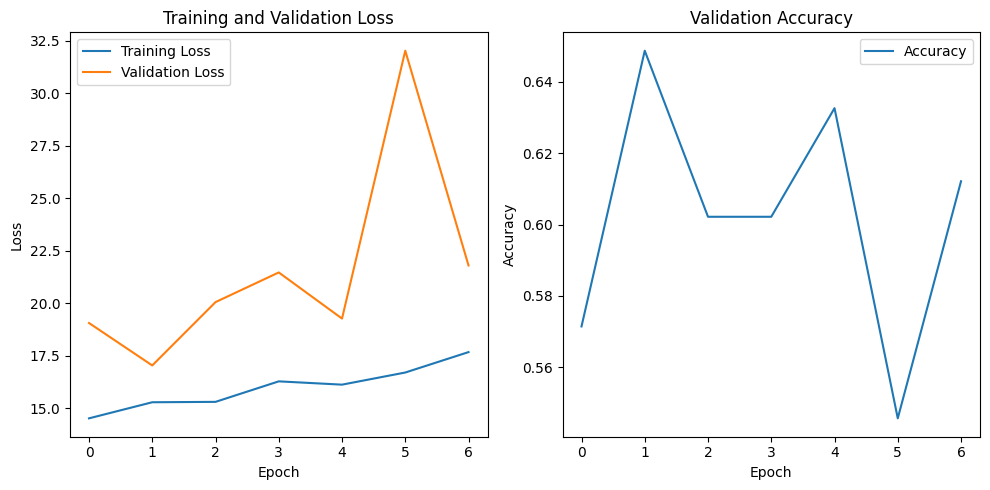

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-167/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-168
Epoch 1/50, Train Loss: 1.0340, Test Loss: 0.9498, Accuracy: 0.6849
Epoch 2/50, Train Loss: 0.7582, Test Loss: 0.8577, Accuracy: 0.7129
Epoch 3/50, Train Loss: 0.6957, Test Loss: 0.9053, Accuracy: 0.6995
Epoch 4/50, Train Loss: 0.6905, Test Loss: 0.9271, Accuracy: 0.6899
Epoch 5/50, Train Loss: 0.6732, Test Loss: 0.8408, Accuracy: 0.7091
Epoch 6/50, Train Loss: 0.6525, Test Loss: 0.8181, Accuracy: 0.7238
Epoch 7/50, Train Loss: 0.6581, Test Loss: 0.7692, Accuracy: 0.7390
Epoch 8/

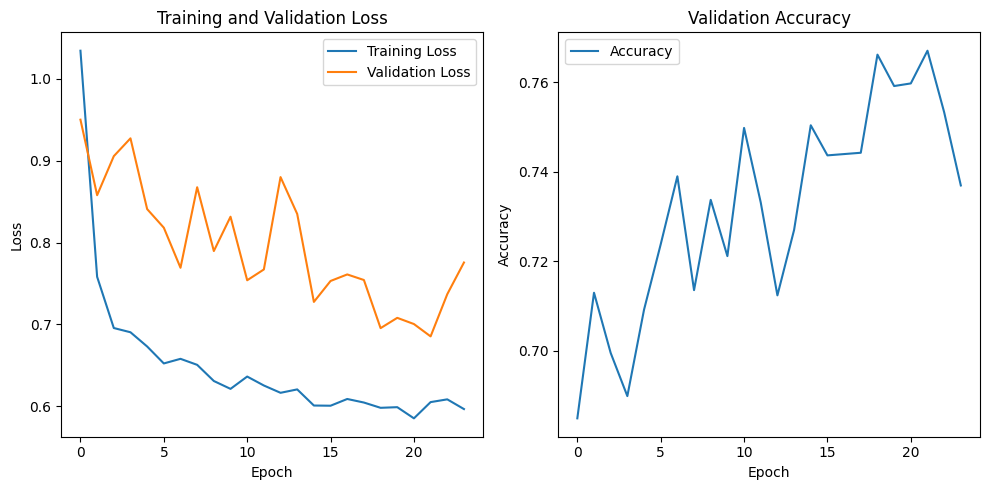

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-168/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-169
Epoch 1/50, Train Loss: 1.3112, Test Loss: 1.2012, Accuracy: 0.6741
Epoch 2/50, Train Loss: 1.1710, Test Loss: 1.6591, Accuracy: 0.6369
Epoch 3/50, Train Loss: 1.2547, Test Loss: 1.4924, Accuracy: 0.6735
Epoch 4/50, Train Loss: 1.3574, Test Loss: 1.8136, Accuracy: 0.6524
Epoch 5/50, Train Loss: 1.4257, Test Loss: 1.5820, Accuracy: 0.6925
Epoch 6/50, Train Loss: 1.2496, Test Loss: 1.6280, Accuracy: 0.6881
Early stopping at epoch 6


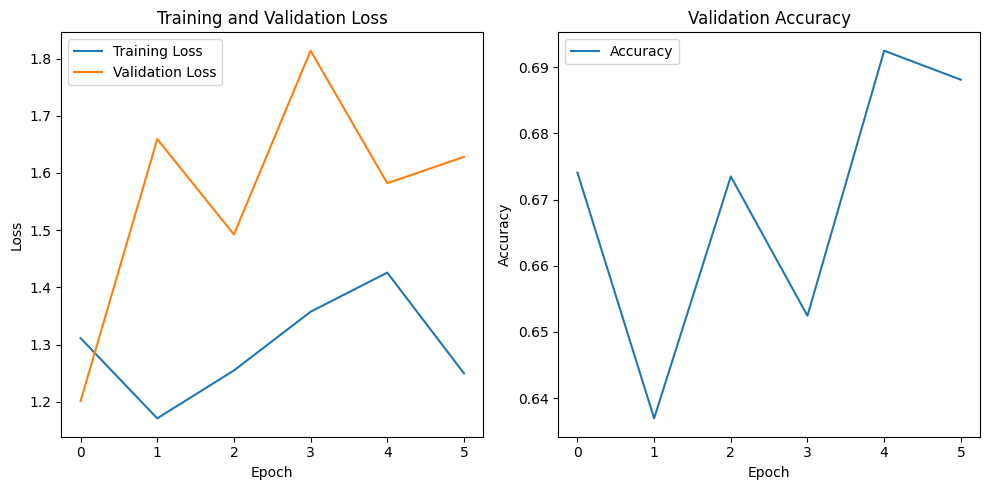

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-169/metadata
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-170
Epoch 1/50, Train Loss: 10.2390, Test Loss: 9.2599, Accuracy: 0.6478
Epoch 2/50, Train Loss: 9.4594, Test Loss: 18.1706, Accuracy: 0.5516
Epoch 3/50, Train Loss: 10.3689, Test Loss: 12.7996, Accuracy: 0.6574
Epoch 4/50, Train Loss: 9.8333, Test Loss: 11.2391, Accuracy: 0.6673
Epoch 5/50, Train Loss: 10.7641, Test Loss: 11.0833, Accuracy: 0.6668
Epoch 6/50, Train Loss: 10.9626, Test Loss: 13.3808, Accuracy: 0.6703
Early stopping at epoch 6


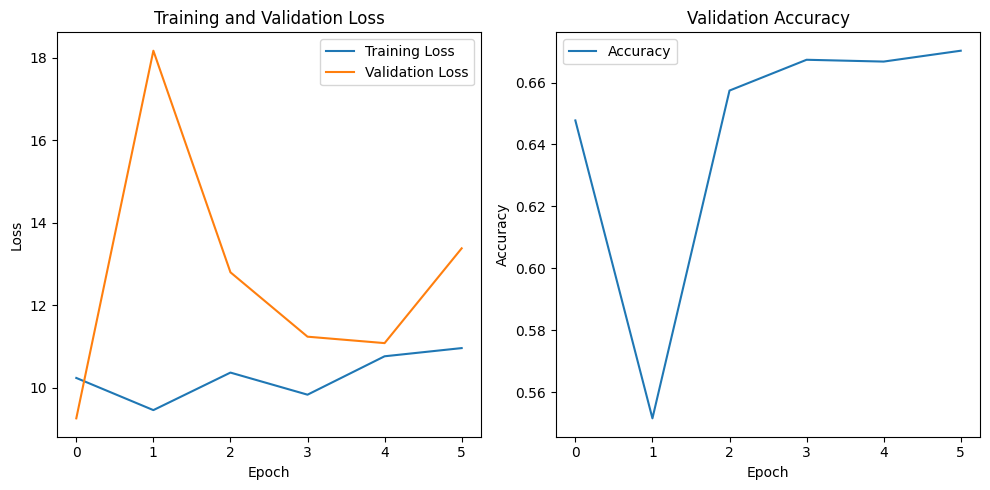

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/konrads/BloodMNIST/e/BLOOD-170/metadata


In [ ]:
# Various Hyperparameters execution
for model_name in models_pretrained:
  for batch_size in batch_sizes:
    for learning_rate in learning_rates:
      # start neptune run
      params = {
        "pre-trained model_name": model_name,
        "epochs": epochs,
        "batch_size": batch_size,
        "data_flag": data_flag,
        "architecture": "CNN",
        "optimizer": "AdamW",
        "metrics": ["accuracy", "loss"],
        "activation": "relu",
        "learning_rate":learning_rate,
        "device": device,
        "patience": patience,
        "best_loss": best_loss,
        "epochs_without_improvement": epochs_without_improvement,
        "data_augmentation": True
      }
      tags = [f"{return_variable_name(model_name)}","data_augmentation"]
      name = f"{return_variable_name(model_name)}-data_augmentation-bs{str(batch_size)}-lr{str(learning_rate)}"
      run = init_neptune(params,name,tags)

      # Initiate instance of pre-trained model, modification of final fully connected layer
      # Freeze all the weights
      for param in model_name.parameters():
        param.requires_grad = False

      # assign proper number of classes
      num_ftrs = model_name.fc.in_features
      model_name.fc = nn.Linear(num_ftrs, n_classes)

      # Ensure the classifier's weights are trainable
      for param in model_name.fc.parameters():
        param.requires_grad = True

      # Setup variables for training
      train_loader,test_loader,val_loader = data_loaders_preparation(train_dataset_aug, val_dataset_aug, test_dataset_aug, batch_size)
      epochs = epochs
      patience = patience
      best_loss = best_loss
      epochs_without_improvement = epochs_without_improvement
      learning_rate = learning_rate
      data_augmentation=True

      # train model
      train_losses_aug, test_losses_aug, accuracies_aug = train_and_test_model(model_name.to(device),train_loader,test_loader,val_loader,epochs,learning_rate,patience,best_loss,epochs_without_improvement,name,data_augmentation)

      # visualize results
      visualize_training_progress(train_losses_aug, test_losses_aug, accuracies_aug)
      run["test/results"].upload("training_progress.png")

      # stop neptune run
      run.stop()

**11. XAI - Explainable AI methods**
---

In this section there are all XAI methods used to explain the results.
After analysis of all models that were created the best performing one is: **BloodMNIST-Data-Augmentation-bs32-lr0.001-best-model.pth**


This is the model that will be deployed and analyzed with use of XAI.

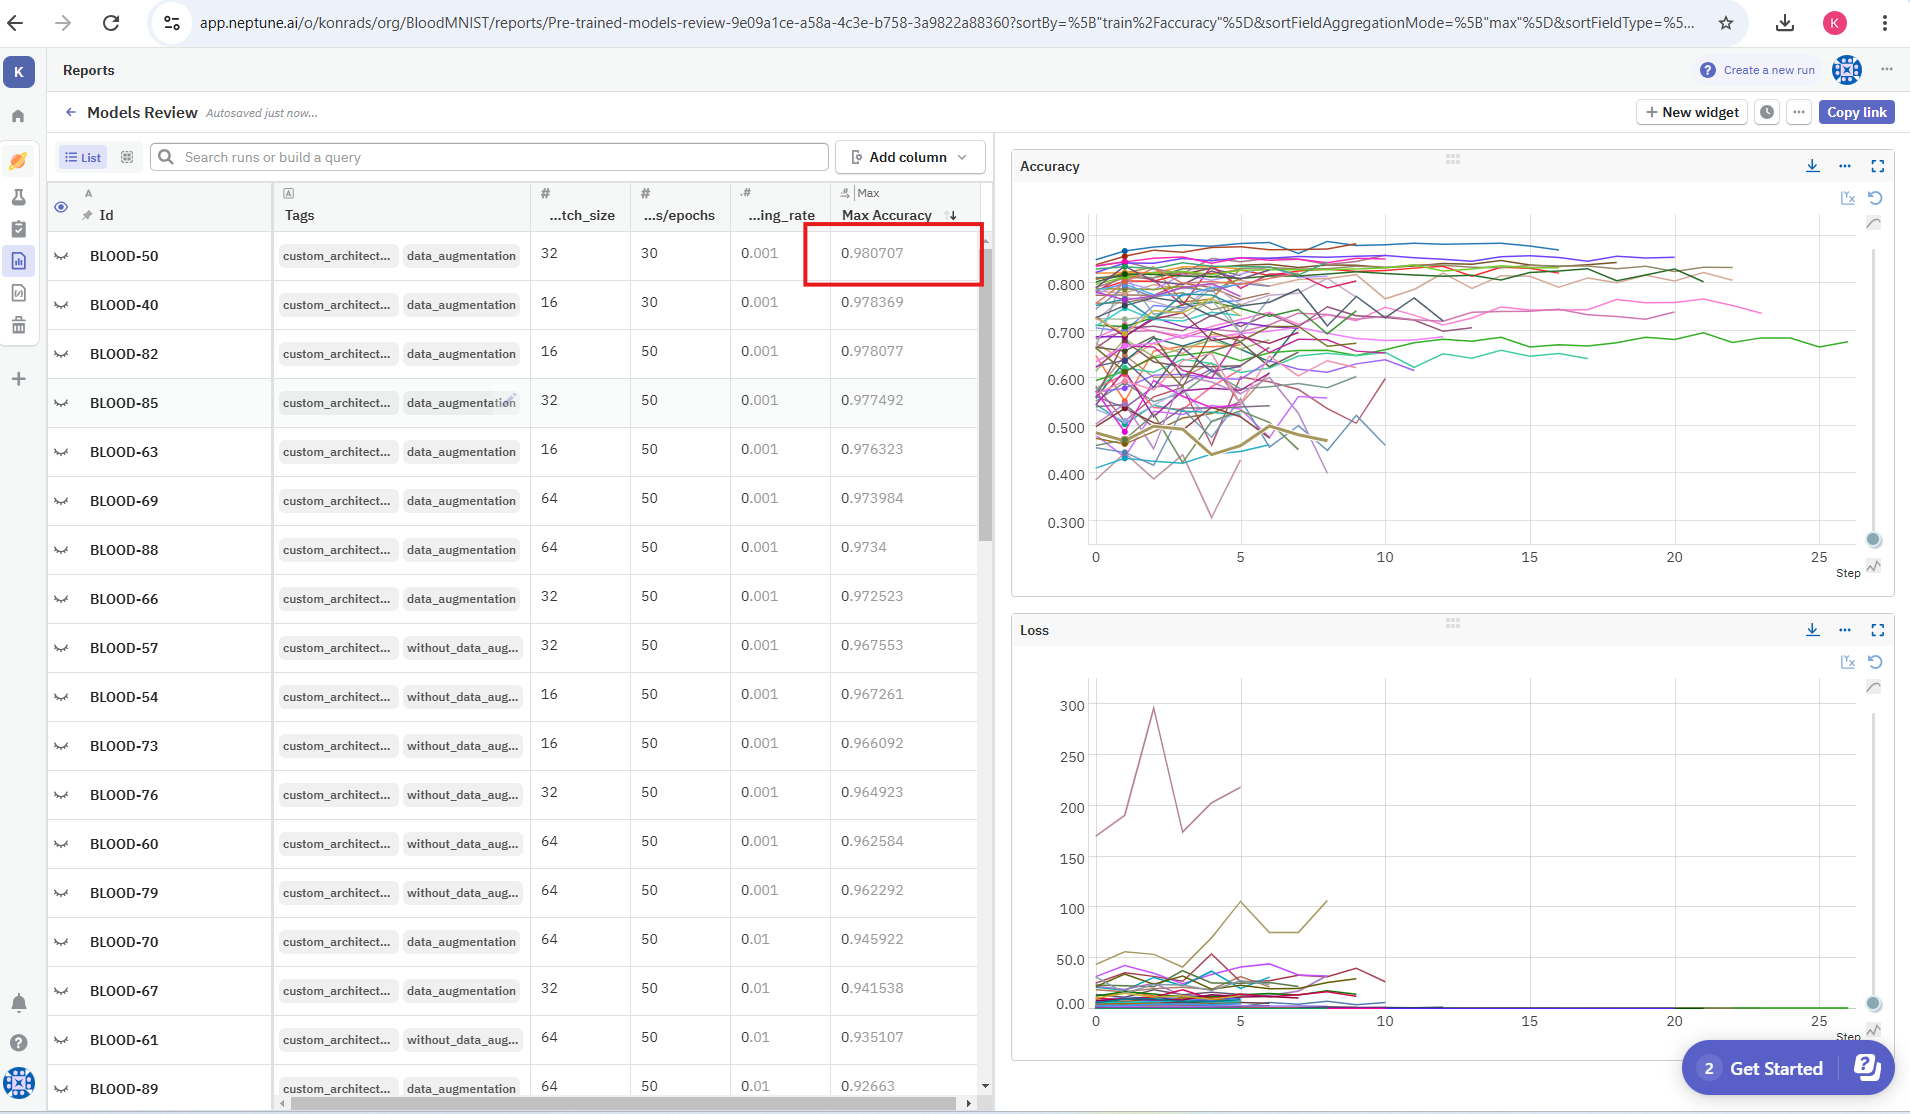

Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


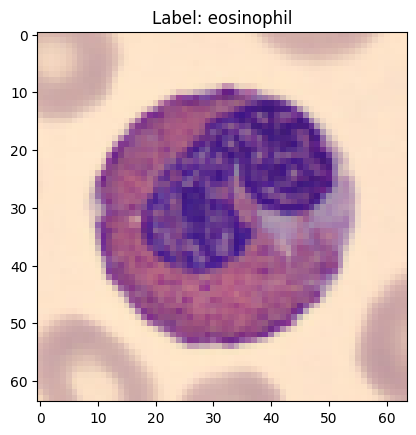

In [35]:
from PIL import Image
# Select random picture the validation set to use XAI
val_dataset_aug = BloodMNIST(split='val', download=download,size = size)

image_id = np.random.randint(0, len(val_dataset_aug))
image = val_dataset_aug.imgs[image_id]
label = val_dataset_aug.info["label"][str(val_dataset_aug.labels[image_id][0])]

# show few examples
fig = plt.figure()
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.title(f"Label: {label}")
plt.show()

# save image to the session
# Convert array to image
img = Image.fromarray(image)
img.save('XAI_image.jpeg')



**LIME Results preparation**

To explain results of the model there were LIME and captum library used.

In [36]:
from lime import lime_image  ### Note that LIME can be also used from Captum package
from captum.attr import GradientShap, visualization as viz
from captum.attr import GuidedGradCam

# Load the best saved model
best_model = CNN(n_classes).to(device)
best_model.load_state_dict(torch.load('BloodMNIST-Data-Augmentation-bs32-lr0.001-best-model.pth'))
best_model.eval()

# Load and preprocess an ImageNet image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

image_path = "XAI_image.jpeg"
input_image = preprocess_image(image_path)


<ipython-input-36-5d2eb51f8a9c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('BloodMNIST-Data-Augmentation-bs32-lr0.001-best-model.

In [37]:
# 1. LIME Explanation
from lime.wrappers.scikit_image import SegmentationAlgorithm

def predict_proba(images):
    images = torch.tensor(images,device = device, dtype=torch.float32).permute(0, 3, 1, 2)
    with torch.no_grad():
        logits = best_model(images)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.cpu().numpy()

explainer = lime_image.LimeImageExplainer()
segmentation_fn = SegmentationAlgorithm("quickshift", kernel_size=5, max_dist=10, ratio=0.9)

explanation = explainer.explain_instance(
    image=np.array(Image.open(image_path).resize((64, 64))).astype(np.float32) / 255.0,  # Scale to [0, 1],
    classifier_fn=predict_proba,
    segmentation_fn=segmentation_fn
)

lime_image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=5
)

# Ensure LIME image values are normalized for saving
lime_image = (lime_image * 255).astype(np.uint8)

# Save the LIME result
lime_result = Image.fromarray(lime_image)
lime_result.show()
lime_result.save("lime_result.png")


  0%|          | 0/1000 [00:00<?, ?it/s]

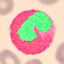

**GradShap**

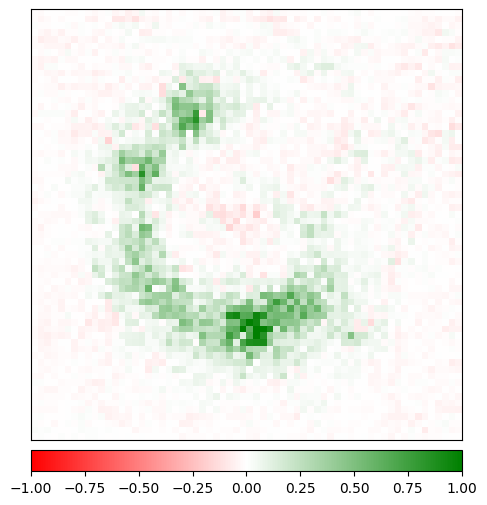

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [38]:
# 2. GradSHAP Explanation
gradient_shap = GradientShap(best_model)

# Baseline (black image)
baseline = torch.zeros_like(input_image).to(device)

# Generate attribution
grads_shap_attr = gradient_shap.attribute(
    input_image.to(device), baselines=baseline, target=torch.argmax(best_model(input_image.to(device))).item()
)

# Convert GradSHAP output to image
viz.visualize_image_attr(
    grads_shap_attr.squeeze(0).permute(1, 2, 0).cpu().detach().numpy(),
    sign="all", show_colorbar=True)

**Guided Grad-CAM Explanation**

/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


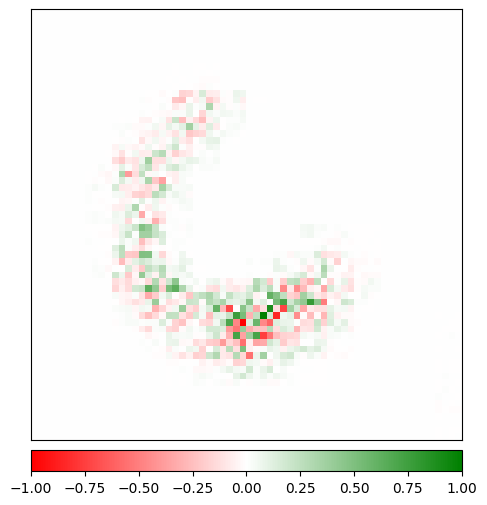

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [40]:
# 3. Guided Grad-CAM Explanation
layer = best_model.conv3

# Instantiate Grad-CAM
gradcam = GuidedGradCam(best_model, layer)
attributions = gradcam.attribute(input_image.to(device), target=torch.argmax(best_model(input_image.to(device))).item())

# Visualize Grad-CAM
viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.array(input_image),
    method="heat_map",
    sign="all",
    show_colorbar=True
)